In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nbodypy as npy
from galpy.util import bovy_plot,bovy_conversion,bovy_coords
import seaborn as sns
from galpy import potential
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import os 
import scipy.integrate as integrate
from scipy import interpolate

from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter,LogFormatter
import matplotlib.ticker as ticker

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)

current_palette = sns.color_palette("colorblind")
r0=8.
v0=220.

mwpot=MWPotential2014
nfwpot=potential.NFWPotential(a=2.,normalize=0.35, ro=r0, vo=v0)
cm=matplotlib.cm.get_cmap('plasma')


In [2]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    return "%g" % x

In [3]:
def plot_rmax_vmax(Mmin=1e5,Mmax=1e13,
                   conc=lambda m: 10.**(1.025-0.097*np.log10(m*0.671)),plot=True,
                   **kwargs):
    ms= np.logspace(np.log10(Mmin),np.log10(Mmax),201)/1e12
    rmax= np.empty_like(ms)
    vmax= np.empty_like(ms)
    for ii,m in enumerate(ms):
        nfwp= potential.NFWPotential(mvir=m,conc=conc(m),H=0.671*100,overdens=104.2,wrtcrit=True,ro=8.,vo=220.)
        try:
            rmax[ii]= nfwp.rmax(quantity=False)
            vmax[ii]= nfwp.vmax(quantity=False)
            raise
        except:
            rmax[ii]= 2.1625815870646098349*nfwp.a*nfwp._ro
            vmax[ii]= nfwp.vcirc(2.1625815870646098349*nfwp.a,quantity=False)
    if plot:
        kwargs['marker']= kwargs.get('marker','None')
        kwargs['ls']= kwargs.get('ls','-')
        plt.loglog(vmax,rmax,**kwargs)
        plt.xlabel(r'$v_\rm{max}\,(\rm{km\,s}^{-1})$')    
        plt.ylabel(r'$r_\rm{max}\,(\rm{kpc})$')
        
    return vmax,rmax


In [4]:
vmax_cdm,rmax_cdm=plot_rmax_vmax(plot=False)

In [5]:
nfwpot.rvir()

295.5735153741678

In [6]:
rp_legend,ecc_legend,zmax_legend,massi,mass0,rt0,rgc0,R_gc0,z0=np.loadtxt('./setup/submit_legend.dat',usecols = (3,4,5,7,8,9,10,11,12),unpack=True)
rt0*=1000.0
print(massi[0],mass0[0],rt0[0])

rp_legend_rp,ecc_legend_rp,zmax_legend_rp,massi_rp,mass0_rp,rt0,rgc0_rp,R_gc0_rp,z0_rp=np.loadtxt('./setup/submit_legend_rp.dat',usecols = (3,4,5,7,8,9,10,11,12),unpack=True)


1348910.0 852440.0 939.694


#If len(19) get vmax, rvmax

class OldSimulation(object):
  
    def __init__(self,i,rtide=False):
        
        self.id=i
        
        #Legend contains rp,e,and zmax in NFW potential
        
        ldata=np.loadtxt('submit_legend.dat',usecols = (0,3,4,5,7,8,9))

        self.rti=ldata[i,0]*1000.0
        self.rp=ldata[i,1]
        self.e=ldata[i,2]
        self.zmax=ldata[i,3]
        
        self.mzi=ldata[i,4]
        self.mz0=ldata[i,5]
        self.rt0=ldata[i,6]*1000.0
                
        self.label='rp=%s/e=%s/zmax=%s' % (str(round(self.rp,2)),str(round(self.e,2)),str(round(self.zmax,2)))
        
        if rtide:
            mwdata=np.loadtxt('./mwpot/rtextrct%s.npy' % (str(i)))
            nfwdata=np.loadtxt('./nfw/rtextrct%snfw.npy' % (str(i)))

        else:
            mwdata=np.loadtxt('./mwpot/rlextrct%s.npy' % (str(i)))
            nfwdata=np.loadtxt('./nfw/rlextrct%snfw.npy' % (str(i)))

        exmwdata=np.loadtxt('./mwpot/extrct%s.npy' % (str(i)))
        exnfwdata=np.loadtxt('./nfw/extrct%snfw.npy' % (str(i)))
        
        omwdata=np.loadtxt('./mwpot/norbit%s.npy' % (str(i)))
        onfwdata=np.loadtxt('./nfw/norbit%snfw.npy' % (str(i)))

        self.mwt=np.zeros(11)
        self.mwm=np.zeros(11)
        self.mwr10=np.zeros(11)
        self.mwrm=np.zeros(11)
        self.mwrl=np.zeros(11)
        self.mwrvmax=np.zeros(11)
        self.mwvmax=np.zeros(11)
        self.exmwt=np.zeros(11)
        self.exmwm=np.zeros(11)
        self.exmwr10=np.zeros(11)
        self.exmwrm=np.zeros(11)
        self.exmwrl=np.zeros(11)
        self.exmwrvmax=np.zeros(11)
        self.exmwvmax=np.zeros(11)

        self.nfwt=np.zeros(11)
        self.nfwm=np.zeros(11)
        self.nfwr10=np.zeros(11)
        self.nfwrm=np.zeros(11)
        self.nfwrl=np.zeros(11)
        self.nfwrvmax=np.zeros(11)
        self.nfwvmax=np.zeros(11)
        self.exnfwt=np.zeros(11)
        self.exnfwm=np.zeros(11)
        self.exnfwr10=np.zeros(11)
        self.exnfwrm=np.zeros(11)
        self.exnfwrl=np.zeros(11)
        self.exnfwrvmax=np.zeros(11)
        self.exnfwvmax=np.zeros(11)
        
        self.mwox=omwdata[:,1]
        self.mwoy=omwdata[:,2]
        self.mwoz=omwdata[:,3]
            
        self.mwovx=omwdata[:,4]
        self.mwovy=omwdata[:,5]
        self.mwovz=omwdata[:,6]
        
        self.mwrgc=np.sqrt(self.mwox**2.+self.mwoy**2.+self.mwoz**2.)
        self.mwrgcz0=self.mwrgc[-1]
        self.mwrmin=np.amin(self.mwrgc)
        self.mwrmean=np.mean(self.mwrgc)
        
        self.nfwox=onfwdata[:,1]
        self.nfwoy=onfwdata[:,2]
        self.nfwoz=onfwdata[:,3]
            
        self.nfwovx=onfwdata[:,4]
        self.nfwovy=onfwdata[:,5]
        self.nfwovz=onfwdata[:,6]
        
        self.nfwrgc=np.sqrt(self.nfwox**2.+self.nfwoy**2.+self.nfwoz**2.)
        self.nfwrgcz0=self.nfwrgc[-1]
        self.nfwrmin=np.amin(self.nfwrgc)
        self.nfwrmean=np.mean(self.nfwrgc)

        if isinstance(mwdata[0], np.float64):
            nmw=1
            self.mwt[0]=mwdata[2]
            self.mwm[0]=mwdata[4]
            self.mwr10[0]=mwdata[5]
            self.mwrm[0]=mwdata[9]
            self.mwrl[0]=mwdata[14]
            
            if len(mwdata)==19:
                self.mwrvmax[0]=mwdata[-2]
                self.mwvmax[0]=mwdata[-1]
                
            self.mwrlagrange_initial=mwdata[5:15]
            self.mwrlagrange_final=mwdata[5:15]

        else:
            nmw=len(mwdata[:,0])
            self.mwt[0:nmw]=mwdata[:,2]
            self.mwm[0:nmw]=mwdata[:,4]
            self.mwr10[0:nmw]=mwdata[:,5]
            self.mwrm[0:nmw]=mwdata[:,9]
            self.mwrl[0:nmw]=mwdata[:,14]
            
            if len(mwdata[0])==19:
                self.mwrvmax[0:nmw]=mwdata[:,-2]
                self.mwvmax[0:nmw]=mwdata[:,-1]
            
            self.mwrlagrange_initial=mwdata[0,5:15]
            self.mwrlagrange_final=mwdata[nmw-1,5:15]
        
        self.mwnl=np.sum(self.mwm > 0)
            
        self.mwrlzi=self.mwrl[0]
        self.mwmzi=self.mwm[0]
        self.mwrlz0=self.mwrl[-1]
        self.mwmz0=self.mwm[-1]
        self.nmw=nmw
        
        if isinstance(exmwdata[0], np.float64):
            exnmw=1
        else:
            exnmw=len(exmwdata[:,0])
            
        self.exmwt[0:exnmw]=exmwdata[:,2]
        self.exmwm[0:exnmw]=exmwdata[:,4]
        self.exmwr10[0:exnmw]=exmwdata[:,5]
        self.exmwrm[0:exnmw]=exmwdata[:,9]
        self.exmwrl[0:exnmw]=exmwdata[:,14]
        self.exmwnl=np.sum(self.exmwm > 0)
            
        self.exmwrlzi=self.exmwrl[0]
        self.exmwmzi=self.exmwm[0]
        self.exmwmz0=self.exmwm[-1]
        self.exnmw=exnmw
        
        self.exmwrvmax[0:exnmw]=exmwdata[:,-2]
        self.exmwvmax[0:exnmw]=exmwdata[:,-1]
        
        self.exmwrlagrange_initial=exmwdata[0,5:15]
        self.exmwrlagrange_final=exmwdata[exnmw-1,5:15]

        if isinstance(nfwdata[0], np.float64):
            nnfw=1
            self.nfwt[0]=nfwdata[2]
            self.nfwm[0]=nfwdata[4]
            self.nfwr10[0]=nfwdata[5]
            self.nfwrm[0]=nfwdata[9]
            self.nfwrl[0]=nfwdata[14]
            
            if len(nfwdata)==19:
                self.nfwrvmax[0]=nfwdata[-2]
                self.nfwvmax[0]=nfwdata[-1]
                
            self.nfwrlagrange_initial=nfwdata[0,5:15]
            self.nfwrlagrange_final=nfwdata[0,5:15]
        else:
            nnfw=len(nfwdata[:,0])
            
            self.nfwt[0:nnfw]=nfwdata[:,2]
            self.nfwm[0:nnfw]=nfwdata[:,4]
            self.nfwr10[0:nnfw]=nfwdata[:,5]
            self.nfwrm[0:nnfw]=nfwdata[:,9]
            self.nfwrl[0:nnfw]=nfwdata[:,14]
            
            if len(nfwdata[0])==19:
                self.nfwrvmax[0:nnfw]=nfwdata[:,-2]
                self.nfwvmax[0:nnfw]=nfwdata[:,-1]
                
            self.nfwrlagrange_initial=nfwdata[0,5:15]
            self.nfwrlagrange_final=nfwdata[nnfw-1,5:15]           
            
        self.nfwnl=np.sum(self.nfwm > 0)
        self.nfwrlzi=self.nfwrl[0]
        self.nfwmzi=self.nfwm[0]
        self.nfwrlz0=self.nfwrl[-1]
        self.nfwmz0=self.nfwm[-1]
        
        self.nnfw=nnfw
    
    
        if isinstance(exnfwdata[0], np.float64):
            exnnfw=1
        else:
            exnnfw=len(exnfwdata[:,0])
            
        self.exnfwt[0:exnnfw]=exnfwdata[:,2]
        self.exnfwm[0:exnnfw]=exnfwdata[:,4]
        self.exnfwr10[0:exnnfw]=exnfwdata[:,5]
        self.exnfwrm[0:exnnfw]=exnfwdata[:,9]
        self.exnfwrl[0:exnnfw]=exnfwdata[:,14]
        self.exnfwnl=np.sum(self.exnfwm > 0)
            
        self.exnfwrl0=self.exnfwrl[0]
        self.exnfwmzi=self.exnfwm[0]
        self.exnfwmz0=self.exnfwm[-1]
        self.exnnfw=exnnfw
        
        self.exmwrvmax[0:exnnfw]=exnfwdata[:,-2]
        self.exmwvmax[0:exnnfw]=exnfwdata[:,-1]
    
        self.exnfwrlagrange_initial=exnfwdata[0,5:15]
        self.exnfwrlagrange_final=exnfwdata[exnnfw-1,5:15]
    
        self.tinfall=self.exmwt[-1]
        
        if self.exnmw != self.exnnfw:
            print('N ERROR: ',i,self.exnmw,self.exnnfw)
            self.nerror=True
        else:
            self.nerror=False
            
        if self.mzi<self.mz0:
            self.merror=True
        else:
            self.merror=False
            
        #Flip times
        self.mwt=np.flip(self.mwt[0:self.mwnl])
        self.nfwt=np.flip(self.nfwt[0:self.nfwnl])
        self.exmwt=np.flip(self.exmwt)
        self.exnfwt=np.flip(self.exnfwt)

    def ratios(self):
                
        self.trat=np.zeros(self.exnmw)
        self.mrat=np.zeros(self.exnmw)
        self.rmrat=np.zeros(self.exnmw)

        self.mwrmr10=np.zeros(self.exnmw)
        self.nfwrmr10=np.zeros(self.exnmw)

        nfinal=np.minimum(self.nmw,self.nnfw)
        self.mrat[0:nfinal]=self.mwm[0:nfinal]/self.nfwm[0:nfinal]
        self.trat[0:nfinal]=self.mwt[0:nfinal]
        self.rmrat[0:nfinal]=self.mwrm[0:nfinal]/self.nfwrm[0:nfinal]

        
        self.mwrmr10[0:nfinal]=self.mwrm[0:nfinal]/self.mwr10[0:nfinal]
        self.nfwrmr10[0:nfinal]=self.nfwrm[0:nfinal]/self.nfwr10[0:nfinal]

        if nfinal < self.exnmw:
            self.trat[nfinal:self.exnmw]=self.exmwt[nfinal:self.exnmw]


    def rvmax_interpolate(self,times=None,gtype='MW',lookforward=False):
        if times is None:
            times=np.linspace(0.,10000.,10)
        elif isinstance(times,float):
            times=np.array([times])
        
        if gtype=='MW':
            t=self.mwt
            rvmax=self.mwrvmax[0:self.mwnl]
            vmax=self.mwvmax[0:self.mwnl]  
        elif gtype=='NFW':
            t=self.nfwt
            rvmax=self.nfwrvmax[0:self.nfwnl]
            vmax=self.nfwvmax[0:self.nfwnl]

        t=np.flip(t)
        rvmax=np.flip(rvmax)
        vmax=np.flip(vmax)
        
        tindx=(times < np.amax(t))

        t_interpolate=times[tindx]
        rv_interpolate=np.interp(times[tindx],t,rvmax)
        vmax_interpolate=np.interp(times[tindx],t,vmax)
        
        self.t_interpolate=t_interpolate
        self.rv_interpolate=rv_interpolate
        self.vmax_interpolate=vmax_interpolate           
        
        return np.array(t_interpolate),np.array(rv_interpolate),np.array(vmax_interpolate)
    
    def rtidalzi(self,rt):
        
        print(self.exnfwrlagrange_initial,rt)
        
        m=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])*self.exnfwm[0]
        print(m)
        indx=(self.exnfwrlagrange_initial < rt)
        nindx=np.invert(indx)
        
        x1=(self.exnfwrlagrange_initial[indx][-1],m[indx][-1])
        x2=(self.exnfwrlagrange_initial[nindx][0],m[nindx][0])
        
        mt=npy.interpolate(x1,x2,x=rt)
        return mt
                
    def orbits(self,pot,potname,ro=8.,vo=220.):
        if 'mw' in potname:
            x,y,z,vx,vy,vz=self.mwox[-1],self.mwoy[-1],self.mwoz[-1],self.mwovx[-1],self.mwovy[-1],self.mwovz[-1]
        elif 'nfw' in potname:
            x,y,z,vx,vy,vz=self.nfwox[-1],self.nfwoy[-1],self.nfwoz[-1],self.nfwovx[-1],self.nfwovy[-1],self.nfwovz[-1]
            
        R, phi, z = bovy_coords.rect_to_cyl(x/1000., y/1000., z/1000.)
        vR, vT, vz = bovy_coords.rect_to_cyl_vec(vx, vy, vz, x, y, z)

        vxvv = [R/ro, vR/vo, vT/vo, z/ro, vz/vo, phi]
        os = Orbit(vxvv, ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
        ts = np.linspace(0, 12. / bovy_conversion.time_in_Gyr(ro=ro, vo=vo), 1000)
        os.integrate(ts, pot)

        if 'mw' in potname:
            self.mwrp=os.rperi()
            self.mwecc=os.e()
            self.mwrap=os.rap()
            self.mwrmean=np.mean(os.r(ts))
            self.mwsemi=(self.mwrp+self.mwrap)/2.
            self.mwzmax=os.zmax()

        elif 'nfw' in potname:
            self.nfwrp=os.rperi()
            self.nfwecc=os.e()
            self.nfwrap=os.rap()  
            self.nfwrmean=np.mean(os.r(ts))
            self.nfwsemi=(self.nfwrp+self.nfwrap)/2.
            self.nfwzmax=os.zmax()

    def zinfall(self):
        
        zeds=[27.543909,23.133362,17.879936,14.78486,12.708647,11.202767,9.138494,7.770461,4.561298,3.244847,2.496477,2.002067,1.645364,1.372562,1.155066,0.976168,0.825403,0.695861,0.582787,0.48279,0.39339,0.312724,0.239368,0.172213,0.11038,0.053166,0.]
        times=[0.119,0.153,0.221,0.29,0.358,0.427,0.564,0.701,1.388,2.075,2.761,3.448,4.135,4.822,5.509,6.196,6.884,7.571,8.258,8.945,9.632,10.319,11.007,11.694,12.381,13.068,13.755]

        mindx=np.argmin(np.fabs(self.tinfall/1000.0-times))
        self.zinfall=zeds[mindx]

In [7]:
#If len(19) get vmax, rvmax

class Simulation(object):
  
    def __init__(self,i,rtide=False,extension=''):
        
        self.id=i
        
        #Legend contains rp,e,and zmax in NFW potential
        
        ldata=np.loadtxt('./mwpot%s/submit_legend.dat' % extension,usecols = (0,3,4,5,7,8,9))

        self.rti=ldata[i,0]*1000.0
        self.rp=ldata[i,1]
        self.e=ldata[i,2]
        self.zmax=ldata[i,3]
        
        self.mzi=ldata[i,4]
        self.mz0=ldata[i,5]
        self.rt0=ldata[i,6]*1000.0
                
        self.label='rp=%s/e=%s/zmax=%s' % (str(round(self.rp,2)),str(round(self.e,2)),str(round(self.zmax,2)))
        
        if rtide:
            mwdata=np.loadtxt('./mwpot%s/rtextrct%s.npy' % (extension,str(i)))
            nfwdata=np.loadtxt('./nfw%s/rtextrct%snfw.npy' % (extension,str(i)))

        else:
            mwdata=np.loadtxt('./mwpot%s/rlextrct%s.npy' % (extension,str(i)))
            nfwdata=np.loadtxt('./nfw%s/rlextrct%snfw.npy' % (extension,str(i)))

        exmwdata=np.loadtxt('./mwpot%s/extrct%s.npy' % (extension,str(i)))
        exnfwdata=np.loadtxt('./nfw%s/extrct%snfw.npy' % (extension,str(i)))
        
        omwdata=np.loadtxt('./mwpot%s/norbit%s.npy' % (extension,str(i)))
        onfwdata=np.loadtxt('./nfw%s/norbit%snfw.npy' % (extension,str(i)))
        
        self.mwox=omwdata[:,1]
        self.mwoy=omwdata[:,2]
        self.mwoz=omwdata[:,3]
            
        self.mwovx=omwdata[:,4]
        self.mwovy=omwdata[:,5]
        self.mwovz=omwdata[:,6]
        
        self.mwrgc=np.sqrt(self.mwox**2.+self.mwoy**2.+self.mwoz**2.)
        self.mwrgcz0=self.mwrgc[-1]
        self.mwrmin=np.amin(self.mwrgc)
        self.mwrmean=np.mean(self.mwrgc)
        
        self.nfwox=onfwdata[:,1]
        self.nfwoy=onfwdata[:,2]
        self.nfwoz=onfwdata[:,3]
            
        self.nfwovx=onfwdata[:,4]
        self.nfwovy=onfwdata[:,5]
        self.nfwovz=onfwdata[:,6]
        
        self.nfwrgc=np.sqrt(self.nfwox**2.+self.nfwoy**2.+self.nfwoz**2.)
        self.nfwrgcz0=self.nfwrgc[-1]
        self.nfwrmin=np.amin(self.nfwrgc)
        self.nfwrmean=np.mean(self.nfwrgc)

        if isinstance(mwdata[0], np.float64):
            nmw=1
            self.mwn=np.array([mwdata[0]])

            self.mwt=np.array([mwdata[2]])
            self.mwm=np.array([mwdata[4]])
            self.mwr10=np.array([mwdata[5]])
            self.mwrm=np.array([mwdata[9]])
            self.mwrl=np.array([mwdata[14]])
            
            if len(mwdata)==19:
                self.mwrvmax=np.array([mwdata[-2]])
                self.mwvmax=np.array([mwdata[-1]])
                
            self.mwrlagrange_initial=mwdata[5:15]
            self.mwrlagrange_final=mwdata[5:15]
            
            self.mwnl=1
                   
            self.mwrlzi=self.mwrl[0]
            self.mwmzi=self.mwm[0]

        else:
            nmw=len(mwdata[:,0])
            self.mwn=mwdata[:,0]
            self.mwt=mwdata[:,2]
            self.mwm=mwdata[:,4]
            self.mwr10=mwdata[:,5]
            self.mwrm=mwdata[:,9]
            self.mwrl=mwdata[:,14]
            
            if len(mwdata[0])==19:
                self.mwrvmax=mwdata[:,-2]
                self.mwvmax=mwdata[:,-1]
            
            self.mwrlagrange_initial=mwdata[0,5:15]
            self.mwrlagrange_final=mwdata[nmw-1,5:15]
        
            self.mwnl=np.sum(self.mwm > 0)

            self.mwrlzi=self.mwrl[0]
            self.mwmzi=self.mwm[0]
            
        self.nmw=nmw
        
        if isinstance(exmwdata[0], np.float64):
            exnmw=1
            print(i,'WHY IS EXNMW ONLY 1 TIMESTEP?')
        else:
            exnmw=len(exmwdata[:,0])
            
        self.exmwn=exmwdata[:,0]
        self.exmwt=exmwdata[:,2]
        self.exmwm=exmwdata[:,4]
        self.exmwr10=exmwdata[:,5]
        self.exmwrm=exmwdata[:,9]
        self.exmwrl=exmwdata[:,14]
        self.exmwnl=np.sum(self.exmwm > 0)
            
        self.exmwrlzi=self.exmwrl[0]
        self.exmwmzi=self.exmwm[0]
        self.exmwmz0=self.exmwm[-1]
        self.exnmw=exnmw
        
        self.exmwrvmax=exmwdata[:,-2]
        self.exmwvmax=exmwdata[:,-1]
        
        self.exmwrlagrange_initial=exmwdata[0,5:15]
        self.exmwrlagrange_final=exmwdata[exnmw-1,5:15]

        
        if self.nmw < self.exnmw:
            self.mwrlz0=0.0
            self.mwmz0=0.0           
        else:  
            self.mwrlz0=self.mwrl[-1]
            self.mwmz0=self.mwm[-1]
        
        if isinstance(nfwdata[0], np.float64):
            nnfw=1
            self.nfwn=np.array([nfwdata[0]])
            self.nfwt=np.array([nfwdata[2]])
            self.nfwm=np.array([nfwdata[4]])
            self.nfwr10=np.array([nfwdata[5]])
            self.nfwrm=np.array([nfwdata[9]])
            self.nfwrl=np.array([nfwdata[14]])
            
            if len(nfwdata)==19:
                self.nfwrvmax=np.array([nfwdata[-2]])
                self.nfwvmax=np.array([nfwdata[-1]])
                
            self.nfwrlagrange_initial=nfwdata[0,5:15]
            self.nfwrlagrange_final=nfwdata[0,5:15]
            
            self.nfwnl=1
            self.nfwrlzi=self.nfwrl[0]
            self.nfwmzi=self.nfwm[0]  
            self.nnfw=nnfw
        else:
            nnfw=len(nfwdata[:,0])
            
            self.nfwn=nfwdata[:,0]
            self.nfwt=nfwdata[:,2]
            self.nfwm=nfwdata[:,4]
            self.nfwr10=nfwdata[:,5]
            self.nfwrm=nfwdata[:,9]
            self.nfwrl=nfwdata[:,14]
            
            if len(nfwdata[0])==19:
                self.nfwrvmax=nfwdata[:,-2]
                self.nfwvmax=nfwdata[:,-1]
                
            self.nfwrlagrange_initial=nfwdata[0,5:15]
            self.nfwrlagrange_final=nfwdata[nnfw-1,5:15]           
            
            self.nfwnl=np.sum(self.nfwm > 0)
            self.nfwrlzi=self.nfwrl[0]
            self.nfwmzi=self.nfwm[0]       
            self.nnfw=nnfw
    
    
        if isinstance(exnfwdata[0], np.float64):
            exnnfw=1
            print(i,'WHY IS EXNFW ONLY 1 TIMESTEP?')

        else:
            exnnfw=len(exnfwdata[:,0])

        self.exnfwn=exnfwdata[:,0]
        self.exnfwt=exnfwdata[:,2]
        self.exnfwm=exnfwdata[:,4]
        self.exnfwr10=exnfwdata[:,5]
        self.exnfwrm=exnfwdata[:,9]
        self.exnfwrl=exnfwdata[:,14]
        self.exnfwnl=np.sum(self.exnfwm > 0)
            
        self.exnfwrl0=self.exnfwrl[0]
        self.exnfwmzi=self.exnfwm[0]
        self.exnfwmz0=self.exnfwm[-1]
        self.exnnfw=exnnfw
        
        self.exmwrvmax=exnfwdata[:,-2]
        self.exmwvmax=exnfwdata[:,-1]
    
        self.exnfwrlagrange_initial=exnfwdata[0,5:15]
        self.exnfwrlagrange_final=exnfwdata[exnnfw-1,5:15]

        self.tinfall=self.exmwt[-1]
        
        if self.exnmw != self.exnnfw:
            print('N ERROR: ',i,self.exnmw,self.exnnfw)
            self.nerror=True
        else:
            self.nerror=False
            
        if self.mzi<self.mz0:
            self.merror=True
        else:
            self.merror=False
            
        if self.nnfw < self.exnnfw:
            self.nfwrlz0=0.
            self.nfwmz0=0.
        else:     
            self.nfwrlz0=self.nfwrl[-1]
            self.nfwmz0=self.nfwm[-1]
            
        #Flip times
        self.mwt=np.flip(self.mwt)
        self.nfwt=np.flip(self.nfwt)
        self.exmwt=np.flip(self.exmwt)
        self.exnfwt=np.flip(self.exnfwt)
        
        if self.exmwn[0]!=self.exnfwn[0]:
            print('N MW != N NFW')
        
    def ratios(self):
                
        nfinal=np.minimum(self.nmw,self.nnfw)
        

        self.mrat=self.mwm[0:nfinal]/self.nfwm[0:nfinal]
        self.trat=self.mwt[0:nfinal]
        self.rmrat=self.mwrm[0:nfinal]/self.nfwrm[0:nfinal]


        self.mwrmr10=self.mwrm[0:nfinal]/self.mwr10[0:nfinal]
        self.nfwrmr10=self.nfwrm[0:nfinal]/self.nfwr10[0:nfinal]

    def rvmax_interpolate(self,times=None,gtype='MW',lookforward=False):
        if times is None:
            times=np.linspace(0.,10000.,10)
        elif isinstance(times,float):
            times=np.array([times])
        
        if gtype=='MW':
            t=self.mwt
            rvmax=self.mwrvmax
            vmax=self.mwvmax 
        elif gtype=='NFW':
            t=self.nfwt
            rvmax=self.nfwrvmax
            vmax=self.nfwvmax

        t=np.flip(t)
        rvmax=np.flip(rvmax)
        vmax=np.flip(vmax)
        
        tindx=(times < np.amax(t))

        t_interpolate=times[tindx]
        rv_interpolate=np.interp(times[tindx],t,rvmax)
        vmax_interpolate=np.interp(times[tindx],t,vmax)
        
        self.t_interpolate=t_interpolate
        self.rv_interpolate=rv_interpolate
        self.vmax_interpolate=vmax_interpolate           
        
        return np.array(t_interpolate),np.array(rv_interpolate),np.array(vmax_interpolate)
    
    def rtidalzi(self,rt):
        
        print(self.exnfwrlagrange_initial,rt)
        
        m=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])*self.exnfwm[0]
        print(m)
        indx=(self.exnfwrlagrange_initial < rt)
        nindx=np.invert(indx)
        
        x1=(self.exnfwrlagrange_initial[indx][-1],m[indx][-1])
        x2=(self.exnfwrlagrange_initial[nindx][0],m[nindx][0])
        
        mt=npy.interpolate(x1,x2,x=rt)
        return mt
                
    def orbits(self,pot,potname,ro=8.,vo=220.):
        if 'mw' in potname:
            x,y,z,vx,vy,vz=self.mwox[-1],self.mwoy[-1],self.mwoz[-1],self.mwovx[-1],self.mwovy[-1],self.mwovz[-1]
        elif 'nfw' in potname:
            x,y,z,vx,vy,vz=self.nfwox[-1],self.nfwoy[-1],self.nfwoz[-1],self.nfwovx[-1],self.nfwovy[-1],self.nfwovz[-1]
            
        R, phi, z = bovy_coords.rect_to_cyl(x/1000., y/1000., z/1000.)
        vR, vT, vz = bovy_coords.rect_to_cyl_vec(vx, vy, vz, x, y, z)

        vxvv = [R/ro, vR/vo, vT/vo, z/ro, vz/vo, phi]
        os = Orbit(vxvv, ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
        ts = np.linspace(0, 12. / bovy_conversion.time_in_Gyr(ro=ro, vo=vo), 1000)
        os.integrate(ts, pot)

        if 'mw' in potname:
            self.mwrp=os.rperi()
            self.mwecc=os.e()
            self.mwrap=os.rap()
            self.mwrmean=np.mean(os.r(ts))
            self.mwsemi=(self.mwrp+self.mwrap)/2.
            self.mwzmax=os.zmax()
            self.mwvr=os.vR(0.)
            self.mwvT=os.vT(0.)
            self.mwvphi=os.vphi(0.)

        elif 'nfw' in potname:
            self.nfwrp=os.rperi()
            self.nfwecc=os.e()
            self.nfwrap=os.rap()  
            self.nfwrmean=np.mean(os.r(ts))
            self.nfwsemi=(self.nfwrp+self.nfwrap)/2.
            self.nfwzmax=os.zmax()
            self.nfwvr=os.vR(0.)
            self.nfwvT=os.vT(0.)
            self.nfwvphi=os.vphi(0.)

    def zinfall(self):
        
        zeds=[27.543909,23.133362,17.879936,14.78486,12.708647,11.202767,9.138494,7.770461,4.561298,3.244847,2.496477,2.002067,1.645364,1.372562,1.155066,0.976168,0.825403,0.695861,0.582787,0.48279,0.39339,0.312724,0.239368,0.172213,0.11038,0.053166,0.]
        times=[0.119,0.153,0.221,0.29,0.358,0.427,0.564,0.701,1.388,2.075,2.761,3.448,4.135,4.822,5.509,6.196,6.884,7.571,8.258,8.945,9.632,10.319,11.007,11.694,12.381,13.068,13.755]

        mindx=np.argmin(np.fabs(self.tinfall/1000.0-times))
        self.zinfall=zeds[mindx]
        
    def mass_interpolate(self,times=None,gtype='MW',lookforward=False):
        if times is None:
            times=np.linspace(0.,10000.,10)
        elif isinstance(times,float):
            times=np.array([times])
        
        if gtype=='MW':
            t=self.mwt
            mass=self.mwm
        elif gtype=='NFW':
            t=self.nfwt
            mass=self.nfwm

            
        t=np.flip(t)
        #mass=np.flip(mass)

        
        tindx=(times < np.amax(t))

        t_interpolate=times[tindx]
        m_interpolate=np.interp(times[tindx],t,mass)
        
        self.tm_interpolate=t_interpolate
        self.m_interpolate=m_interpolate
        
        return np.array(t_interpolate),np.array(m_interpolate)

In [8]:
temp=Simulation(253,rtide=False)
temp.ratios()
temp.orbits(mwpot,'mwpot')
temp.orbits(nfwpot,'nfwpot')
temp.zinfall()

In [9]:
o=Orbit()
print(o.vR(),o.vT(),o.vz())
cluster=npy.StarCluster()
cluster.x,cluster.y,cluster.z=o.x(),o.y(),o.z()
cluster.vx,cluster.vy,cluster.vz=o.vx(),o.vy(),o.vz()
r, theta, phi, vr, vtheta, vphi=npy.sphere_coords(cluster)

print(r, theta, phi, vr, vtheta, vphi)

-11.1 232.24 7.25
8.00002703995 0.0 1.56819633265 -11.0811125459 232.24 -7.27883539758


In [10]:
#Check settings for subhalo
def f(x):
    return np.log(1.+x)-x/(1+x)

def fb(r,rh,c,epsilon):
    #fbound < 1.79/f (c) * (ε/rs,0)*(rh/rs,0)
    
    return (1.79/f(c))*(epsilon/r)*(rh/r)

def check_subhalo(phalo,rhalo,debug=False,wrtcrit=True):
    
    mhalo=phalo*(4.0*np.pi*((rhalo*1000.0)**3.))
    
   
    #If we want to evolve the cluster to 1% dissolution
    #fsub < 0.32(Nacc/1000)**−0.8 ,
    Nacc=1000.0*(0.01**(-1./0.8))/0.32

    #Set softening to ε = 0.05 (Nacc/10^5)^−1/3 in NBODY units
    epsilon=0.05*((Nacc/1.0e5)**(-1./3.))


    #Setup initial halo
    sub_halo_m=mhalo
    #sub_halo_r=1.05*np.sqrt(mhalo/1.0e8)
    sub_halo_r=rhalo
    sub_halo=potential.NFWPotential(amp=mhalo/bovy_conversion.mass_in_msol(ro=r0,vo=v0),a=sub_halo_r/r0,ro=r0,vo=v0)
    sub_halo_m200=sub_halo.mass(200./r0,0.0,ro=r0,vo=v0)
    sub_halo_mvir=sub_halo.mvir()
    sub_halo_rv=sub_halo.rvir(wrtcrit=wrtcrit)
    sub_halo_c=sub_halo.conc()
    sub_halo_rh=sub_halo_r*3.6*((sub_halo_c/10)**.63)

    #Scale epsilon to N-body units by assuming RBAR=scale radius
    epsilon*=sub_halo_r
    
    #Check force resolution: 
    f_b=fb(sub_halo_r,sub_halo_rh,sub_halo_c,epsilon)
    
    #To get to 1%,  should be decrease epsilon?
    while f_b>0.01:
        epsilon/=2.
        f_b=fb(sub_halo_r,sub_halo_rh,sub_halo_c,epsilon)

    if debug:
        print('rho rs m N epsilon m r rv c rh m200')
        print(phalo,rhalo,mhalo,Nacc,epsilon,sub_halo_m,sub_halo_r,sub_halo_rv,sub_halo_c,sub_halo_rh,sub_halo_m200)

    return Nacc,epsilon,sub_halo_m,sub_halo_r,sub_halo_rv,sub_halo_mvir,sub_halo_c,sub_halo_rh,sub_halo_m200

In [11]:
def make_halo(pot,rmax,n=100000,nsim='',galaxy=False,debug=False,wrtcrit=True):
    
    r0=8.
    v0=220.
    
    r_v=pot.rvir(wrtcrit=wrtcrit)
    r_s=pot.a*pot._ro 
    c=pot.conc()
    mvir=pot.mvir()
    r_t=rmax
        
    #mtot=pot.dens(1./r0,0.0,ro=r0,vo=v0)*(1000.0**3.)/rho_nfw(1.,r_s,r_t,1.)
    mtot=pot.mass(r_t/r0,0.0,ro=r0,vo=v0)/menc(r_t,r_s,r_t,1.)

    print('MTOT = ',mtot)

    
    #Find number of halos you need to have n within rmax
    mmax=menc(10.0*r_t,r_s,r_t,mtot)
    nhalo=mmax/(menc(rmax,r_s,r_t,mtot)/float(n))
    
    rad=np.logspace(np.log10(0.001*rmax),np.log10(rmax),100)
    rho=rho_nfw(rad,r_s,r_t,mtot)
    
    mass=[]
    for r in rad:
        mass.append(menc(r,r_s,r_t,mtot))
        
        
    if galaxy:
        command=('mkhalo out=dmsub%s.nemo nbody=%i model=NFW r_s=%f M=%f r_t=%f WD_units=t accname=\'PowSphwCut+MiyamotoNagai\', accpars=\'0,1001.7912681201547,1.8,1.9#0,306770.41839070275,3.0,0.28\'' % (nsim,nhalo,r_s,mmax,-1.*r_t))    
    else:
        command=('mkhalo out=dmsub%s.nemo nbody=%i model=NFW r_s=%f M=%f r_t=%f WD_units=t' % (nsim,nhalo,r_s,mmax,-1.*r_t))    

    if debug:
        print(command)
        
    print(r0,v0,r_v,r_s,c,mvir,r_t,mmax)


        
    return rad,rho,mass,command

    
def rho_nfw(r,r_s,r_t,mtot):    
    
    r_c=0.0
    
    #NFW:
    inner=1.
    eta=1.
    outer=3.
    
    x =np.sqrt(r**2.+r_c**2.)/r_s
    
    if False:
        trunc=1./np.cosh(r/r_t)
    else:
        trunc=2./(1/np.cosh(r/r_t)+np.cosh(r/r_t))
    
    amp=mtot*trunc
    
    model=(x**inner)*((x**eta+1.)**((outer-inner)/eta))
         
    return amp/model

def dM(r,r_s,r_t,mtot):
    return 4.0*np.pi*(r**2.)*rho_nfw(r,r_s,r_t,mtot)

def menc(r,r_s,r_t,mtot):
    return integrate.quad(dM, 0, r,args=(r_s,r_t,mtot))[0]
    
    

In [12]:
rtide=False
nend=2266
#nend=1000

mod=[]
#nend=1
for i in range(0,nend):
    #temp=Simulation(i,rtide=rtide)
    #mod.append(temp)
    #mod[-1].ratios()
    #mod[-1].mzi=massi[i]
    #mod[-1].mz0=mass0[i]

    #'''
    try:
        temp=Simulation(i,rtide=rtide)
    
        if not temp.nerror and not temp.merror:
            mod.append(temp)
            mod[-1].ratios()
            mod[-1].orbits(mwpot,'mwpot')
            mod[-1].orbits(nfwpot,'nfwpot')
            mod[-1].zinfall()
        else:
            print(i,temp.nerror,temp.merror)
    except:
        print('ERROR: ',i)
    #'''

78 False True
84 False True
97 False True
133 False True
167 False True
212 False True
266 False True
307 False True
337 False True
375 False True
377 False True
400 False True
411 False True
413 False True
437 False True
446 False True
504 False True
509 False True
551 False True
576 False True
581 False True
584 False True
586 False True
600 False True
618 False True
645 False True
664 False True
724 False True
725 False True
748 False True
761 False True
790 False True
793 False True
812 False True
822 False True
859 False True
865 False True
931 False True
N ERROR:  963 7 11
963 True False
N ERROR:  964 8 11
964 True False
N ERROR:  965 9 11
965 True True
N ERROR:  966 9 11
966 True False
968 False True
N ERROR:  969 4 9
969 True False
1012 False True
1025 False True
1040 False True
1046 False True
1058 False True
1060 False True
1081 False True
1091 False True
1113 False True
1144 False True
1154 False True
1276 False True
1278 False True
1287 False True
1357 False True
1370 False

In [13]:
nend_outer=1525

for i in range(0,nend_outer):
    #temp=Simulation(i,rtide=rtide)
    #mod.append(temp)
    #mod[-1].ratios()
    #mod[-1].mzi=massi[i]
    #mod[-1].mz0=mass0[i]

    #'''
    try:
        temp=Simulation(i,rtide=rtide,extension='_outer')
    
        if not temp.nerror and not temp.merror:
            mod.append(temp)
            mod[-1].ratios()
            mod[-1].orbits(mwpot,'mwpot')
            mod[-1].orbits(nfwpot,'nfwpot')
            mod[-1].zinfall()
        else:
            print(i,temp.nerror,temp.merror)
    except:
        print('ERROR: ',i)
    #'''

N ERROR:  0 8 11
0 True False
N ERROR:  2 6 11
2 True False
15 False True
16 False True
56 False True
101 False True
104 False True
128 False True
169 False True
175 False True
176 False True
189 False True
220 False True
225 False True
270 False True
275 False True
278 False True
284 False True
334 False True
341 False True
342 False True
415 False True
434 False True
448 False True
449 False True
461 False True
465 False True
480 False True
490 False True
498 False True
509 False True
540 False True
551 False True
554 False True
582 False True
583 False True
602 False True
619 False True
654 False True
660 False True
687 False True
714 False True
727 False True
728 False True
777 False True
784 False True
785 False True
803 False True
817 False True
845 False True
895 False True
921 False True
944 False True
955 False True
978 False True
1016 False True
1029 False True
1084 False True
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: loadtxt: Empty input f

In [14]:
temp=Simulation(0,rtide=rtide,extension='_rv')

In [15]:
nend_rv=533

for i in range(0,nend_rv):
    #temp=Simulation(i,rtide=rtide)
    #mod.append(temp)
    #mod[-1].ratios()
    #mod[-1].mzi=massi[i]
    #mod[-1].mz0=mass0[i]

    #'''
    try:
        temp=Simulation(i,rtide=rtide,extension='_rv')
    
        if not temp.nerror and not temp.merror:
            mod.append(temp)
            mod[-1].ratios()
            mod[-1].orbits(mwpot,'mwpot')
            mod[-1].orbits(nfwpot,'nfwpot')
            mod[-1].zinfall()
        else:
            print(i,temp.nerror,temp.merror)
    except:
        print('ERROR: ',i)
    #'''

8 False True
39 False True
40 False True
43 False True
60 False True
79 False True
82 False True
99 False True
104 False True
148 False True
186 False True
188 False True
310 False True
322 False True
400 False True
513 False True


In [16]:
nend_final=2271

for i in range(0,nend_final):
    #temp=Simulation(i,rtide=rtide)
    #mod.append(temp)
    #mod[-1].ratios()
    #mod[-1].mzi=massi[i]
    #mod[-1].mz0=mass0[i]

    #'''
    try:
        temp=Simulation(i,rtide=rtide,extension='_final')
    
        if not temp.nerror and not temp.merror:
            mod.append(temp)
            mod[-1].ratios()
            mod[-1].orbits(mwpot,'mwpot')
            mod[-1].orbits(nfwpot,'nfwpot')
            mod[-1].zinfall()
        else:
            print(i,temp.nerror,temp.merror)
    except:
        print('ERROR: ',i)
    #'''

11 False True
16 False True
18 False True
21 False True
25 False True
26 False True
27 False True
41 False True
54 False True
57 False True
58 False True
62 False True
71 False True
74 False True
102 False True
106 False True
108 False True
118 False True
125 False True
126 False True
141 False True
167 False True
172 False True
181 False True
201 False True
230 False True
231 False True
241 False True
252 False True
258 False True
261 False True
281 False True
307 False True
319 False True
324 False True
325 False True
327 False True
339 False True
342 False True
347 False True
348 False True
371 False True
372 False True
373 False True
393 False True
404 False True
407 False True
429 False True
442 False True
447 False True
460 False True
462 False True
500 False True
507 False True
581 False True
613 False True
622 False True
626 False True
642 False True
647 False True
648 False True
657 False True
676 False True
729 False True
747 False True
778 False True
789 False True
816 False

In [17]:
2265+1524+2270+532

6591

In [18]:
temp=Simulation(2269,rtide=rtide,extension='_final')


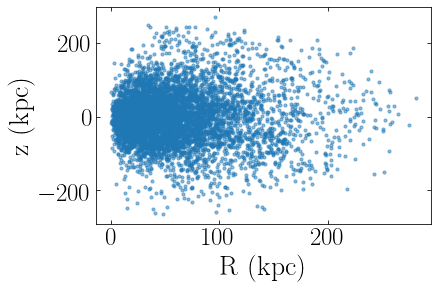

In [19]:
xi=np.array([m.mwox[0] for m in mod])/1000.0
yi=np.array([m.mwoy[0] for m in mod])/1000.0
zi=np.array([m.mwoz[0] for m in mod])/1000.0

ri=np.sqrt(xi**2.+yi**2.)
mi=np.array([m.mzi for m in mod])

mwmz0=np.array([m.mwmz0 for m in mod])
nfwmz0=np.array([m.nfwmz0 for m in mod])
vl2mz0=np.array([m.mz0 for m in mod])


#plt.scatter(xi,zi,c=np.log10(mi),s=1.)
plt.scatter(ri,zi,s=10.,alpha=0.5)

#plt.xlim(0,100)
#plt.ylim(0,100)
plt.xlabel(r'$\rm R \ (kpc)$')
plt.ylabel(r'$\rm z \ (kpc)$')
#cbar=plt.colorbar()
#cbar.set_label(r'$\rm \log_{10} (M)$')
plt.savefig('via_lactea.pdf')
plt.show()
plt.close()

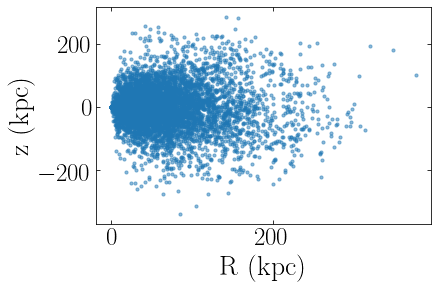

In [20]:
xf=np.array([m.mwox[-1] for m in mod])/1000.0
yf=np.array([m.mwoy[-1] for m in mod])/1000.0
zf=np.array([m.mwoz[-1] for m in mod])/1000.0

rf=np.sqrt(xf**2.+yf**2.)

#plt.scatter(xi,zi,c=np.log10(mi),s=1.)
plt.scatter(rf,zf,s=10.,alpha=0.5)

#plt.xlim(0,100)
#plt.ylim(0,100)
plt.xlabel(r'$\rm R \ (kpc)$')
plt.ylabel(r'$\rm z \ (kpc)$')
#cbar=plt.colorbar()
#cbar.set_label(r'$\rm \log_{10} (M)$')
plt.savefig('via_lacteaf.pdf')
plt.show()
plt.close()

In [21]:
nfwsemi=np.array([m.nfwsemi for m in mod])
mwsemi=np.array([m.mwsemi for m in mod])
nfwecc=np.array([m.nfwecc for m in mod])
mwecc=np.array([m.mwecc for m in mod])

vlecc=np.array([m.e for m in mod])


tinfall=np.array([m.tinfall for m in mod])
zinfall=np.array([m.zinfall for m in mod])

print(tinfall)

[  4812.5     1375.       687.5   ...,   4812.5     5500.     10308.594]


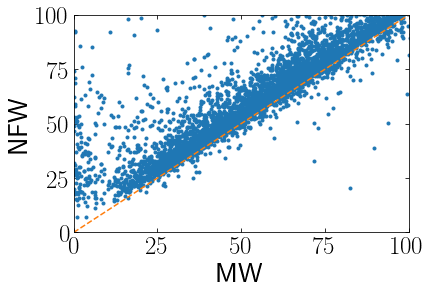

2.52936796796


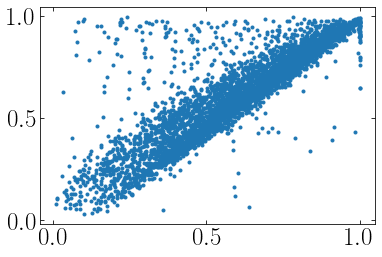

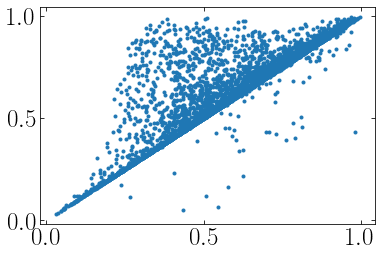

In [22]:
plt.plot(mwsemi,nfwsemi,'.')
plt.plot([0,100],[0,100],'--')
plt.xlabel('MW')
plt.ylabel('NFW')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()
plt.close()

print(np.mean(nfwsemi/mwsemi))

plt.plot(mwecc,nfwecc,'.')
plt.show()
plt.close()

plt.plot(vlecc,nfwecc,'.')
plt.show()
plt.close()



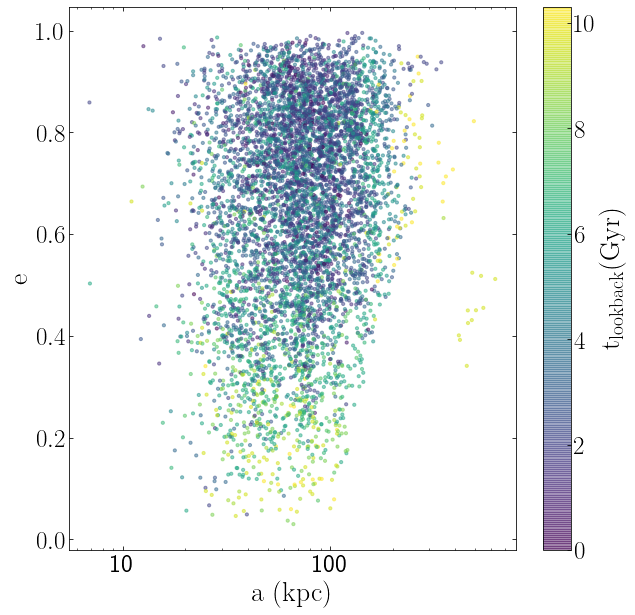

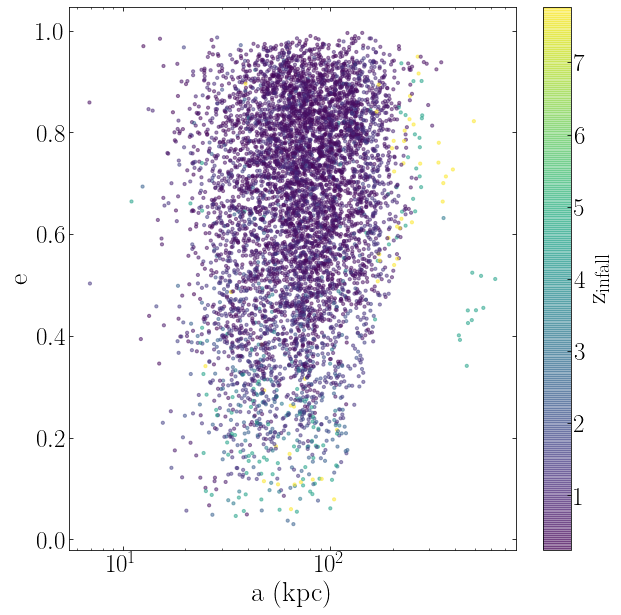

In [23]:

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.scatter(nfwsemi,nfwecc,c=np.amax(tinfall)/1000.0-tinfall/1000.0,s=10.,alpha=0.5)
ax = plt.gca()
ax.set_xscale('log')

plt.xlabel(r'$\rm a \ (kpc)$')
plt.ylabel(r'$\rm e$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm t_{lookback} (Gyr)$')
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.savefig('via_lactea_semi_ecc.pdf')
plt.show()
plt.close()


plt.scatter(nfwsemi,nfwecc,c=zinfall,s=10.,alpha=0.5)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel(r'$\rm a \ (kpc)$')
plt.ylabel(r'$\rm e$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm z_{infall}$')
plt.savefig('via_lactea_semi_ecc_z.pdf')
plt.show()
plt.close()

In [24]:
tinfall[0],mod[0].mwt

(4812.5,
 array([ 4812.5  ,  4332.031,  3851.562,  3367.188,  2886.719,  2406.25 ,
         1925.781,  1445.312,   964.844,   484.375,     0.   ]))

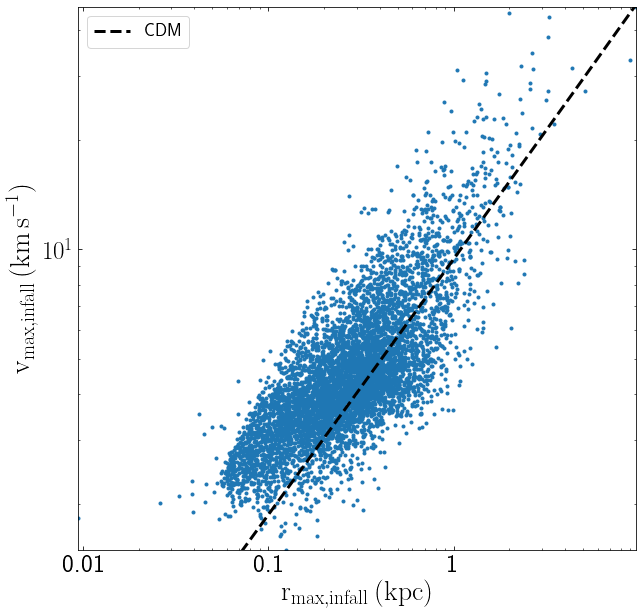

In [25]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

vmax=np.array([m.mwvmax[0] for m in mod])
rvmax=np.array([m.mwrvmax[0] for m in mod])/1000.0
plt.loglog(rvmax,vmax,'.')

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3,label='CDM')
plt.ylabel(r'$\rm v_{max,infall}\,({km\,s}^{-1})$')    
plt.xlabel(r'$\rm r_{max,infall}\,({kpc})$')
plt.legend(fontsize=18.)
plt.xlim(np.amin(rvmax),np.amax(rvmax))
plt.ylim(np.amin(vmax),np.amax(vmax))
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.savefig('via_lactea_rvmax_infall.pdf')

plt.show()
plt.close()



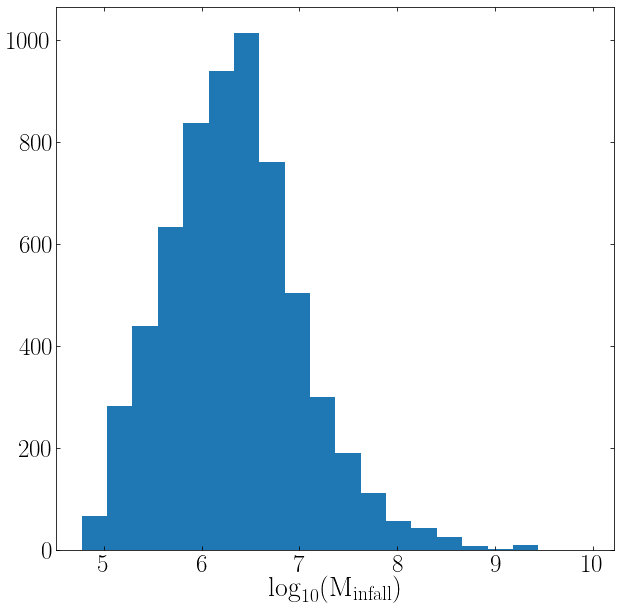

4.77625504051 9.95731318881


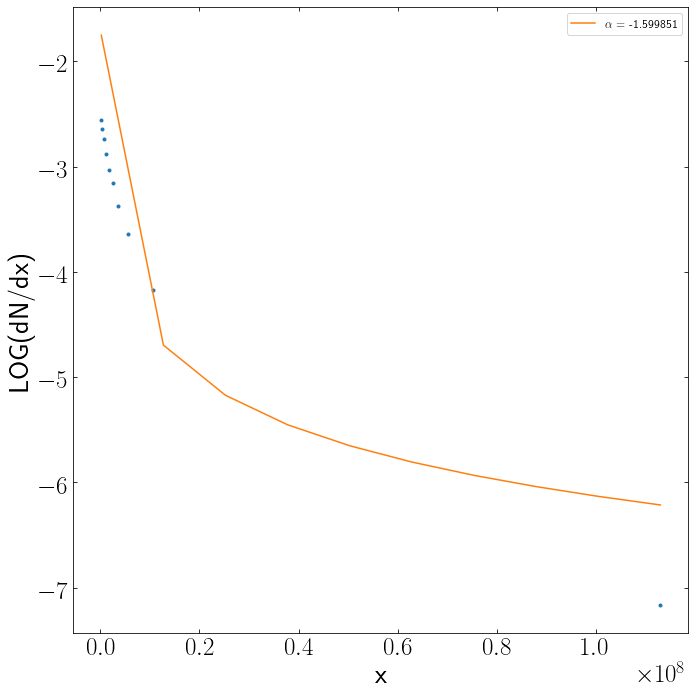

In [26]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

n,bins,patch=plt.hist(np.log10(mi),bins=20)

plt.xlabel(r'$\rm \log_{10} (M_{infall})$')
plt.savefig('via_lactea_imf.pdf')
plt.show()
plt.close()

x_mean, x_hist, dx, alpha, ealpha, yalpha, eyalpha=npy.dx_function(mi,plot=True)
print(np.amin(np.log10(mi)),np.amax(np.log10(mi)))

In [27]:
rp=np.array([m.nfwrp for m in mod])
ecc=np.array([m.nfwecc for m in mod])
zmax=np.array([m.nfwzmax for m in mod])
mrat=mwmz0/nfwmz0

/usr/local/lib/python3.7/site-packages/amuse/units/quantities.py:1379: RuntimeWarning: divide by zero encountered in true_divide
  return numpy.true_divide(array, other, out)

/usr/local/lib/python3.7/site-packages/amuse/units/quantities.py:1379: RuntimeWarning: invalid value encountered in true_divide
  return numpy.true_divide(array, other, out)



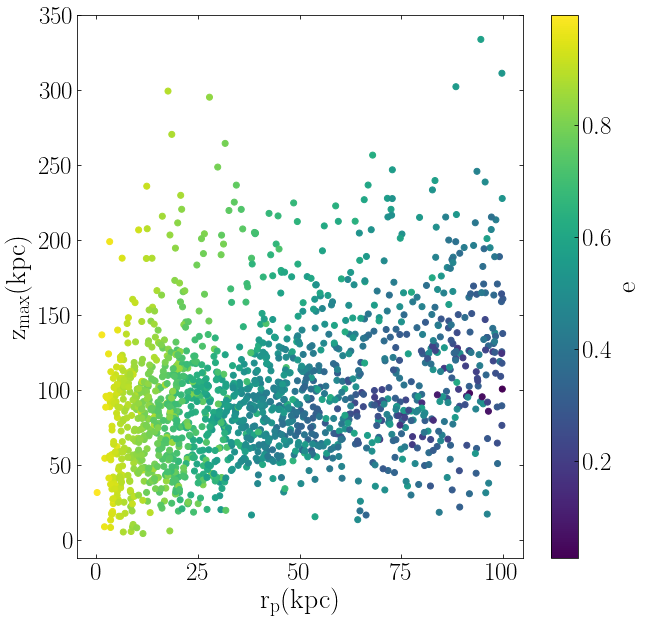

In [28]:


#plt.scatter(rp_legend,zmax_legend,c=ecc_legend)
plt.scatter(rp_legend_rp,zmax_legend_rp,c=ecc_legend_rp)

#plt.xlim(0,100)
#plt.ylim(0,100)
plt.xlabel(r'$\rm r_p (kpc)$')
plt.ylabel(r'$\rm z_{max} (kpc)$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm e$')
plt.savefig('via_lactea_rp_zmax.pdf')
plt.show()
plt.close()

In [128]:
mwnl=np.array([m.mwnl for m in mod])
nfwnl=np.array([m.nfwnl for m in mod])
print(np.sum((np.array(mwnl) < 11)),' of ',len(mwnl), ' subhalos in MW dissolve')
print(np.sum((np.array(nfwnl) < 11)),' of ',len(nfwnl),' subhalos in NFW dissolve')


print(len(mod)-np.sum(mwmz0>0),len(mod)-np.sum(nfwmz0>0))

2350  of  6236  subhalos in MW dissolve
520  of  6236  subhalos in NFW dissolve
2350 520


In [129]:
2350-520

1830

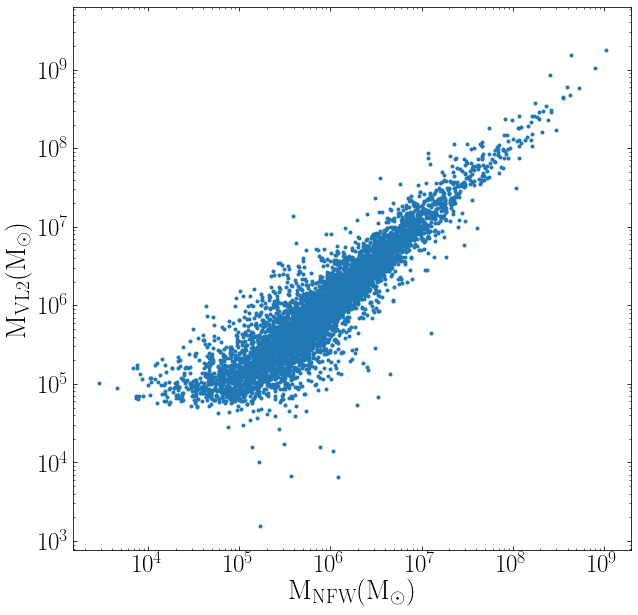

In [30]:


bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
plt.loglog(nfwmz0,vl2mz0,'.')
#plt.loglog([1.0e4,1.0e9],[1.0e4,1.0e9],'k--')
plt.xlabel(r'$\rm M_{NFW} (M_{\odot})$')
plt.ylabel(r'$\rm M_{VL2} (M_{\odot})$')


#plt.gca().xaxis.set_major_formatter(major_formatter)
#plt.gca().yaxis.set_major_formatter(major_formatter)

plt.savefig('via_lactea_nfw_compare.pdf')
plt.show()
plt.close()

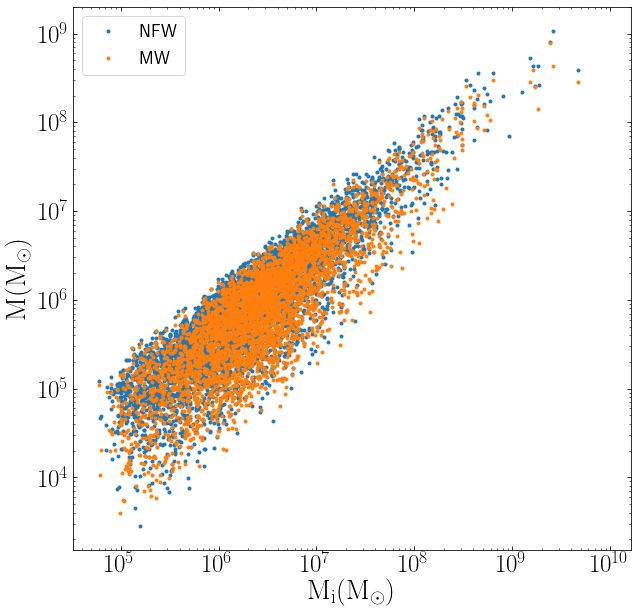

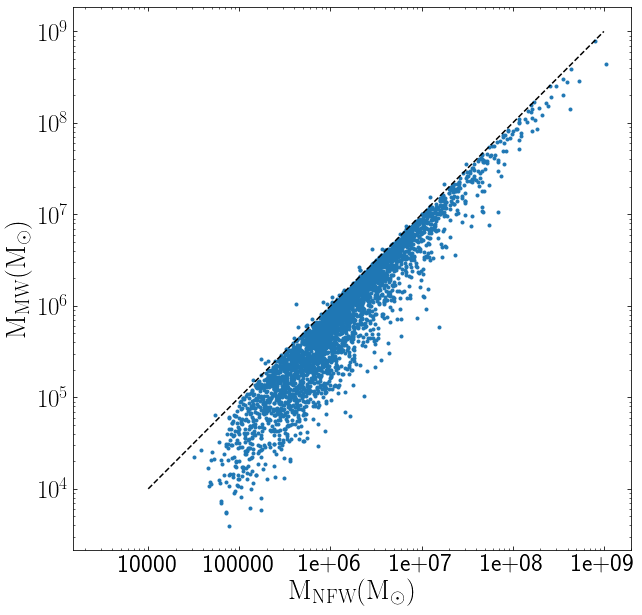

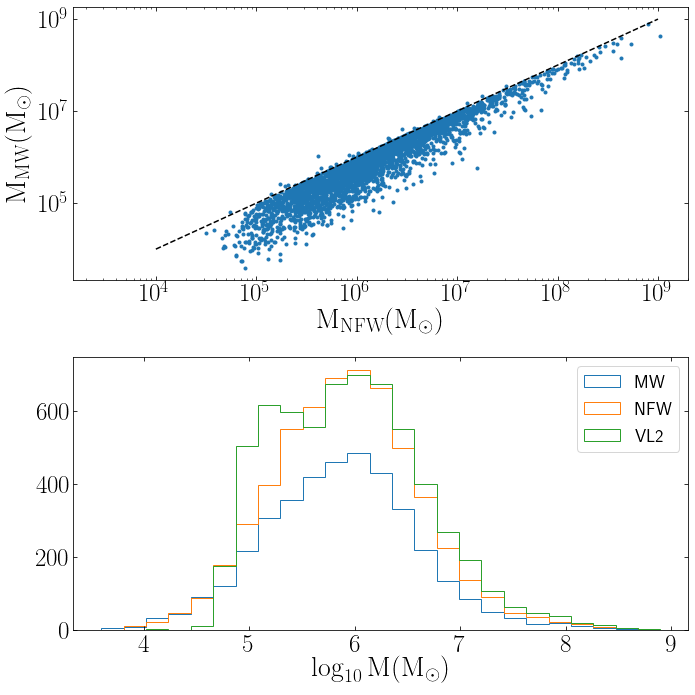

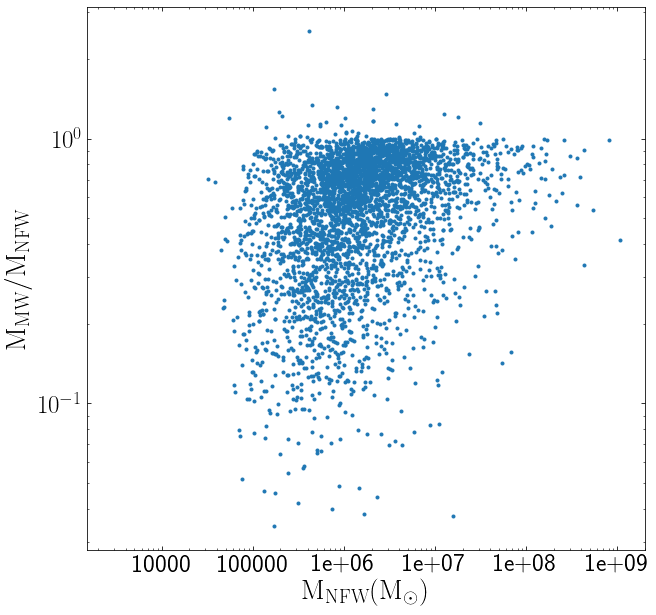

In [31]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.loglog(mi,nfwmz0,'.',label='NFW')
plt.loglog(mi,mwmz0,'.',label='MW')
plt.xlabel(r'$\rm M_i (M_{\odot})$')
plt.ylabel(r'$\rm M (M_{\odot})$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
plt.loglog(nfwmz0,mwmz0,'.')
plt.loglog([1.0e4,1.0e9],[1.0e4,1.0e9],'k--')
plt.xlabel(r'$\rm M_{NFW} (M_{\odot})$')
plt.ylabel(r'$\rm M_{MW} (M_{\odot})$')
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.savefig('via_lactea_deltam.pdf')
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
ax1=plt.subplot(2,1,1)

plt.loglog(nfwmz0,mwmz0,'.')
plt.loglog([1.0e4,1.0e9],[1.0e4,1.0e9],'k--')
plt.xlabel(r'$\rm M_{NFW} (M_{\odot})$')
plt.ylabel(r'$\rm M_{MW} (M_{\odot})$')
#plt.xticks((1.0e4,1.0e5,1.0e6,1.0e7,1.0e8,1.0e9),(4,5,6,7,8,9))
#plt.yticks((1.0e4,1.0e5,1.0e6,1.0e7,1.0e8,1.0e9),(4,5,6,7,8,9))

xlim=plt.gca().get_xlim()

ax1=plt.subplot(2,1,2)

mmin,mmax=xlim

mwindx=(mwmz0>=mmin) * (mwmz0<=mmax)
nfwindx=(nfwmz0>=mmin) *(nfwmz0<=mmax)

mbin=25

nmw,binsmw,patches=plt.hist(np.log10(mwmz0[mwindx]),bins=mbin,histtype='step',label='MW')
nnfw,binsnfw,patches=plt.hist(np.log10(nfwmz0[nfwindx]),bins=binsmw,histtype='step',label='NFW')
nvl2,binsvl2,patches=plt.hist(np.log10(vl2mz0),bins=binsmw,histtype='step',label='VL2')
plt.xlabel(r'$\rm \log_{10} M (M_{\odot})$')

plt.legend(fontsize=18.)
#plt.xticks((1.0e4,1.0e5,1.0e6,1.0e7,1.0e8,1.0e9),(1.0e4,1.0e5,1.0e6,1.0e7,1.0e8,1.0e9))

plt.tight_layout()

plt.savefig('via_lactea_deltam_hist.pdf')
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
plt.loglog(nfwmz0,mrat,'.')
plt.xlabel(r'$\rm M_{NFW} (M_{\odot})$')
plt.ylabel(r'$\rm M_{MW}/M_{NFW}$')
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.savefig('via_lactea_mrat.pdf')
plt.show()
plt.close()

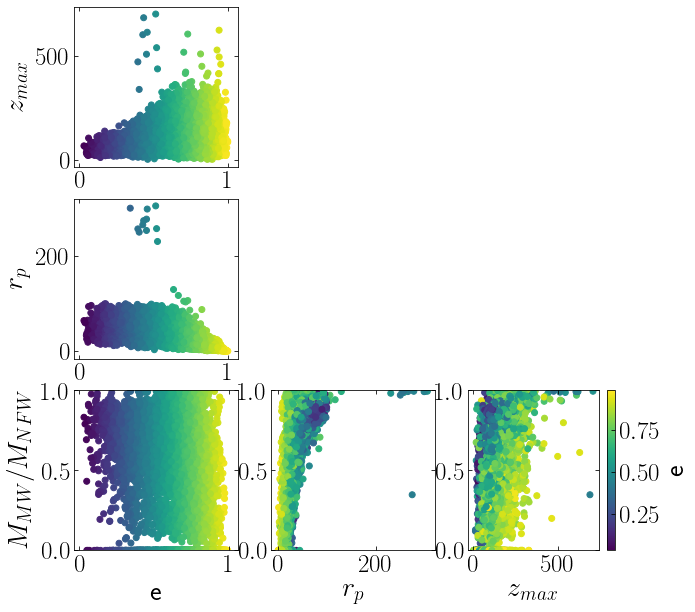

In [32]:
#Plot against orbital parameters from via_lactea
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.subplot(3,3,7)

plt.scatter(ecc,mrat,c=ecc)
plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('e')
plt.ylim(0,1)

plt.subplot(3,3,8)

plt.scatter(rp,mrat,c=ecc)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$r_p$')
plt.ylim(0,1)

plt.subplot(3,3,9)

plt.scatter(zmax,mrat,c=ecc)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$z_{max}$')
cbar=plt.colorbar()
cbar.set_label(r'e')
plt.ylim(0,1)

plt.subplot(3,3,4)
plt.scatter(ecc,rp,c=ecc)
plt.ylabel(r'$r_p$')
#plt.xlabel('e')

plt.subplot(3,3,1)

plt.scatter(ecc,zmax,c=ecc)
plt.ylabel(r'$z_{max}$')
#plt.xlabel('e')

plt.savefig('mrat_orbit.pdf')
plt.show()

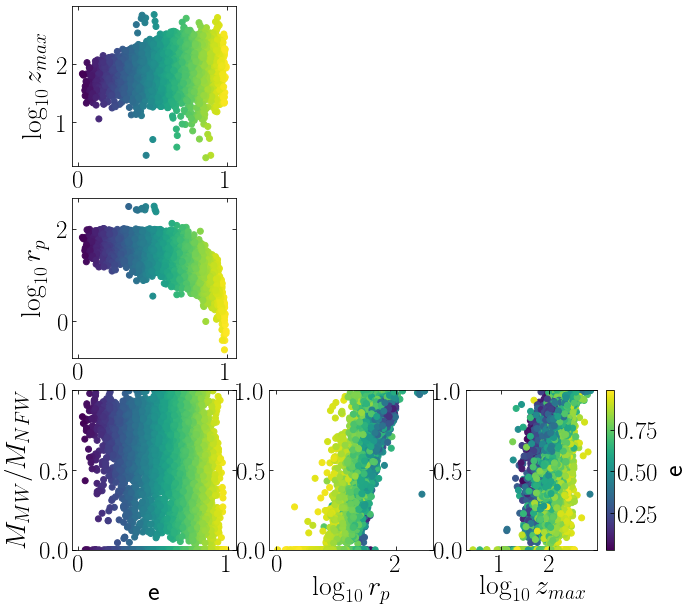

In [33]:
#Plot against orbital parameters from via_lactea
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.subplot(3,3,7)

plt.scatter(ecc,mrat,c=ecc)
plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('e')
plt.ylim(0,1)

plt.subplot(3,3,8)

plt.scatter(np.log10(rp),mrat,c=ecc)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$\log_{10} r_p$')
plt.ylim(0,1)

plt.subplot(3,3,9)

plt.scatter(np.log10(zmax),mrat,c=ecc)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$\log_{10} z_{max}$')
cbar=plt.colorbar()
cbar.set_label(r'e')
plt.ylim(0,1)

plt.subplot(3,3,4)
plt.scatter(ecc,np.log10(rp),c=ecc)
plt.ylabel(r'$\log_{10} r_p$')
#plt.xlabel('e')

plt.subplot(3,3,1)

plt.scatter(ecc,np.log10(zmax),c=ecc)
plt.ylabel(r'$\log_{10} z_{max}$')
#plt.xlabel('e')

plt.savefig('mrat_orbit_log.pdf')
plt.show()

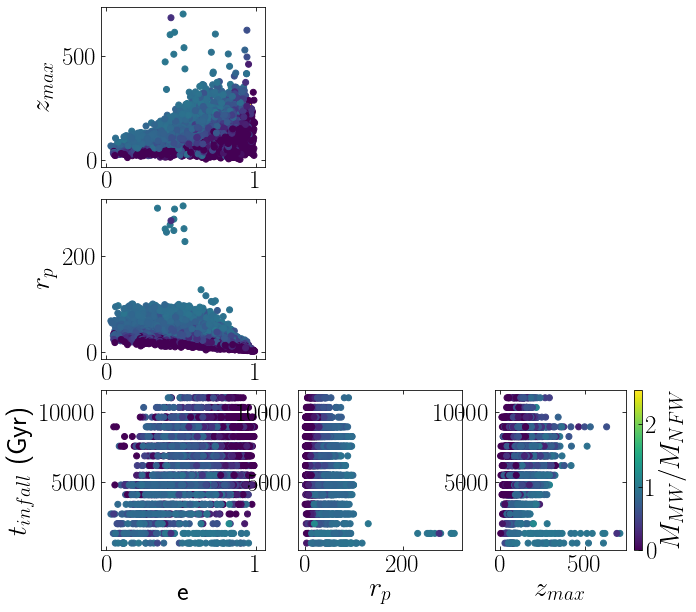

In [34]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

lm0=np.log10(mi)

plt.subplot(3,3,7)

plt.scatter(ecc,tinfall,c=mrat)
plt.ylabel(r'$t_{infall}$ (Gyr)')
plt.xlabel('e')

plt.subplot(3,3,8)

plt.scatter(rp,tinfall,c=mrat)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$r_p$')

plt.subplot(3,3,9)

plt.scatter(zmax,tinfall,c=mrat)
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel('$z_{max}$')
cbar=plt.colorbar()
cbar.set_label(r'$M_{MW}/M_{NFW}$')

plt.subplot(3,3,4)
plt.scatter(ecc,rp,c=mrat)
plt.ylabel(r'$r_p$')
#plt.xlabel('e')

plt.subplot(3,3,1)

plt.scatter(ecc,zmax,c=mrat)
plt.ylabel(r'$z_{max}$')
#plt.xlabel('e')


plt.show()

In [35]:
def get_mfunc(mod,tplot,nfw=False):
    mass=[]
    time=[]

    for i in range(0,len(mod)):
        if nfw:
            tmod=mod[i].exnfwt          
        else:
            tmod=mod[i].exmwt
            
        if tmod[0] > tplot-1000. and tmod[-1] < tplot+1000.:

            tindx=np.argmin(np.fabs(tplot-tmod))
            if mod[i].mwm[tindx] > 0:
                #print(tmod,mod[i].mwm,tindx,mod[i].mwm[tindx])
                if nfw:                    
                    mass.append(np.log10(mod[i].nfwm[tindx]))
                else:
                    mass.append(np.log10(mod[i].mwm[tindx]))
                time.append(tmod[tindx])

    return mass,time
        

In [36]:
mwrvmaxz0=np.array([m.mwrvmax[-1] for m in mod])
mwvmaxz0=np.array([m.mwvmax[-1] for m in mod])
nfwrvmaxz0=np.array([m.nfwrvmax[-1] for m in mod])
nfwvmaxz0=np.array([m.nfwvmax[-1] for m in mod])

vl2mz0=np.array([m.mz0 for m in mod])


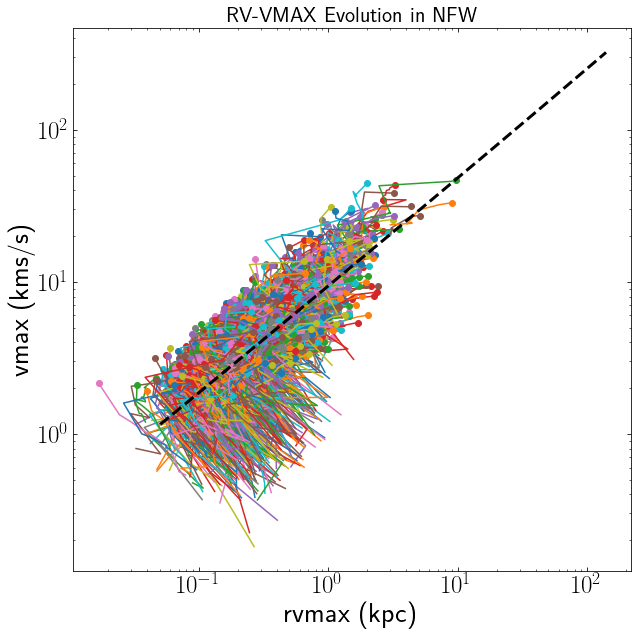

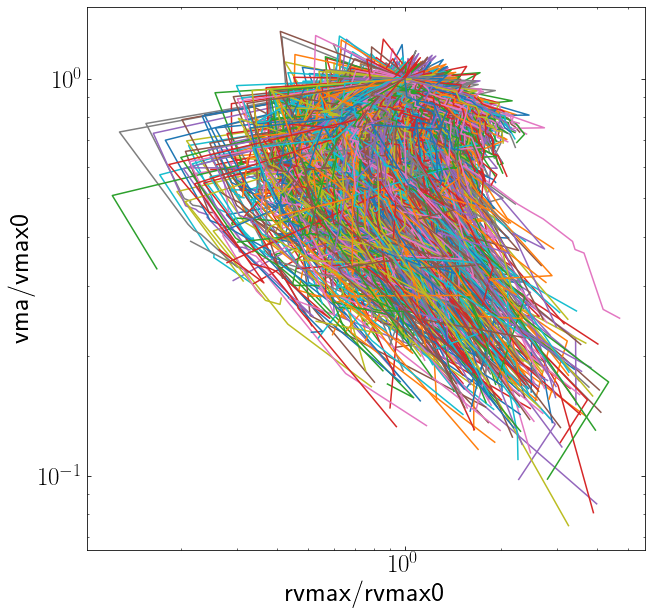

In [37]:

for i in range(0,len(mod)):
    if mod[i].mwrvmax[0] > 0.:
        out=plt.loglog(mod[i].nfwrvmax/1000.0,mod[i].nfwvmax,label=mod[i].label)
        c=out[0].get_color()
        plt.loglog(mod[i].nfwrvmax[0]/1000.0,mod[i].nfwvmax[0],'o',c=c)
            
plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3)
plt.xlabel('rvmax (kpc)')
plt.ylabel('vmax (kms/s)')
plt.title('RV-VMAX Evolution in NFW')

#plt.legend(fontsize=18.)
plt.show()
plt.close()


bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

for i in range(0,len(mod)):
    if mod[i].mwrvmax[0] > 0.:
        plt.loglog(mod[i].nfwrvmax/mod[i].nfwrvmax[0],mod[i].nfwvmax/mod[i].nfwvmax[0],label=mod[i].label)
 
plt.xlabel('rvmax/rvmax0')
plt.ylabel('vma/vmax0')
#plt.legend(fontsize=18.)
plt.show()
plt.close()

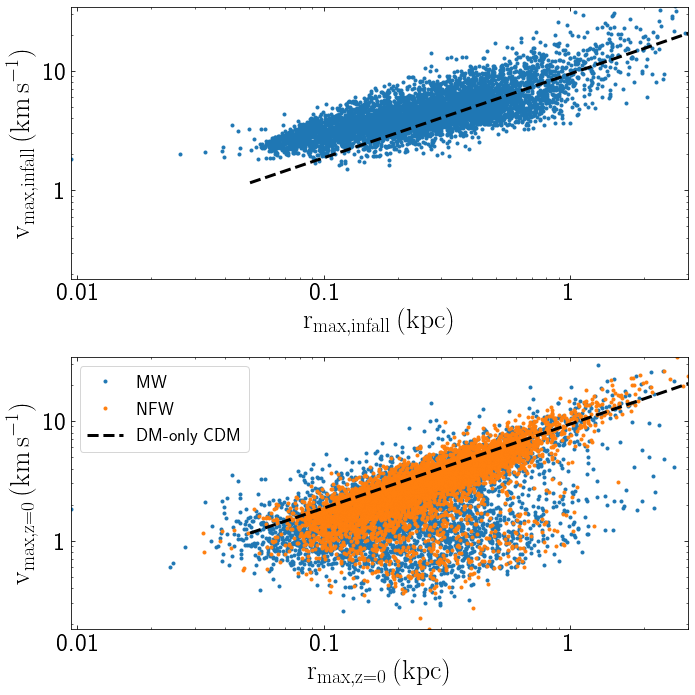

In [38]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)


plt.subplot(2,1,1)
vmax=np.array([m.mwvmax[0] for m in mod])
rvmax=np.array([m.mwrvmax[0] for m in mod])/1000.0
plt.loglog(rvmax,vmax,'.')

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3,label='CDM')
plt.ylabel(r'$\rm v_{max,infall}\,(\rm{km\,s}^{-1})$')    
plt.xlabel(r'$\rm r_{max,infall}\,(\rm{kpc})$')
#plt.legend(fontsize=18.)
#plt.xlim(np.amin(rvmax),np.amax(rvmax))
#plt.ylim(np.amin(vmax),np.amax(vmax))

plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)



plt.subplot(2,1,2)


plt.loglog(mwrvmaxz0/1000.0,mwvmaxz0,'.',label='MW')
plt.loglog(nfwrvmaxz0/1000.0,nfwvmaxz0,'.',label='NFW')

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3,label='DM-only CDM')
plt.ylabel(r'$\rm v_{max,z=0}\,({km\,s}^{-1})$')    
plt.xlabel(r'$\rm r_{max,z=0}\,({kpc})$')


plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

#plt.gca().xaxis.set_major_formatter(LogFormatter())
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,pos: r'$%g$' % x))

#plt.gca().xaxis.set_major_formatter(lambda x,pos: r'$%g$' % x)

plt.legend(fontsize=18.)
plt.tight_layout()
plt.savefig('via_lactea_rvmax.pdf')

plt.show()
plt.close()

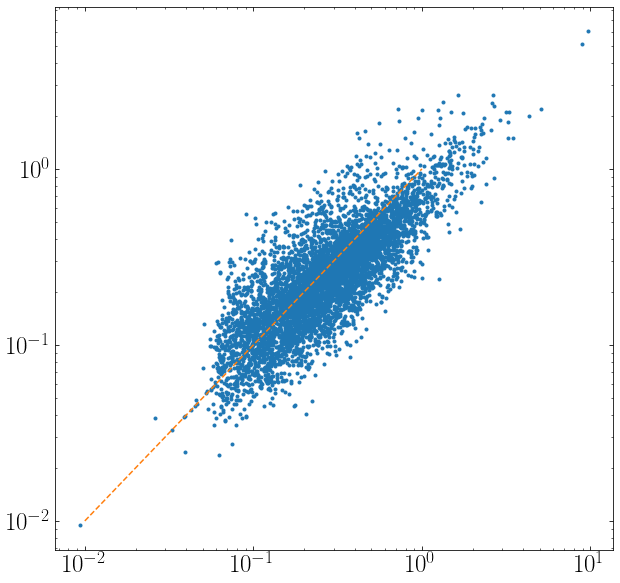

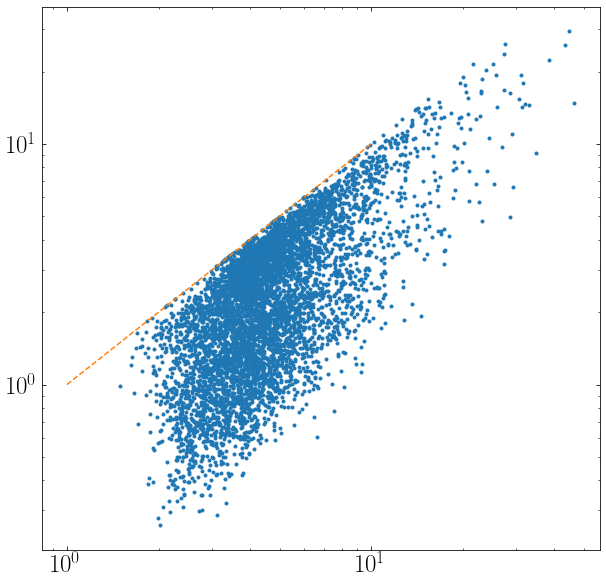

In [39]:
vmax0=np.array([m.mwvmax[0] for m in mod])
rvmax0=np.array([m.mwrvmax[0] for m in mod])/1000.0

plt.loglog(rvmax0,mwrvmaxz0/1000.0,'.')
#plt.loglog(rvmax0,nfwrvmaxz0/1000.0,'.')

plt.loglog([0.01,1],[0.01,1],'--')
plt.show()
plt.close()

plt.loglog(vmax0,mwvmaxz0,'.')
#plt.loglog(vmax0,nfwvmaxz0,'.')

plt.loglog([1,10],[1,10],'--')
plt.show()
plt.close()

In [40]:
#times=np.array([0.,3000.,6000.,9000.])
#times=np.linspace(0.,9000.,10)
times=np.array([0.,2000.,4000.,6000.,8000.])

print(times)

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for i in range(0,len(mod)):
    #print(i,len(mod))
    #if mod[i].mwrvmax[0] > 0.:
    
    tvmax,rvmax,vmax=mod[i].rvmax_interpolate(times)
    t_vmax=np.append(t_vmax,tvmax)
    r_vmax=np.append(r_vmax,rvmax)
    v_vmax=np.append(v_vmax,vmax)

[    0.  2000.  4000.  6000.  8000.]


In [41]:
#times=np.linspace(0.,9000.,10)
times=np.array([0.,2000.,4000.,6000.,8000.])
print(times)

t_vmax_nfw=np.array([])
r_vmax_nfw=np.array([])
v_vmax_nfw=np.array([])


for i in range(0,len(mod)):
    #print(i,len(mod))
    #if mod[i].mwrvmax[0] > 0.:
    
    tvmax,rvmax,vmax=mod[i].rvmax_interpolate(times,gtype='NFW')
    t_vmax_nfw=np.append(t_vmax_nfw,tvmax)
    r_vmax_nfw=np.append(r_vmax_nfw,rvmax)
    v_vmax_nfw=np.append(v_vmax_nfw,vmax)

[    0.  2000.  4000.  6000.  8000.]


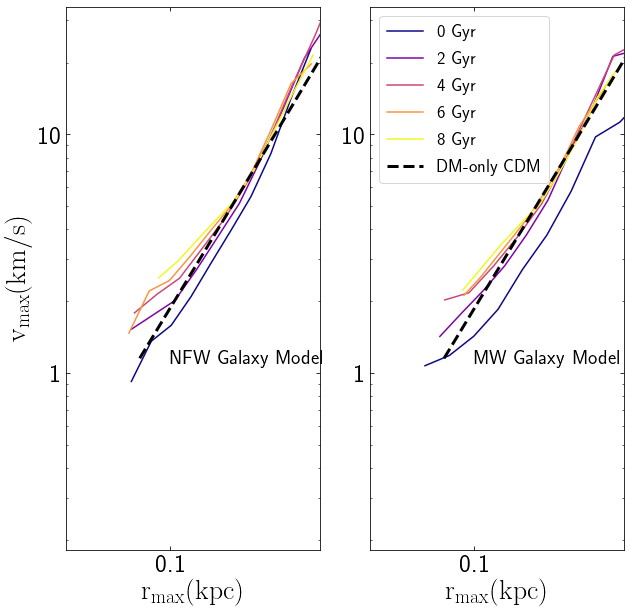

In [42]:

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

ax1=plt.subplot(1,2,2)
#colours = cm(np.linspace(0,1,10))
colours = cm(np.linspace(0,1,5))


for i,t in enumerate(times):
    tindx=(t_vmax==t)
    r_v,v_max,sig=npy.mean_prof(r_vmax[tindx]/1000.0,v_vmax[tindx],bintype='fix',steptype='log')
    tlabel=t/1000.0
    plt.loglog(r_v,v_max,label='%.0f Gyr' % tlabel,c=colours[i])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3,label='DM-only CDM')


plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
plt.legend(fontsize=18.)

plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

plt.text(0.1,1.1,'MW Galaxy Model',fontsize=20)


#plt.xlim(0.001,1)


ax2=plt.subplot(1,2,1,sharex=ax1,sharey=ax1)


for i,t in enumerate(times):
    tindx=(t_vmax_nfw==t)
    r_v,v_max,sig=npy.mean_prof(r_vmax_nfw[tindx]/1000.0,v_vmax_nfw[tindx],bintype='fix',steptype='log')
    tlabel=t/1000.0

    plt.loglog(r_v,v_max,label='%.0f Gyr' % tlabel,c=colours[i])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3)
plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km/s) $')

plt.text(0.1,1.1,'NFW Galaxy Model',fontsize=20)

plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

#plt.xlim(0.01,10)


#plt.tight_layout()

plt.show()
plt.close()

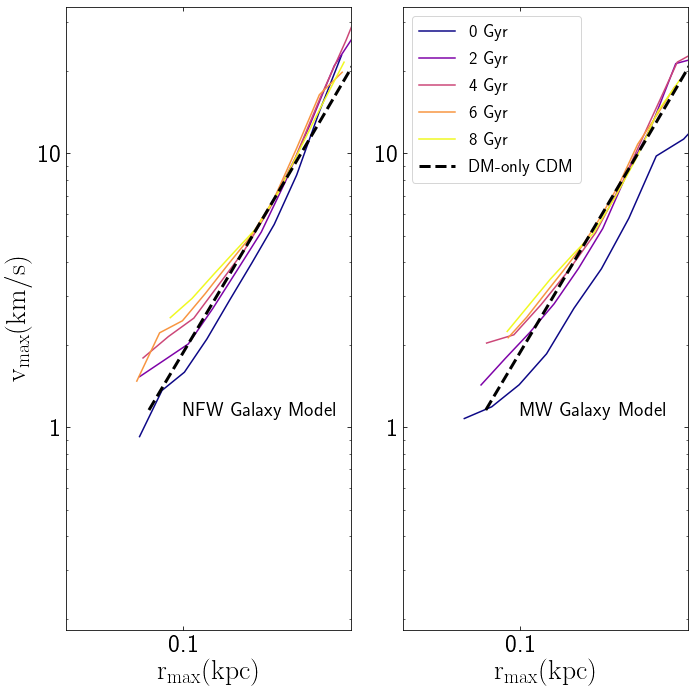

In [43]:


ax1=plt.subplot(1,2,2)
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#colours = cm(np.linspace(0,1,10))
colours = cm(np.linspace(0,1,5))


for i,t in enumerate(times):
    tindx=(t_vmax==t)
    r_v,v_max,sig=npy.mean_prof(r_vmax[tindx]/1000.0,v_vmax[tindx],bintype='fix',steptype='log')
    tlabel=t/1000.0
    plt.loglog(r_v,v_max,label='%.0f Gyr' % tlabel,c=colours[i])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3,label='DM-only CDM')
plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
plt.legend(fontsize=18.)

plt.text(0.1,1.1,'MW Galaxy Model',fontsize=20)
plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

plt.ylim(1,30)
plt.xlim(0.01,10)

ax2=plt.subplot(1,2,1,sharex=ax1,sharey=ax1)
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)


for i,t in enumerate(times):
    tindx=(t_vmax_nfw==t)
    r_v,v_max,sig=npy.mean_prof(r_vmax_nfw[tindx]/1000.0,v_vmax_nfw[tindx],bintype='fix',steptype='log')
    tlabel=t/1000.0

    plt.loglog(r_v,v_max,label='%.0f Gyr' % tlabel,c=colours[i])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=3)
plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km/s) $')

plt.text(0.1,1.1,'NFW Galaxy Model',fontsize=20)

#plt.xlim(0.01,10)
plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

plt.tight_layout()

plt.savefig('via_lactea_rvmax_evol.pdf')

plt.show()
plt.close()

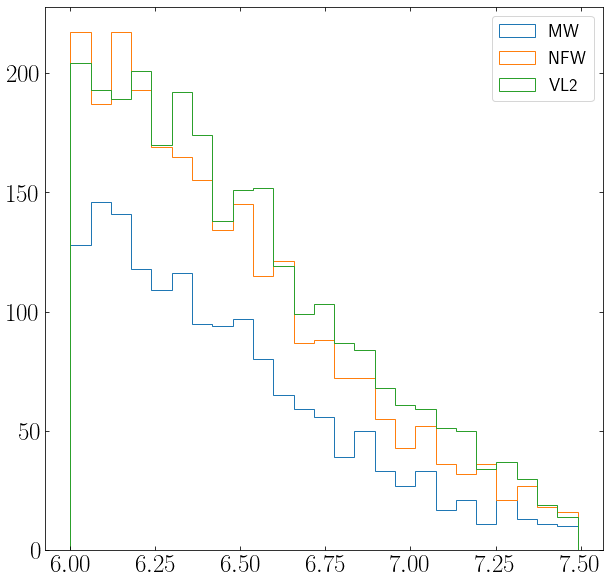

In [44]:
mmin=1.0e6
mmax=10.0**(7.5)

mwindx=(mwmz0>=mmin) * (mwmz0<=mmax)
nfwindx=(nfwmz0>=mmin) *(nfwmz0<=mmax)

mbin=25

nmw,binsmw,patches=plt.hist(np.log10(mwmz0[mwindx]),bins=mbin,histtype='step',label='MW')
nnfw,binsnfw,patches=plt.hist(np.log10(nfwmz0[nfwindx]),bins=binsmw,histtype='step',label='NFW')
nvl2,binsvl2,patches=plt.hist(np.log10(vl2mz0),bins=binsmw,histtype='step',label='VL2')
plt.legend(fontsize=18.)
plt.show()
plt.close()

#Viri

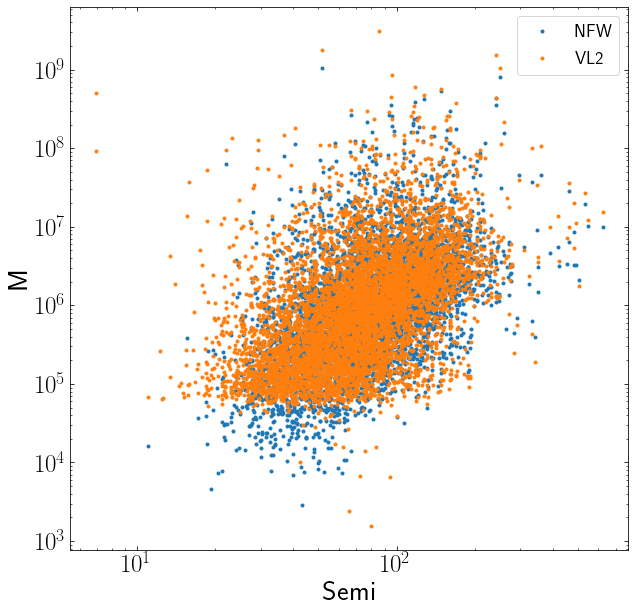

520

In [45]:
plt.loglog(nfwsemi,nfwmz0,'.',label='NFW')
plt.loglog(nfwsemi,vl2mz0,'.',label='VL2')
plt.legend(fontsize=18.)
plt.xlabel('Semi')
plt.ylabel('M')
plt.show()
plt.close()

np.sum(nfwmz0==0)

In [46]:
print(np.sum(mwindx),np.sum(nfwindx),len(mod))
print(np.sum(mwindx)/np.sum(nfwindx),np.sum(mwindx)/len(mod))
print(nmw)
print(nnfw)
print(nmw/nnfw)
print(np.cumsum(nmw),np.cumsum(nnfw))

1590 2477 6236
0.641905530884 0.254971135343
[ 128.  146.  141.  118.  109.  116.   95.   94.   97.   80.   65.   59.
   56.   39.   50.   33.   27.   33.   17.   21.   11.   21.   13.   11.
   10.]
[ 217.  187.  217.  193.  169.  165.  155.  134.  145.  115.  121.   87.
   88.   72.   72.   55.   43.   52.   36.   32.   36.   21.   27.   18.
   16.]
[ 0.58986175  0.78074866  0.64976959  0.61139896  0.64497041  0.7030303
  0.61290323  0.70149254  0.66896552  0.69565217  0.53719008  0.67816092
  0.63636364  0.54166667  0.69444444  0.6         0.62790698  0.63461538
  0.47222222  0.65625     0.30555556  1.          0.48148148  0.61111111
  0.625     ]
[  128.   274.   415.   533.   642.   758.   853.   947.  1044.  1124.
  1189.  1248.  1304.  1343.  1393.  1426.  1453.  1486.  1503.  1524.
  1535.  1556.  1569.  1580.  1590.] [  217.   404.   621.   814.   983.  1148.  1303.  1437.  1582.  1697.
  1818.  1905.  1993.  2065.  2137.  2192.  2235.  2287.  2323.  2355.
  2391.  2412.  2439.

0.645560344773


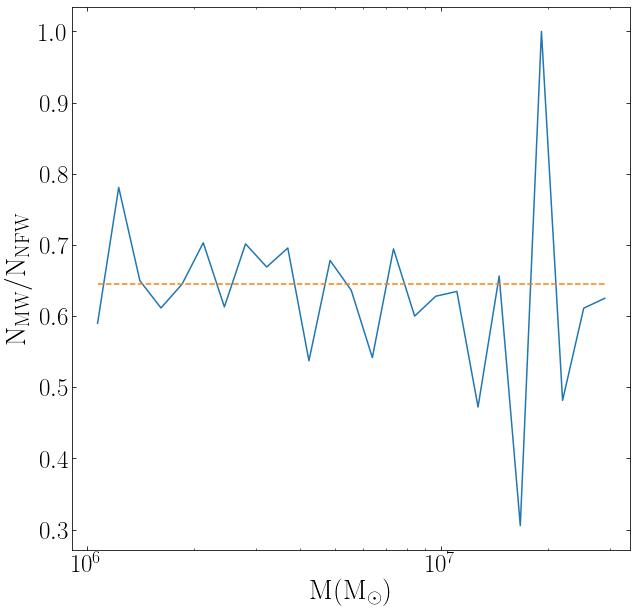

In [47]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)


binmed=(binsmw[0:-1]+binsmw[1:])/2.
bindx=(nmw/nnfw) > 0
xbin=10.0**binmed
#plt.plot(binmed[bindx],nmw[bindx]/nnfw[bindx])
plt.plot(xbin[bindx],nmw[bindx]/nnfw[bindx])
#plt.plot(binmed[bindx],nmw[bindx]/nnfw[bindx],'.')

bindx=(binmed>=6.) * (binmed<=7.)
nmean=np.mean(nmw[bindx*bindx]/nnfw[bindx*bindx])
print(nmean)
plt.semilogx(xbin,np.ones(len(binmed))*nmean,'--')

#plt.gca().xaxis.set_major_formatter(major_formatter)


plt.xlabel(r'$\rm M (M_{\odot})$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.savefig('nrat.pdf')

In [48]:
np.mean(nmw[bindx]/nnfw[bindx])

0.64556034477336988

[ 128.  146.  141.  118.  109.  116.   95.   94.   97.   80.   65.   59.
   56.   39.   50.   33.   27.   33.   17.   21.   11.   21.   13.   11.
    9.]
[ 217.  187.  217.  193.  169.  165.  155.  134.  145.  115.  121.   87.
   88.   72.   72.   55.   43.   52.   36.   32.   36.   21.   27.   18.
   16.]


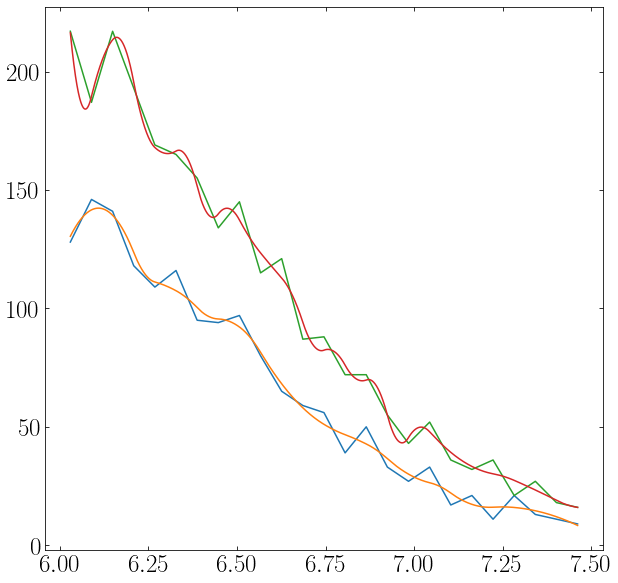

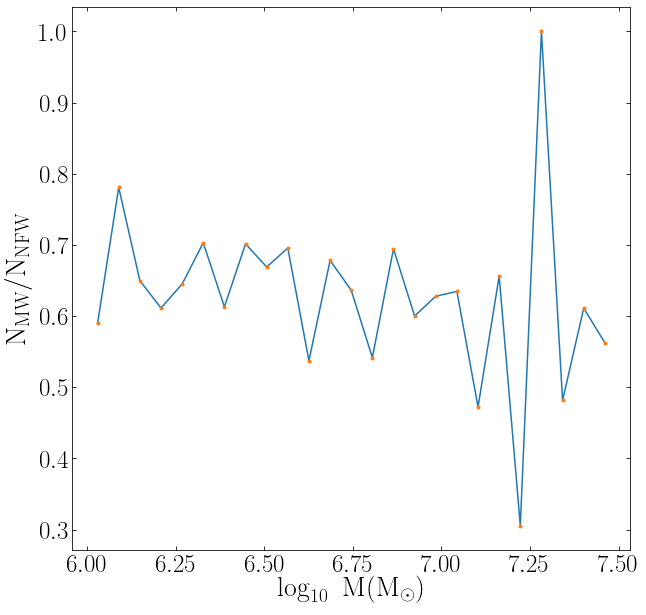

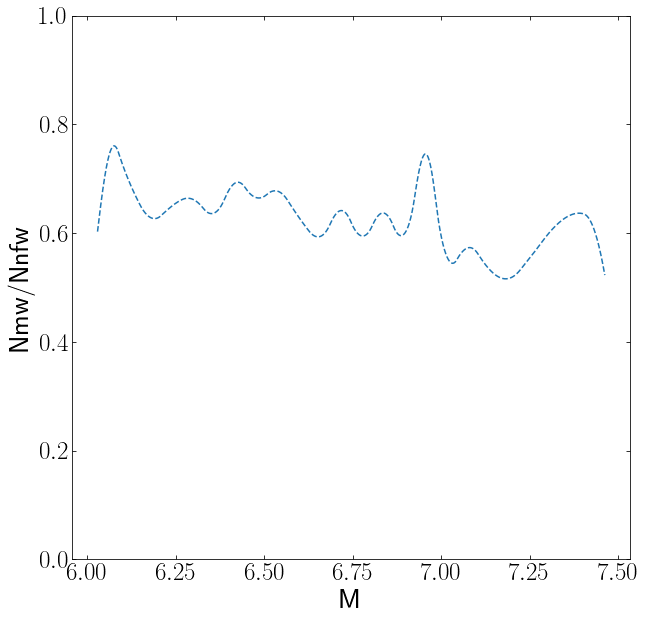

In [49]:
x_lower, x_mid, x_upper, x_hist=npy.binmaker(np.log10(mwmz0[mwindx]),nbin=25)

mw_mean, mw_hist=npy.x_hist(np.log10(mwmz0[mwindx]),x_lower=x_lower,x_mean=x_mid,x_upper=x_upper)
nfw_mean, nfw_hist=npy.x_hist(np.log10(nfwmz0[nfwindx]),x_lower=x_lower,x_mean=x_mid,x_upper=x_upper)

print(mw_hist)
print(nfw_hist)

plt.plot(mw_mean,mw_hist)
splmw=interpolate.UnivariateSpline(mw_mean,mw_hist,k=2,s=500) #PL AY W S?
xnew=np.linspace(mw_mean[0],mw_mean[-1],1000.*len(mw_mean))
plt.plot(xnew,splmw(xnew))


plt.plot(nfw_mean,nfw_hist)
splnfw=interpolate.UnivariateSpline(nfw_mean,nfw_hist,k=2,s=500) #PL AY W S?
plt.plot(xnew,splnfw(xnew))

plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(mw_mean,mw_hist/nfw_hist)
plt.plot(mw_mean,mw_hist/nfw_hist,'.')
#plt.plot(xnew,splmw(xnew)/splnfw(xnew),'--')
plt.xlabel(r'$\rm \log_{10} \ M (M_{\odot})$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.savefig('nrat_num.pdf')
plt.show()
plt.close()

plt.plot(xnew,splmw(xnew)/splnfw(xnew),'--')
plt.xlabel('M')
plt.ylabel('Nmw/Nnfw')
plt.ylim(0,1)
plt.savefig('nrat_num_smooth.pdf')
plt.show()
plt.close()



In [50]:
#ratio as a function of radius, compare to things like GD1 etc
#evolution of c compared to CDM, binned in radius? 

In [51]:
#Growing potential?
#--> Re-do handfull of simulations (slower?)
#Implement growing disk

In [52]:
mwrphalo=np.array([m.mwrp for m in mod])
nfwrphalo=np.array([m.nfwrp for m in mod])

mwrhalo=np.array([m.mwrgcz0/1000. for m in mod])
nfwrhalo=np.array([m.nfwrgcz0/1000. for m in mod])

mwecc=np.array([m.mwecc for m in mod])
nfwecc=np.array([m.nfwecc for m in mod])

(array([  4.19900000e+03,   1.62000000e+03,   3.69000000e+02,
          3.60000000e+01,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          4.00000000e+00]),
 array([  2.37871102e-01,   3.07354437e+01,   6.12330162e+01,
          9.17305888e+01,   1.22228161e+02,   1.52725734e+02,
          1.83223306e+02,   2.13720879e+02,   2.44218452e+02,
          2.74716024e+02,   3.05213597e+02]),
 <a list of 1 Patch objects>)

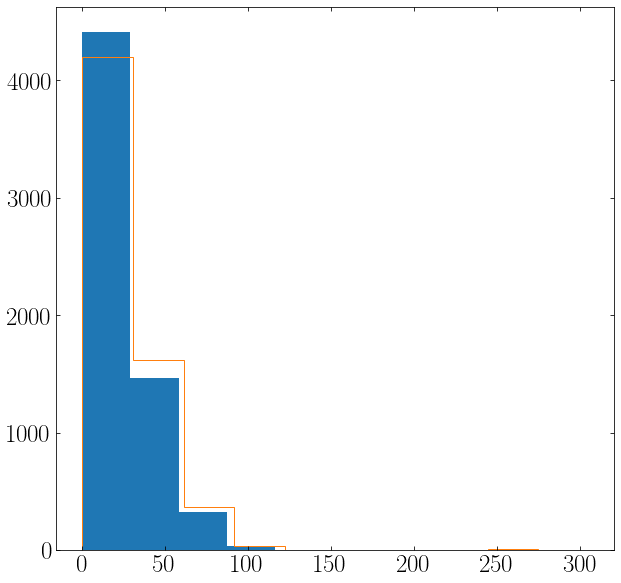

In [53]:
plt.hist(mwrphalo)
plt.hist(nfwrphalo,histtype='step')

In [54]:
nrbin=3
msmin=10.0**(6.)
msmax=10.0**(7.5)

mwmindx=(mwmz0>msmin) * (mwmz0<msmax)
nfwmwindx=(nfwmz0>msmin) * (nfwmz0<msmax)

#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrphalo[nfwindx*nfwmwindx*(nfwrphalo<100)],nrbin)
print(x_lower)
print(x_upper)

mbin=np.array([6.,6.2,6.4,6.6,6.8,7.,7.25,7.5])
lmbin=mbin
print(mbin,lmbin)

[ 6.00009821  6.05974387  6.11938954  6.1790352   6.23868086  6.29832652
  6.35797219  6.41761785  6.47726351  6.53690918  6.59655484  6.6562005
  6.71584616  6.77549183  6.83513749  6.89478315  6.95442881  7.01407448
  7.07372014  7.1333658   7.19301147  7.25265713  7.31230279  7.37194845
  7.43159412]
[ 6.05974387  6.11938954  6.1790352   6.23868086  6.29832652  6.35797219
  6.41761785  6.47726351  6.53690918  6.59655484  6.6562005   6.71584616
  6.77549183  6.83513749  6.89478315  6.95442881  7.01407448  7.07372014
  7.1333658   7.19301147  7.25265713  7.31230279  7.37194845  7.43159412
  7.49123978]
[ 6.    6.2   6.4   6.6   6.8   7.    7.25  7.5 ] [ 6.    6.2   6.4   6.6   6.8   7.    7.25  7.5 ]


[  2.3327356   21.78846016  34.00858349  50.08539265]
[ 21.75981575  34.00466275  50.04368313  99.92475773]


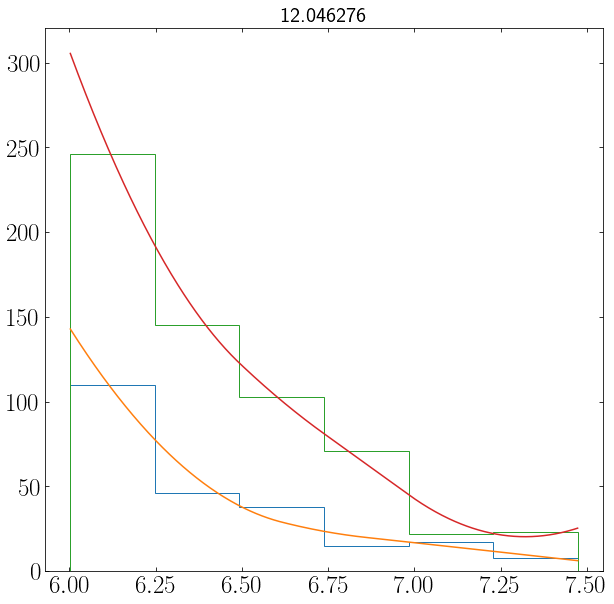

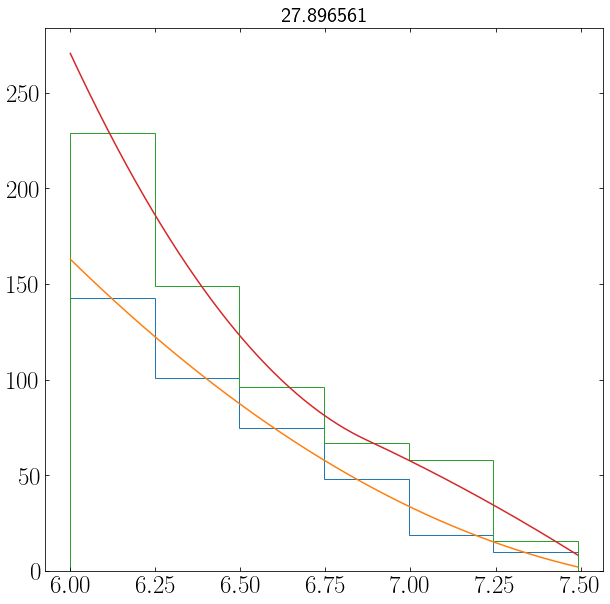

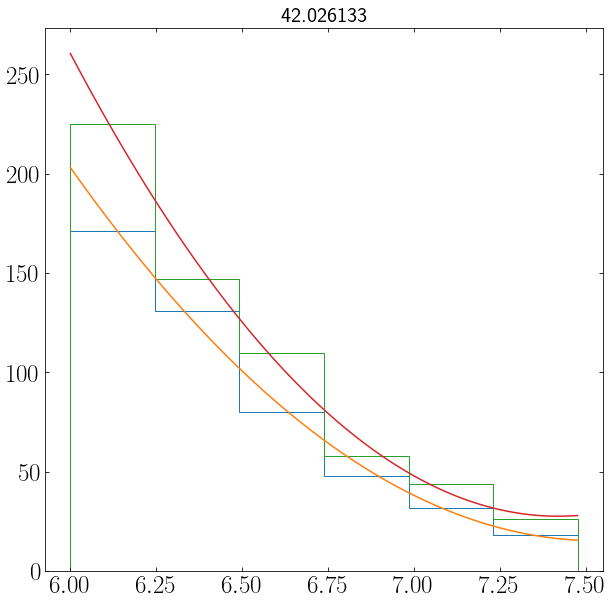

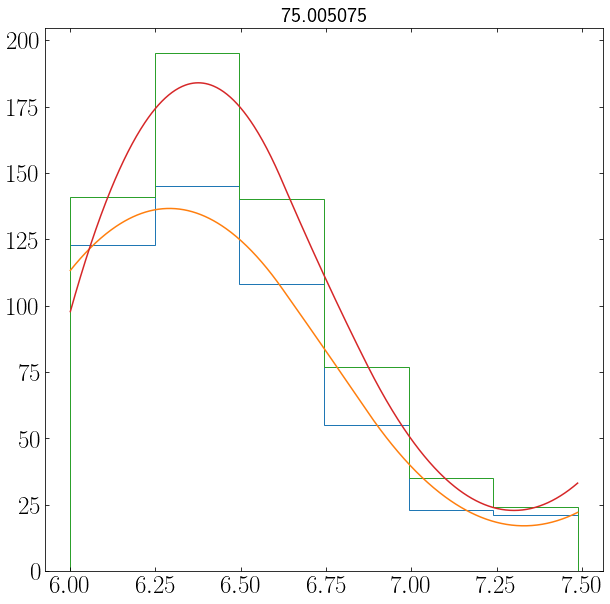

In [124]:
nrbin=4

#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrphalo[mwindx],nfwrphalo[nfwindx]),nrbin)
x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrphalo[nfwindx*nfwmwindx*(nfwrphalo<100)],nrbin)
print(x_lower)
print(x_upper)
#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(mwrphalo[mwmindx*nfwmwindx*(mwrphalo<100)],nrbin)

#x_lower=np.array([0.,20.,40])
#x_upper=np.array([20.,40.,100.])

#x_lower=np.array([0.,15.,30.,50.,75.])
#x_upper=np.array([15.,30.,50.,75.,100.])

#x_mid=(x_lower+x_upper)/2.0
#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrphalo[nfwindx],nrbin)

#x_lower=np.array([1.49560076,15.79123054,21.38969672,25.97976768,31.08169663,36.18339108,41.67311591,48.8734083,57.61524301,69.73795567])
#x_upper=np.array([15.79123054,21.38969672,25.97976768,31.08169663,36.18339108,41.67311591,48.8734083,57.61524301,69.73795567,300.4379059])

#x_lower=np.array([1.49560076,21.38969672,31.08169663,41.67311591,70.])
#x_upper=np.array([21.38969672,31.08169663,41.67311591,70.,300.4379059])

#x_lower=np.array([1.5,20,40,70.])
#x_upper=np.array([20,40,70.,100.])

x_mid=(x_lower+x_upper)/2.0

nrat=[]
n_bins=[]

nrat_smooth=[]
n_bins_smooth=[]

for i in range(0,nrbin):

    indx=mwindx * (mwrphalo >= x_lower[i]) * (mwrphalo < x_upper[i]) * (mwmz0>=msmin) * (mwmz0<=msmax)
    nmw,binsmw,patches=plt.hist(np.log10(mwmz0[indx]),bins=6,histtype='step')
    
    midmw_mid=(binsmw[0:-1]+binsmw[1:])/2.
    splmw=interpolate.UnivariateSpline(midmw_mid,nmw,k=2,s=200) #PL AY W S?
    xnew=np.linspace(binsmw[0],binsmw[-1],100.*len(midmw_mid))
    plt.plot(xnew,splmw(xnew))
    
    
    indx=nfwindx * (nfwrphalo >= x_lower[i]) * (nfwrphalo < x_upper[i]) * (nfwmz0>=msmin) * (nfwmz0<=msmax)
    nnfw,binsnfw,patches=plt.hist(np.log10(nfwmz0[indx]),bins=binsmw,histtype='step')

    splnfw=interpolate.UnivariateSpline(midmw_mid,nnfw,k=2,s=200)
    xnew=np.linspace(binsmw[0],binsmw[-1],100.*len(midmw_mid))
    plt.plot(xnew,splnfw(xnew))
    
    nrat.append(nmw/nnfw)
    n_bins.append(midmw_mid)
    nrat_smooth.append(splmw(xnew)/splnfw(xnew))
    n_bins_smooth.append(xnew)
    
    
    plt.title('%f' % x_mid[i])
    plt.show()
    plt.close()
    

In [125]:
print(x_lower,x_mid,x_upper)

[  2.3327356   21.78846016  34.00858349  50.08539265] [ 12.04627568  27.89656146  42.02613331  75.00507519] [ 21.75981575  34.00466275  50.04368313  99.92475773]


[0.33614887383095365]
[0.33614887383095365, 0.6999936019781664]
[0.33614887383095365, 0.6999936019781664, 0.8015038491885782]
[0.33614887383095365, 0.6999936019781664, 0.8015038491885782, 0.77541111370898608]


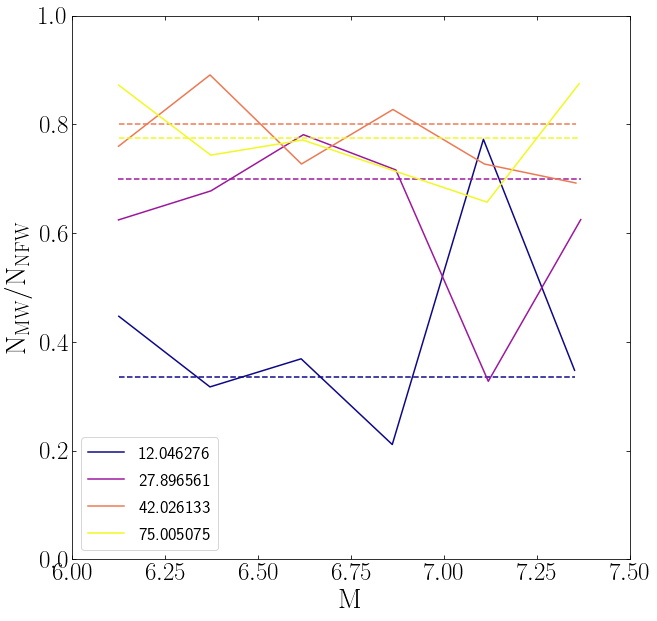

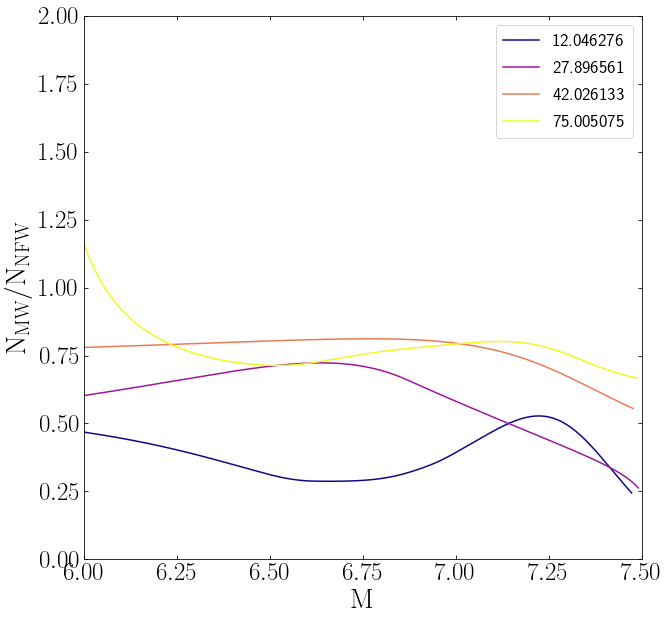

In [57]:
colours = cm(np.linspace(0,1,nrbin))
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

nmean_rp=[]

for i in range(0,len(nrat)):
    out=plt.plot(n_bins[i],nrat[i],label='%f' % (x_mid[i]),c=colours[i])
    c=out[0].get_color()
    bindx=(n_bins[i]>=6.) * (n_bins[i]<=7.)
    nmean_rp.append(np.mean(nrat[i][bindx]))
    print(nmean_rp)
    plt.plot(n_bins[i],np.ones(len(n_bins[i]))*nmean_rp[-1],c=c,linestyle='--')
    
plt.xlim(6,7.5)
plt.legend(fontsize=18.)
plt.xlabel(r'$\rm M$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.ylim(0,1)
plt.savefig('nrat_rp.pdf')
plt.show()
plt.close()

n_bins_rp=n_bins
nrat_rp=nrat

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

for i in range(0,len(nrat)):
    out=plt.plot(n_bins_smooth[i],nrat_smooth[i],label='%f' % (x_mid[i]),c=colours[i])   
    
    
plt.xlim(6,7.5)
plt.legend(fontsize=18.)
plt.xlabel(r'$\rm M$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.ylim(0,2)
plt.savefig('nrat_rp_smooth.pdf')
plt.show()
plt.close()

#STop at 7.5. Maybe Poisson noise?

In [58]:
np.mean(nrat_smooth[0])

0.38325497389112523

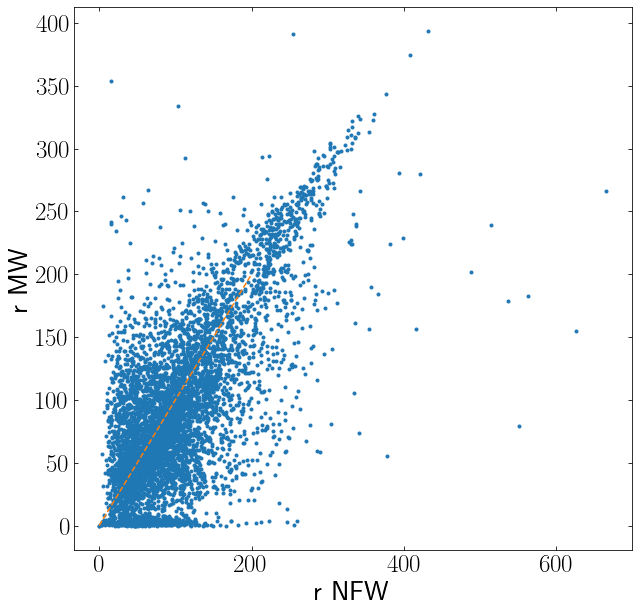

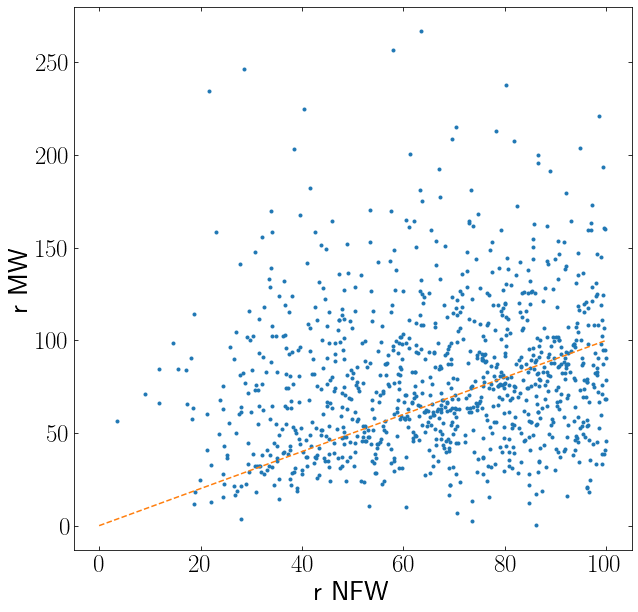

NFW:  1023 2477 3665
MW:  657 1590 3933


In [59]:
plt.plot(nfwrhalo,mwrhalo,'.')
plt.plot([0,200],[0,200],'--')
plt.xlabel('r NFW')
plt.ylabel('r MW')

plt.show()
plt.close()

plt.plot(nfwrhalo[nfwindx*nfwmwindx*(nfwrhalo<100)],mwrhalo[nfwindx*nfwmwindx*(nfwrhalo<100)],'.')
plt.plot([0,100],[0,100],'--')
plt.xlabel('r NFW')
plt.ylabel('r MW')
plt.show()
plt.close()

print('NFW: ',np.sum(nfwindx*nfwmwindx*(nfwrhalo<100)),np.sum(nfwindx*nfwmwindx),np.sum(nfwrhalo<100))
print('MW: ',np.sum(mwindx*mwmindx*(mwrhalo<100)),np.sum(mwindx*mwmindx),np.sum(mwrhalo<100))

In [126]:
#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrhalo[nfwindx*(nfwrhalo<100)],nrbin)
#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrhalo[nfwindx*nfwmwindx*(nfwrhalo<100)],nrbin)
x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrhalo[nfwindx*(nfwrhalo<100)],nrbin)

print(x_lower,x_upper)

[  3.58744952  48.76596688  68.41294055  84.63126718] [ 48.68225772  68.29405063  84.62035441  99.98130726]


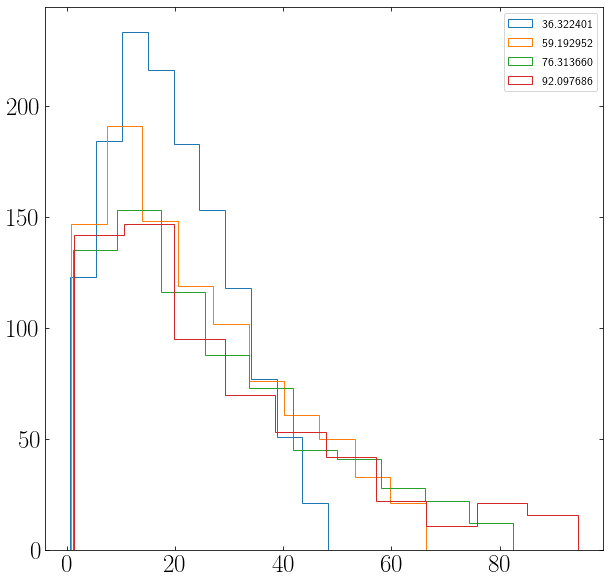

In [61]:
for i in range(0,nrbin):
    tindx=(nfwrhalo>x_lower[i])*(nfwrhalo<x_upper[i])
    plt.hist(nfwrphalo[tindx],histtype='step',label='%f' % x_mid[i])

plt.legend()
plt.show()
plt.close()

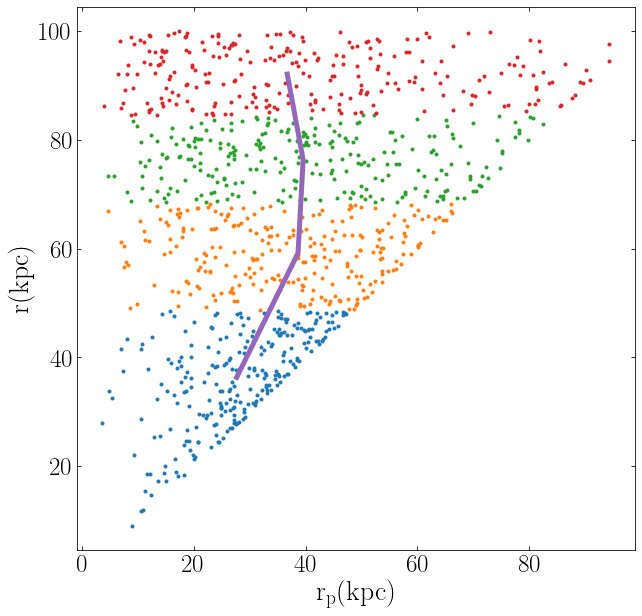

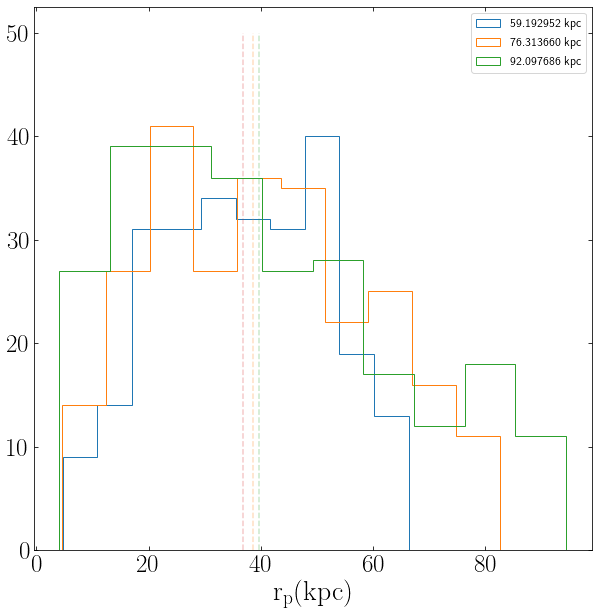

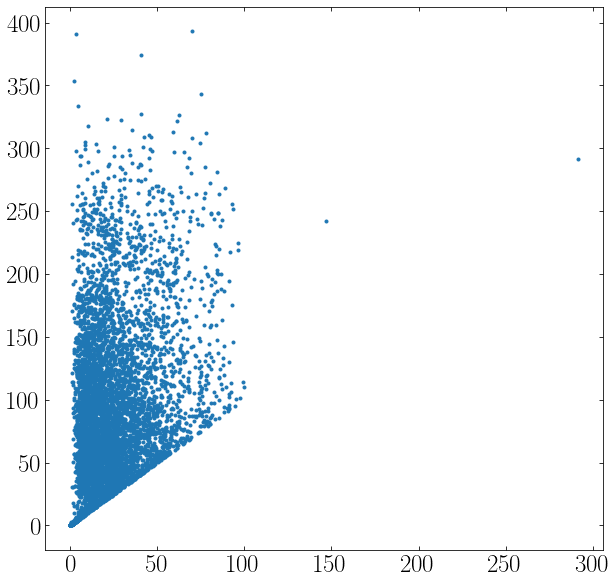

In [62]:
meanrp=[]
crad=[]

for i in range(0,nrbin):
    tindx=(nfwrhalo>x_lower[i])*(nfwrhalo<x_upper[i])
    #plt.plot(nfwrphalo[tindx],nfwrhalo[tindx],'.')
    out=plt.plot(nfwrphalo[tindx*nfwindx],nfwrhalo[tindx*nfwindx],'.')
    crad.append(out[0].get_color())
    meanrp.append(np.median(nfwrphalo[tindx*nfwindx]))

plt.plot(meanrp,x_mid,linewidth=5)
plt.xlabel(r'$\rm r_p (kpc)$')
plt.ylabel(r'$\rm r (kpc)$')
plt.savefig('rplot.pdf')
plt.show()
plt.close()


for i in range(0,nrbin):
    tindx=(nfwrhalo>x_lower[i])*(nfwrhalo<x_upper[i])
    #plt.plot(nfwrphalo[tindx],nfwrhalo[tindx],'.')
    if i>=nrbin-3:
        plt.hist(nfwrphalo[tindx*nfwindx],histtype='step',label='%f kpc' % x_mid[i])
        plt.plot([meanrp[i],meanrp[i]],[0,50],c=crad[i],linestyle='--',alpha=0.25)
    
plt.legend()
plt.xlabel(r'$\rm r_p (kpc)$')
plt.savefig('rp_hist.pdf')
plt.show()
plt.close()

plt.plot(mwrphalo,mwrhalo,'.')
plt.show()
plt.close()



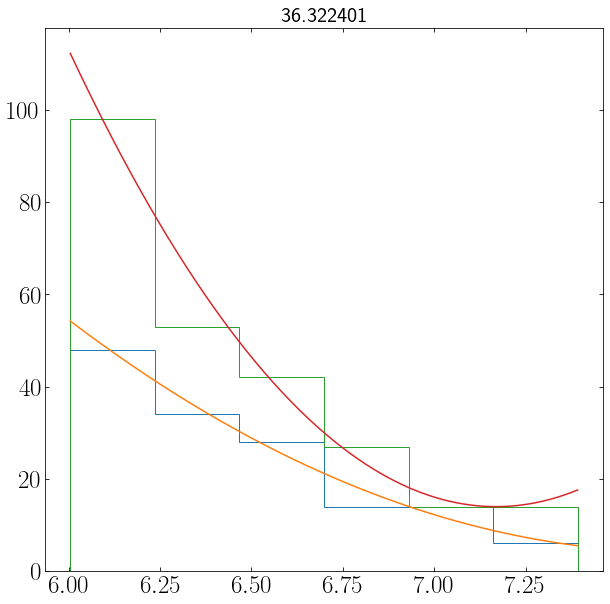

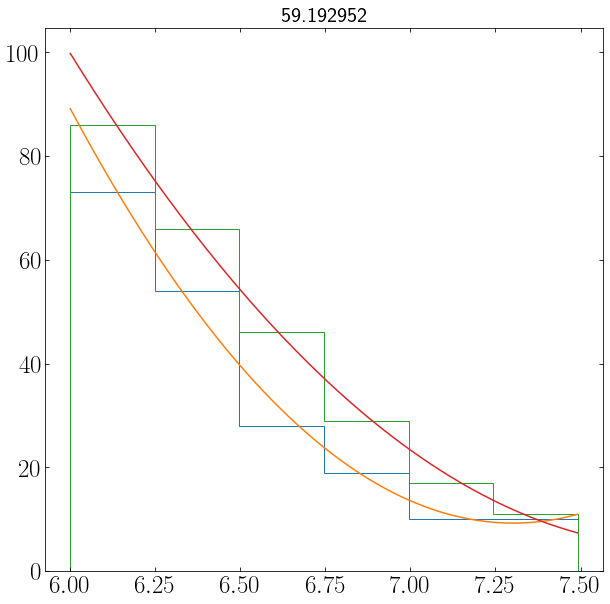

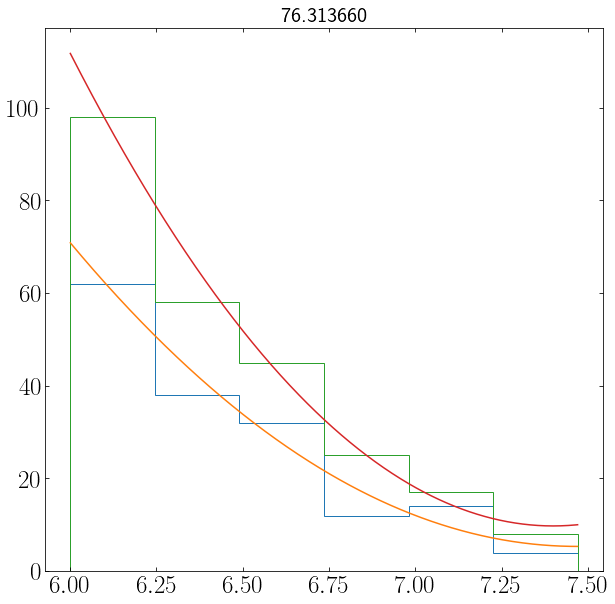

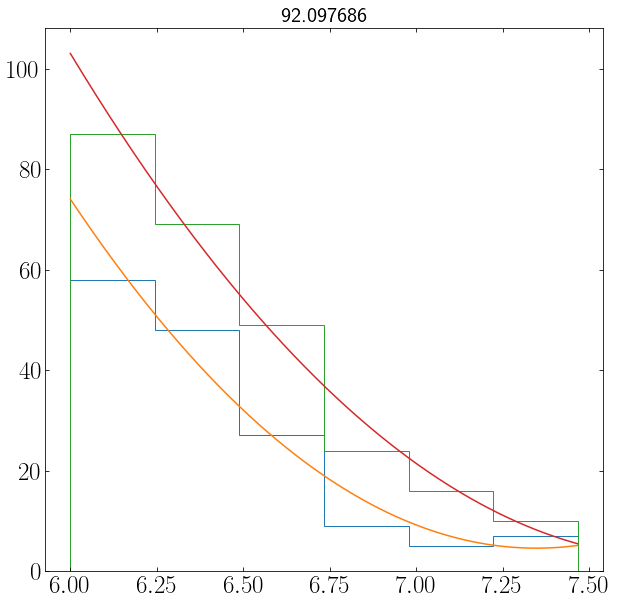

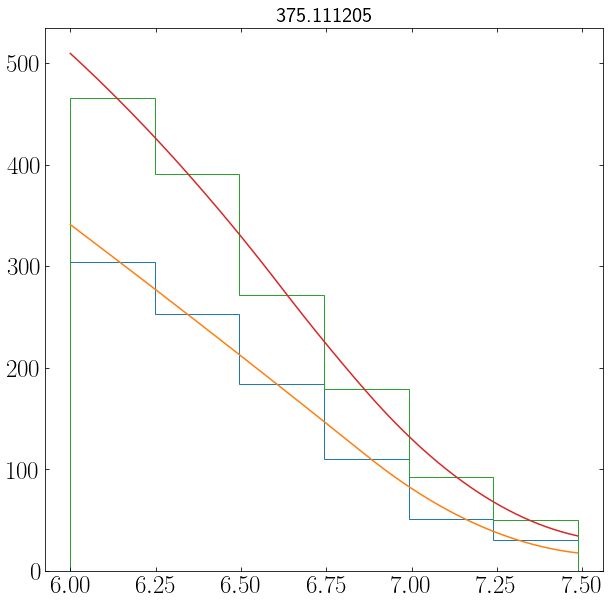

0.579122634379
0.732721773363
0.619734146532
0.572084812186
0.647954498072


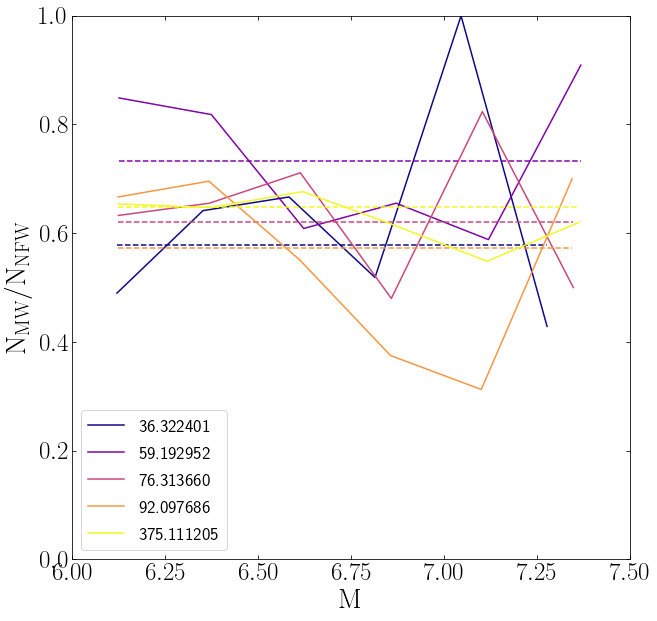

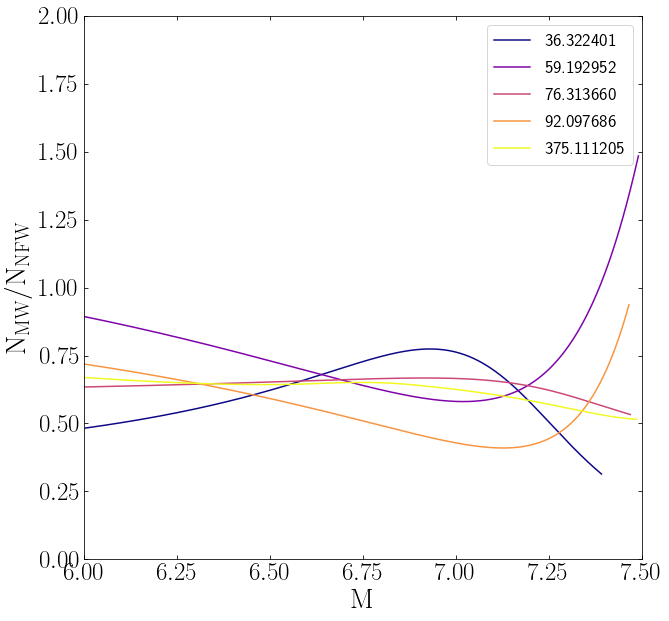

In [63]:
#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrhalo[mwindx],nfwrhalo[nfwindx]),nrbin)
#x_lower=np.array([0.,45.,70])
#x_upper=np.array([45.,70.,100.])
#x_mid=(x_lower+x_upper)/2.0

#x_lower=np.array([3.5,40.,60.,75.])
#x_upper=np.array([40.,60.,75.,100.])
#x_mid=(x_lower+x_upper)/2.0

nrbin=4

x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrhalo[nfwindx*nfwmwindx*(nfwrhalo<100)],nrbin)


x_lower=np.append(x_lower,x_upper[-1])
x_upper=np.append(x_upper,np.amax(nfwrhalo))
x_mid=np.append(x_mid,(x_lower[i]+x_upper[-1])/2.)
nrbin+=1

#nrbin=4
#x_lower=[3.58744952,47.85955509,66.24357342,83.02850244]
#x_mid=[35.30546308,57.00485473,74.49617985,90.96529571]
#x_upper=[47.8475006,66.10129738,82.81056369,99.98130726]

#x_mid=(x_lower+x_upper)/2.0

nrat=[]
n_bins=[]

nrat_smooth=[]
n_bins_smooth=[]

for i in range(0,nrbin):

    indx=mwindx * (mwrhalo >= x_lower[i]) * (mwrhalo < x_upper[i]) * (mwmz0>=msmin) * (mwmz0<=msmax)
    nmw,binsmw,patches=plt.hist(np.log10(mwmz0[indx]),bins=6,histtype='step')
    
    midmw_mid=(binsmw[0:-1]+binsmw[1:])/2.
    splmw=interpolate.UnivariateSpline(midmw_mid,nmw,k=2,s=200)
    xnew=np.linspace(binsmw[0],binsmw[-1],100.*len(midmw_mid))
    plt.plot(xnew,splmw(xnew))
    
    
    indx=nfwindx * (nfwrhalo >= x_lower[i]) * (nfwrhalo < x_upper[i]) * (nfwmz0>=msmin) * (nfwmz0<=msmax)
    nnfw,binsnfw,patches=plt.hist(np.log10(nfwmz0[indx]),bins=binsmw,histtype='step')

    splnfw=interpolate.UnivariateSpline(midmw_mid,nnfw,k=2,s=200)
    xnew=np.linspace(binsmw[0],binsmw[-1],100.*len(midmw_mid))
    plt.plot(xnew,splnfw(xnew))
    
    nindx=(nnfw>0)*(nmw>0)
    
    nrat.append(nmw/nnfw)
    n_bins.append(midmw_mid)
    nrat_smooth.append(splmw(xnew)/splnfw(xnew))
    n_bins_smooth.append(xnew)
    
    
    plt.title('%f' % x_mid[i])
    plt.show()
    plt.close()
    
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

colours = cm(np.linspace(0,1,nrbin))
nmean_rad=[]
for i in range(0,len(nrat)):
    out=plt.plot(n_bins[i],nrat[i],label='%f' % (x_mid[i]),c=colours[i])
    
    
    c=out[0].get_color()
    bindx=(n_bins[i]>=6.) * (n_bins[i]<=7.)
    nmean_rad.append(np.mean(nrat[i][bindx]))
    print(nmean_rad[-1])
    plt.plot(n_bins[i],np.ones(len(n_bins[i]))*nmean_rad[-1],c=c,linestyle='--')
    
n_bins_rad=n_bins
nrat_rad=nrat
    
plt.xlim(6,7.5)
plt.legend(fontsize=18.)
plt.xlabel(r'$\rm M$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.ylim(0,1)
plt.savefig('nrat_rad.pdf')
plt.show()
plt.close()

for i in range(0,len(nrat)):
    plt.plot(n_bins_smooth[i],nrat_smooth[i],label='%f' % (x_mid[i]),c=colours[i])
    
plt.xlim(6,7.5)
plt.legend(fontsize=18.)
plt.xlabel(r'$\rm M$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.ylim(0,2)
plt.savefig('nrat_rad_smooth.pdf')
plt.show()
plt.close()

In [64]:
x_lower,x_upper

(array([  3.58744952,  48.76596688,  68.41294055,  84.63126718,  99.98130726]),
 array([  48.68225772,   68.29405063,   84.62035441,   99.98130726,
         665.59114324]))

[  1319034.89738838   2246467.52740897   3825991.53494348
   6516101.85629637  11097667.88918323  18900599.66751488]
0.579122634379
[  1336392.56182383   2366853.92400771   4191880.1837279
   7424141.93647273  13148725.88840931  23287403.98121569]
0.732721773363
[  1330354.78653514   2336748.88216395   4104465.5106747
   7209434.12315541  12663266.44503195  22242843.7958577 ]
0.619734146532
[  1328093.44550489   2329919.06235588   4087455.48402705
   7170760.82334347  12579907.22750032  22069354.94729358]
0.572084812186
0.630323572906
0.336148873831
0.699993601978
0.801503849189
0.775411113709
0.653264359677


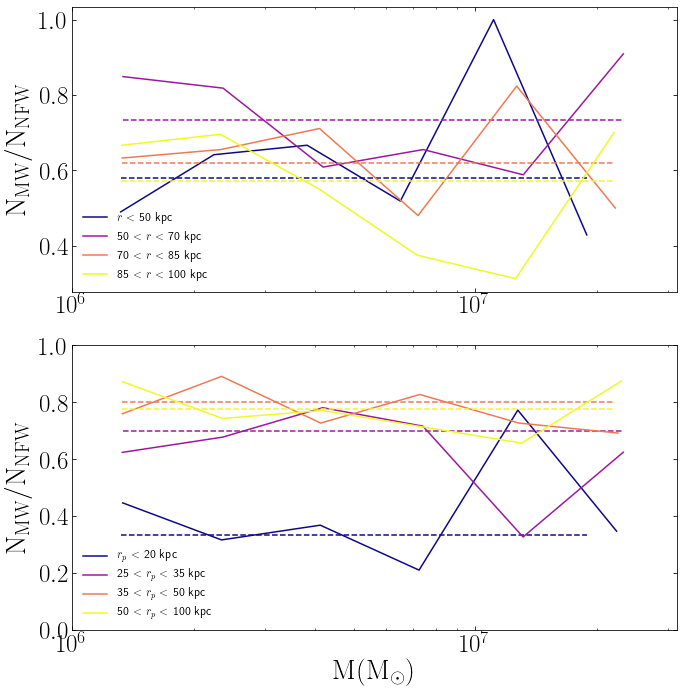

In [127]:
#Bin so same number of subhalos in each bin


bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

colours = cm(np.linspace(0,1,nrbin))

ax1=plt.subplot(2,1,1)

#Rad:
#(array([  3.58744952,  47.58739668,  65.42359623,  81.70548455]),
# array([ 47.43691417,  65.29265141,  81.52378933,  99.95425627]))


#for i in range(0,len(nrat)):
for i in range(0,4):

    if i==0:
        label=r'$r$ $<$ 50 kpc'
    elif i==1:
        label=r'50 $<$ $r$ $<$ 70 kpc'
    elif i==2:
        label=r'70 $<$ $r$ $<$ 85 kpc'
    elif i==3:
        label=r'85 $<$ $r$ $<$ 100 kpc'
    elif i==4:
        label=r'$r$ $>$ 100 kpc'

    print(10.0**n_bins_rad[i])
    
    out=plt.semilogx(10.0**n_bins_rad[i],nrat_rad[i],label='%s' % label,c=colours[i])
    c=out[0].get_color()
    plt.semilogx(10.0**n_bins_rad[i],np.ones(len(n_bins_rad[i]))*nmean_rad[i],c=c,linestyle='--')
    print(nmean_rad[i])
print(np.mean(nmean_rad))
   
plt.xlim(10**6,10**(7.5))
plt.legend(loc=3,frameon=False)
#plt.xlabel(r'$\rm \log_{10} M$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
#plt.ylim(0,1)
#plt.gca().xaxis.set_major_formatter(major_formatter)

ax2=plt.subplot(2,1,2)

#Rp
#[  1.49560076  23.8749038   36.06049059  52.83169622] 
#[ 12.65800502  29.94955934  44.43898054  76.34422678] 
#[ 23.82040929  36.02421487  52.81747049  99.85675734]

#for i in range(0,len(nrat)):
for i in range(0,4):

    if i==0:
        label=r'$r_p$ $<$ 20 kpc'
    elif i==1:
        label=r'25 $<$ $r_p$ $<$ 35 kpc'
    elif i==2:
        label=r'35 $<$ $r_p$ $<$ 50 kpc'
    elif i==3:
        label=r'50 $<$ $r_p$ $<$ 100 kpc'
        
    out=plt.semilogx(10.0**n_bins_rp[i],nrat_rp[i],label='%s' % label, c=colours[i])
    c=out[0].get_color()
    plt.semilogx(10.0**n_bins_rad[i],np.ones(len(n_bins_rad[i]))*nmean_rp[i],c=c,linestyle='--')
    print(nmean_rp[i])
 
print(np.mean(nmean_rp))
plt.xlim(10**6,10**(7.5))
plt.legend(loc=3,frameon=False)
plt.xlabel(r'$\rm M (M_{\odot})$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.ylim(0,1)

#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.tight_layout()

plt.savefig('nrat_rad_2plot.pdf')
plt.show()
plt.close()

In [66]:
print(x_lower,x_mid,x_upper)

[  3.58744952  48.76596688  68.41294055  84.63126718  99.98130726] [  36.32240099   59.1929515    76.31365963   92.0976858   375.11120521] [  48.68225772   68.29405063   84.62035441   99.98130726  665.59114324]


In [67]:
nrbin=3

mwmindx=(mwmz0>1.0e6) * (mwmz0<10.0**(7.5))
nfwmwindx=(nfwmz0>1.0e6) * (nfwmz0<10.0**(7.5))

#x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrphalo[mwindx*mwmindx],nfwrphalo[nfwindx*nfwmwindx]),nrbin)
x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrphalo[nfwindx*nfwmwindx*(nfwrphalo<100)],nrbin)





xrp=[]
yrp=[]

for i in range(0,nrbin):

    mwrindx=(mwrphalo >= x_lower[i]) * (mwrphalo < x_upper[i]) * mwmindx
    nfwrindx=(nfwrphalo >= x_lower[i]) * (nfwrphalo < x_upper[i]) * nfwmwindx
    
    print(np.sum(mwrindx),np.sum(nfwrindx))
    
    if i==0:
        yrp.append(np.sum(mwrindx)/np.sum(nfwrindx))
        xrp.append(0.)       
    
    yrp.append(np.sum(mwrindx)/np.sum(nfwrindx))
    xrp.append(x_mid[i])

print(xrp)
print(yrp)
    
x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(nfwrhalo[nfwindx*nfwmwindx*(nfwrhalo<100)],nrbin)

xrad=[]
yrad=[]

for i in range(0,nrbin):

    mwrindx=(mwrhalo >= x_lower[i]) * (mwrhalo < x_upper[i]) * mwmindx
    nfwrindx=(nfwrhalo >= x_lower[i]) * (nfwrhalo < x_upper[i]) * nfwmwindx
    
    print(np.sum(mwrindx),np.sum(nfwrindx))
    
    if i==0:
        yrad.append(np.sum(mwrindx)/np.sum(nfwrindx))
        xrad.append(0.)  
        
    yrad.append(np.sum(mwrindx)/np.sum(nfwrindx))
    xrad.append(x_mid[i])

print(x_lower)
print(x_mid)
print(x_upper)
print(xrad)
print(yrad)
print(np.mean(yrad))

359 819
593 820
635 820
[0.0, 16.894375663990825, 34.266822898126385, 61.374225724555934]
[0.43833943833943834, 0.43833943833943834, 0.72317073170731705, 0.77439024390243905]
215 340
239 340
202 340
[  3.58744952  56.41589411  79.36061582]
[ 40.41844374  68.12589876  89.4878064 ]
[ 56.32581908  79.3257857   99.98130726]
[0.0, 40.418443737947008, 68.125898756241909, 89.487806404025591]
[0.63235294117647056, 0.63235294117647056, 0.70294117647058818, 0.59411764705882353]
0.640441176471


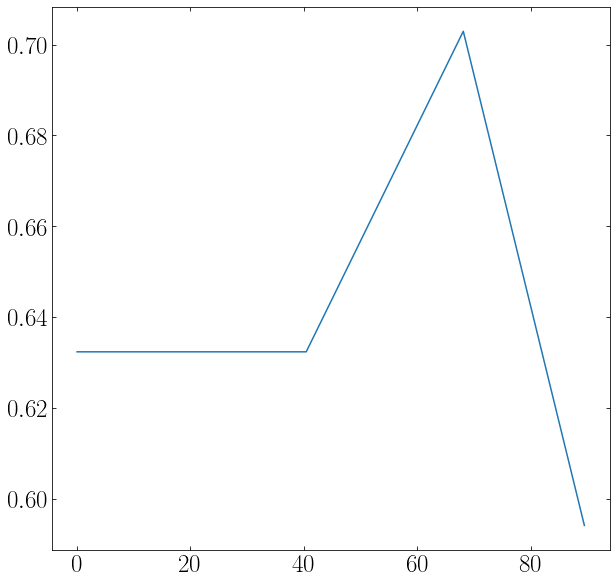

In [68]:
plt.plot(xrad,yrad)
plt.show()
plt.close()

[0.0, 40.418443737947008, 68.125898756241909, 89.487806404025591] [0.63235294117647056, 0.63235294117647056, 0.70294117647058818, 0.59411764705882353]
0.640441176471


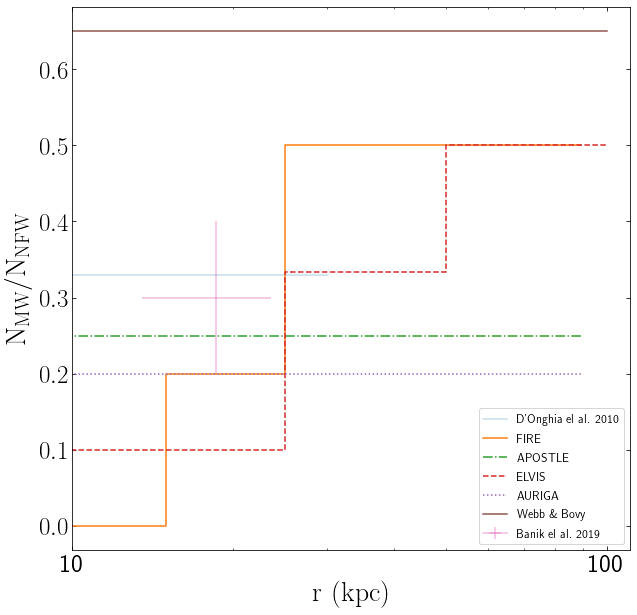

In [123]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

xlim=np.amin(xrad),np.amax(xrad)

#out=plt.plot([],[])
#c=out[0].get_color()
#just line wtihin 30 kpc for 0.333
#plt.fill_between(xlim,[0.33,0.33],[0.5,0.5],alpha=0.1,label='D\'Onghia el al. 2010',color=c)
plt.plot([0,30],[0.33,0.33],alpha=0.25,label='D\'Onghia el al. 2010')


plt.plot([0,15,15,25,25,xlim[-1]],[0.,0.,0.2,0.2,0.5,0.5],label='FIRE')
out=plt.plot(xlim,[0.25,0.25],'-.',label='APOSTLE')
plt.plot([0,25,25,50,50,100],[0.1,0.1,0.333,0.333,0.5,0.5],'--',label='ELVIS')
out=plt.plot(xlim,[0.2,0.2],':',label='AURIGA')
#plt.plot(xrad,yrad,label='Webb \& Bovy')
print(xrad,yrad)
#plt.plot([0,100],[np.mean(yrad),np.mean(yrad)],label='Webb \& Bovy')
plt.plot([0,100],[0.65,0.65],label='Webb \& Bovy')

#plt.plot(xrp,yrp,label='Webb \& Bovy Rp')

print(np.mean(yrad))
#Change to within 20 kpkc, point with error bars
#plt.fill_between(xlim,[0.2,0.2],[0.4,0.4],alpha=0.5,label='Banik el al. 2019')

ogd1=Orbit.from_name('GD1',solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
rpgd1=ogd1.rperi(pot=MWPotential2014, analytic=True)
ragd1=ogd1.rap(pot=MWPotential2014, analytic=True)

opal5=Orbit.from_name('Pal5',solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
rppal5=ogd1.rperi(pot=MWPotential2014, analytic=True)
rapal5=ogd1.rap(pot=MWPotential2014, analytic=True)

xmin=np.amin([rpgd1,ragd1,rppal5,rapal5])
xmax=np.amax([rpgd1,ragd1,rppal5,rapal5])
xmed=(xmin+xmax)/2.
xerr=xmed-xmin


plt.errorbar(xmed,0.3,xerr=xerr,yerr=[0.1],alpha=0.5,label='Banik el al. 2019')

plt.xlabel(r'$\rm r \ (kpc)$')
plt.ylabel(r'$\rm N_{MW}/N_{NFW}$')
plt.legend(loc=4)

#plt.xlim(10.0,100)
#plt.ylim(-0.1,0.65)

plt.xscale('log')
plt.xticks((10,100),(10,100))
#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.savefig('res_compare.pdf')
plt.show()
plt.close()

In [70]:
dmsub8=Simulation(8,rtide=rtide,extension='_outer')

dmsub8.ratios()
dmsub8.orbits(mwpot,'mwpot')
dmsub8.orbits(nfwpot,'nfwpot')
dmsub8.zinfall()

In [71]:
dmsub8.nfwrp,dmsub8.nfwrap,dmsub8.nfwecc,dmsub8.mzi,dmsub8.mz0,12000.0-dmsub8.tinfall,dmsub8.nfwt

(36.918338534939807,
 167.05958599942107,
 0.63801633319667617,
 4427670.0,
 1444430.0,
 3066.4060000000009,
 array([ 8933.594,  8042.969,  7148.438,  6253.906,  5363.281,  4468.75 ,
         3574.219,  2683.594,  1789.062,   894.531,     0.   ]))

In [72]:
print(xrad)

[0.0, 40.418443737947008, 68.125898756241909, 89.487806404025591]


In [73]:
#MEAN RADII instead? #Pericentre?

In [74]:
mwrmean=np.array([m.mwrmean for m in mod])
nfwrmean=np.array([m.nfwrmean for m in mod])

/usr/local/lib/python3.7/site-packages/amuse/units/quantities.py:1379: RuntimeWarning: divide by zero encountered in true_divide
  return numpy.true_divide(array, other, out)

/usr/local/lib/python3.7/site-packages/amuse/units/quantities.py:1379: RuntimeWarning: invalid value encountered in true_divide
  return numpy.true_divide(array, other, out)



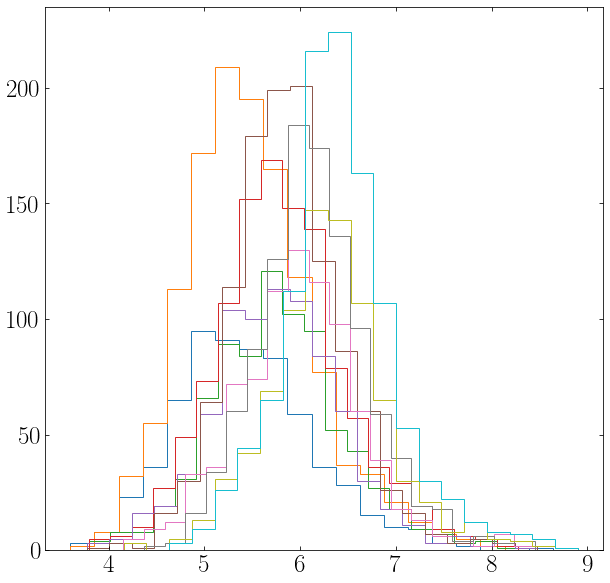

In [75]:
nrbin=5

x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrmean[mwmz0>0.],nfwrmean[nfwmz0>0.]),nrbin)

nrat=[]
n_bins=[]

for i in range(0,nrbin):

    indx=(mwmz0>0.) * (mwrmean >= x_lower[i]) * (mwrmean < x_upper[i])
    nmw,binsmw,patches=plt.hist(np.log10(mwmz0[indx]),bins=20,histtype='step')

    indx=(nfwmz0>0.) * (nfwrmean >= x_lower[i]) * (nfwrmean < x_upper[i])
    nnfw,binsnfw,patches=plt.hist(np.log10(nfwmz0[indx]),bins=binsmw,histtype='step')
    
    nrat.append(nmw/nnfw)
    n_bins.append(((binsmw[0:-1]+binsmw[:-1])/2.))

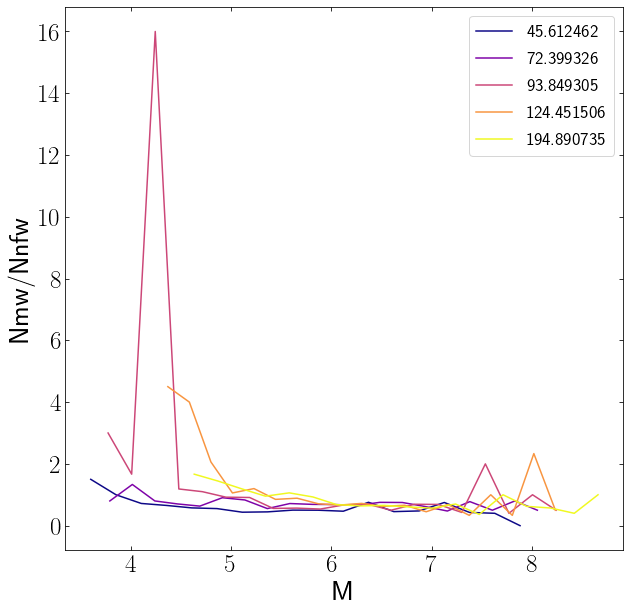

In [76]:
colours = cm(np.linspace(0,1,5))

for i in range(0,len(nrat)):
    plt.plot(n_bins[i],nrat[i],label='%f' % (x_mid[i]),c=colours[i])
    
plt.legend(fontsize=18.)
plt.xlabel('M')
plt.ylabel('Nmw/Nnfw')
plt.show()
plt.close()

In [77]:
#Expected trend only shows up when plotting against pericentre
#Selection effect since we only consider stars with Ra < 100 kpc.
    #So outer sub-halos only have radial orbits that go inwards, not outwards


In [78]:
#Main Plots:
#z=0 Spatial distribution plot, maybe colour coded by mass?
#Orbit distribution plot with Mmw/Mnfw --> via lactea orbit parameters? Or separate figures for MW and NFW?
#rvmax plot (3x2 columns?) --> MW vs NFW for inner, intermediate, and outer?
#Mfunc ratio plot --> current r and vs rp?


In [79]:
xgc=np.array([m.nfwox[-1] for m in mod])
ygc=np.array([m.nfwoy[-1] for m in mod])
zgc=np.array([m.nfwoz[-1] for m in mod])

Rgc=np.sqrt(xgc**2.+ygc**2.)

msh=np.array([m.mz0 for m in mod])

mwmzi=np.array([m.mwmzi for m in mod])
nfwmzi=np.array([m.nfwmzi for m in mod])

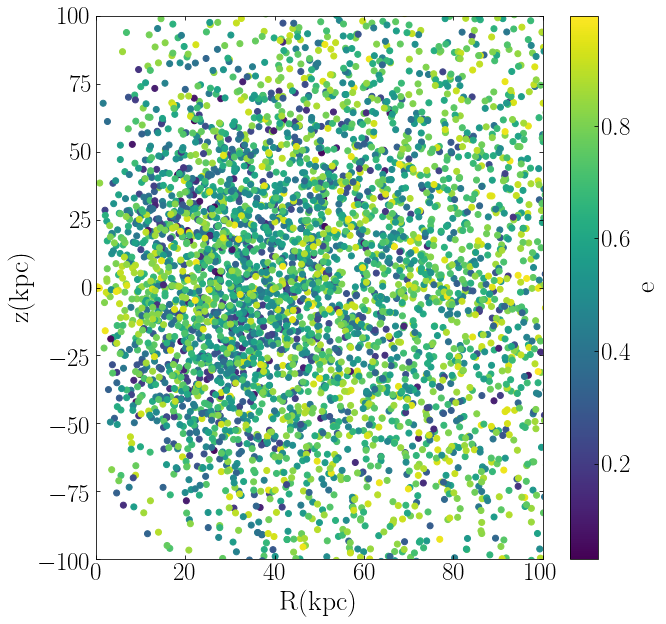

In [80]:
plt.scatter(Rgc/1000.,zgc/1000.,c=ecc)
plt.xlim(0,100)
plt.ylim(-100,100)
plt.xlabel(r'$\rm R (kpc)$')
plt.ylabel(r'$\rm z (kpc)$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm e$')
plt.show()
plt.close()

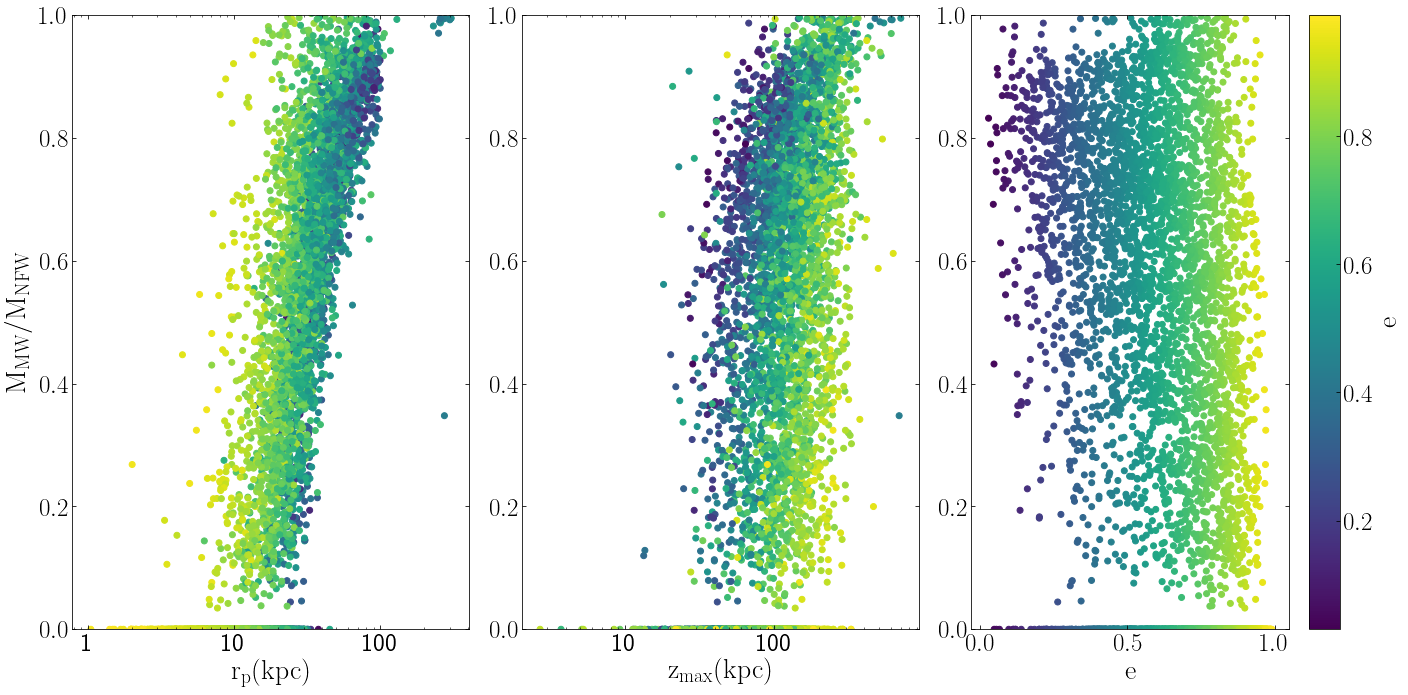

In [103]:
bovy_plot.bovy_print(fig_width=20,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(1,3,3)

plt.scatter(ecc,mrat,c=ecc)
plt.xlabel(r'$\rm e$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm e$')
plt.ylim(0,1)


plt.subplot(1,3,1)

plt.scatter(rp,mrat,c=ecc)
ax = plt.gca()
ax.set_xscale('log')

#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel(r'$\rm r_p (kpc)$')
plt.ylabel(r'$\rm M_{MW}/M_{NFW}$')
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.ylim(0,1)

plt.subplot(1,3,2)

plt.scatter(zmax,mrat,c=ecc)
ax = plt.gca()
ax.set_xscale('log')
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel(r'$\rm z_{max} (kpc)$')

plt.gca().xaxis.set_major_formatter(major_formatter)
plt.ylim(0,1)

plt.tight_layout()

plt.savefig('mrat_3orbit_log.pdf')

plt.show()

In [122]:
mindx=mrat>1
print(np.sum(mindx))
np.amax(mwrphalo[mindx])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.

41


55.963257190214797

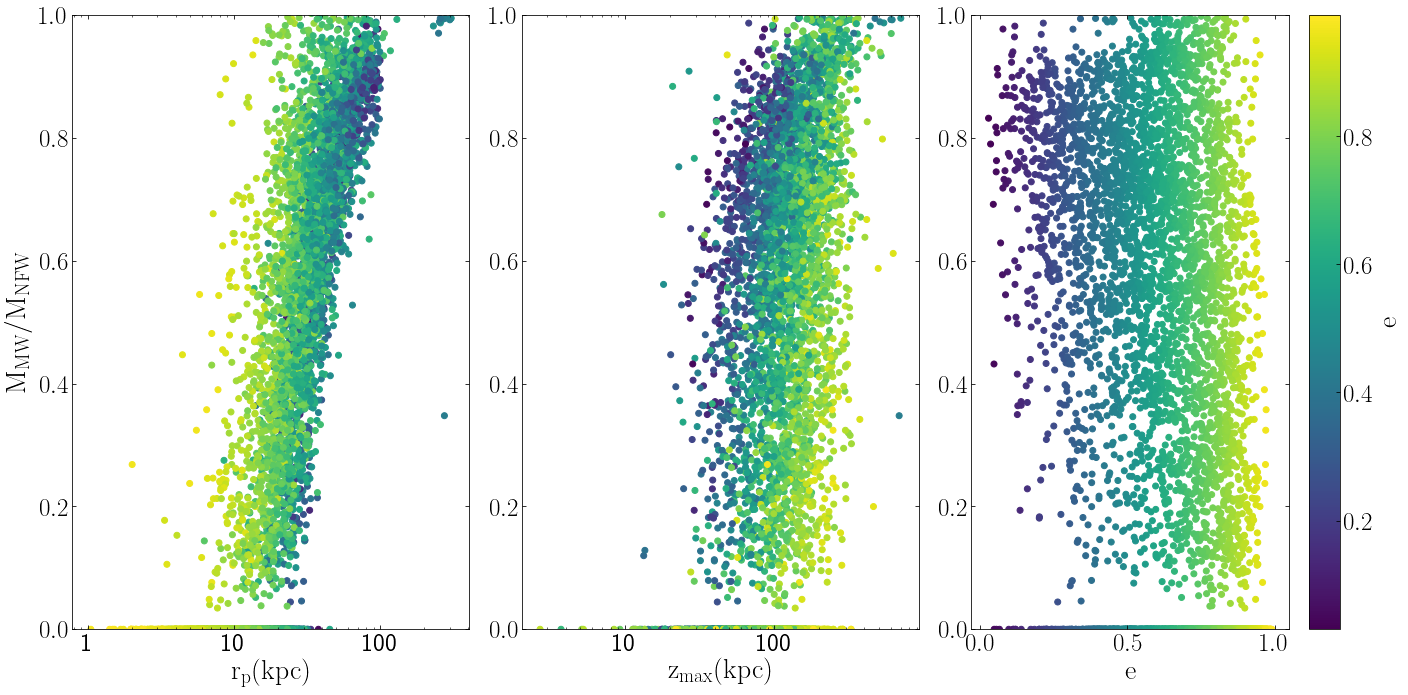

In [82]:
bovy_plot.bovy_print(fig_width=20,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(1,3,3)

plt.scatter(ecc,mrat,c=ecc)
plt.xlabel(r'$\rm e$')
cbar=plt.colorbar()
cbar.set_label(r'$\rm e$')
plt.ylim(0,1)

plt.subplot(1,3,1)

plt.scatter(rp,mrat,c=ecc)
ax = plt.gca()
ax.set_xscale('log')

#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel(r'$\rm r_p (kpc)$')
plt.ylabel(r'$\rm M_{MW}/M_{NFW}$')
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.ylim(0,1)

plt.subplot(1,3,2)

plt.scatter(zmax,mrat,c=ecc)
ax = plt.gca()
ax.set_xscale('log')
#plt.ylabel(r'$M_{MW}/M_{NFW}$')
plt.xlabel(r'$\rm z_{max} (kpc)$')

plt.gca().xaxis.set_major_formatter(major_formatter)
plt.ylim(0,1)

plt.tight_layout()

plt.savefig('mrat_3orbit_log.png')

plt.show()

In [83]:
mindx=mrat>0
print(np.amin(rp[mindx]))
#Everything with rp < 3.35 kpc is destroyed, with very few subhalos existing with rp < 10 kpc. 
#The ones that do have typically high eccentricties and spend the majority of their time in the outskirts of the galaxy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.

2.01323493958


[0.0, 40.0, 70.0]
[40.0, 70.0, 100.0]


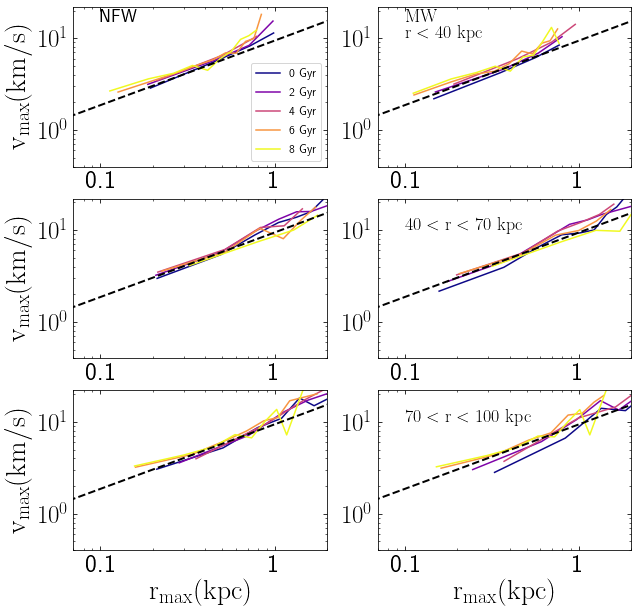

In [84]:
colours = cm(np.linspace(0,1,5))
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)
#plt.gca().xaxis.set_major_formatter(major_formatter)


x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrhalo[mwmz0>0.],nfwrhalo[nfwmz0>0.]),3)
times=np.array([0.,2000.,4000.,6000.,8000.])

x_lower=[0.,40.,70.]
x_upper=[40.,70.,100.]
x_mid=[20.,55.,85]

print(x_lower)
print(x_upper)

#MW VALUES 

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

ax1=plt.subplot(3,2,1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[0]) * (mwrhalo < x_upper[0])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])
    tlabel=t/1000

    plt.loglog(r_v/1000.0,v_max,label='%.0f Gyr' % tlabel,c=colours[j])
 
plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)

#plt.title('NFW %f' % x_mid[0])
plt.xlim(0.07,2.)
plt.ylim(0.4,22)

#plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km/s) $')
plt.legend(loc=4)
plt.text(0.1,15,r'NFW')
plt.gca().xaxis.set_major_formatter(major_formatter)
        
plt.subplot(3,2,3,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[1]) * (mwrhalo < x_upper[1])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])
    tlabel=t/1000
    plt.loglog(r_v/1000.0,v_max,label='%.0f Gyr' % tlabel,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
#plt.title('NFW %f' % x_mid[1])
#plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(3,2,5,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[2]) * (mwrhalo < x_upper[2])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)

#plt.title('NFW %f' % x_mid[2])
plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(3,2,2,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[0]) * (mwrhalo < x_upper[0])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
plt.text(0.1,15,r'$\rm MW$')
plt.text(0.1,10,r'$\rm r < 40 \ kpc$')


#plt.title('MW %f' % x_mid[0])
#plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(3,2,4,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[1]) * (mwrhalo < x_upper[1])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
plt.text(0.1,10,r'$\rm 40 < r < 70 \ kpc$')

#plt.title('MW %f' % x_mid[1])
#plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplot(3,2,6,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrhalo >= x_lower[2]) * (mwrhalo < x_upper[2])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])
    
plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
plt.text(0.1,10,r'$\rm 70 < r < 100 \ kpc$')

#plt.title('MW %f' % x_mid[2])
plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)


plt.gca().xaxis.set_major_formatter(major_formatter)
plt.savefig('via_lactea_rvmax_rad.pdf')

plt.show()
plt.close()

In [85]:
print(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
print(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

0.009424218 3.011141833
0.181111 34.257626


[0.0, 20.0, 50.0]
[20.0, 50.0, 100.0]


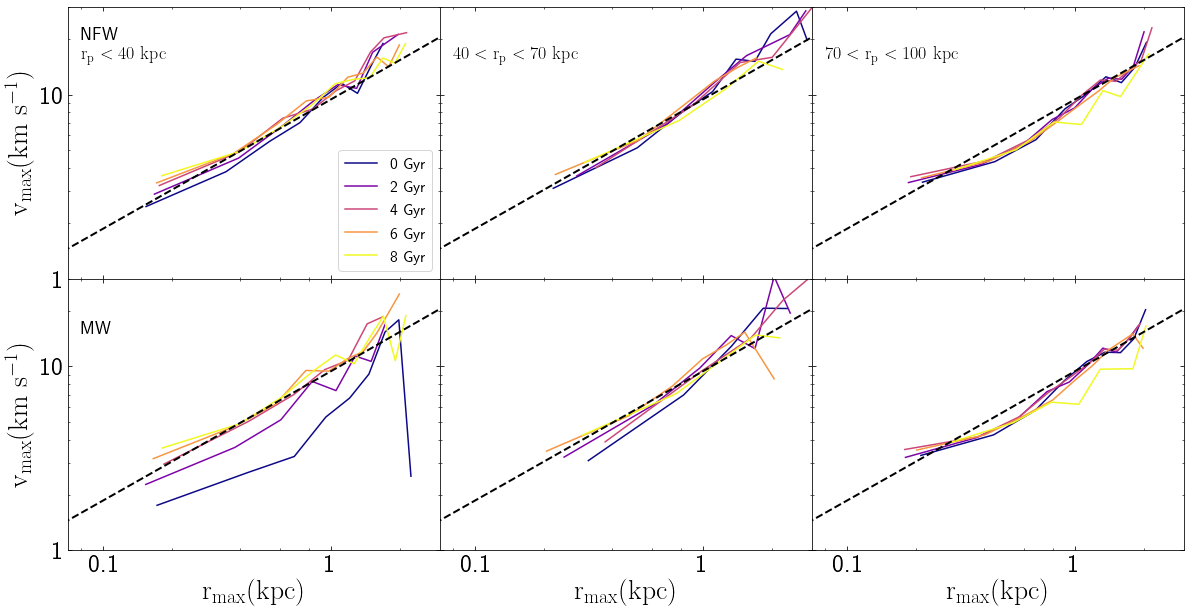

In [86]:
bovy_plot.bovy_print(fig_width=20,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

#plt.gca().xaxis.set_major_formatter(major_formatter)

x_lower, x_mid, x_upper, x_hist=npy.nbinmaker(np.append(mwrphalo[mwmz0>0.],nfwrphalo[nfwmz0>0.]),3)
times=np.array([0.,2000.,4000.,6000.,8000.])

x_lower=[0.,20.,50.]
x_upper=[20.,50.,100.]
x_mid=[10.,35.,75]

print(x_lower)
print(x_upper)

#MW VALUES 
ax1=plt.subplot(2,3,1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[0]) * (mwrphalo < x_upper[0])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    tlabel=t/1000
    plt.loglog(r_v/1000.0,v_max,label='%.0f Gyr' % tlabel,c=colours[j])
 
plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)

#plt.title('NFW %f' % x_mid[0])

#plt.xlim(np.amin(mwrvmaxz0/1000.0),np.amax(nfwrvmaxz0/1000.0))
#plt.ylim(np.amin(nfwvmaxz0),np.amax(nfwvmaxz0))

plt.text(0.08,15,r'$\rm r_p < 40 \ kpc$')

#plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km \ s^{-1}) $')
plt.text(0.08,20,r'NFW')
plt.legend(loc=4,fontsize=16.)

plt.xlim(0.07,3)
plt.ylim(1,30)

ax2=plt.subplot(2,3,2,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[1]) * (mwrphalo < x_upper[1])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
plt.text(0.08,15,r'$\rm 40 < r_p < 70 \ kpc$')

ax2.label_outer()


#plt.title('NFW %f' % x_mid[1])
#plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.legend(fontsize=18.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

ax3=plt.subplot(2,3,3,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[2]) * (mwrphalo < x_upper[2])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times,gtype='NFW')
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
plt.text(0.08,15,r'$\rm 70 < r_p < 100 \ kpc$')

#plt.title('NFW %f' % x_mid[2])
#plt.legend(fontsize=18.)
#plt.gca().xaxis.set_major_formatter(major_formatter)
#plt.gca().xaxis.set_major_formatter(lambda x,pos: r'$%g$' % x)

ax3.label_outer()

plt.subplot(2,3,4,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[0]) * (mwrphalo < x_upper[0])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)

plt.text(0.08,15,r'MW')
#plt.text(0.1,10,r'$\rm r_p < 40 \ kpc$')

#plt.title('MW %f' % x_mid[0])
plt.xlabel(r'$\rm r_{max} (kpc)$')
plt.ylabel(r'$\rm v_{max} (km \ s^{-1}) $')
#plt.legend(fontsize=18.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

ax5=plt.subplot(2,3,5,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[1]) * (mwrphalo < x_upper[1])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])

plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
#plt.text(0.1,10,r'$\rm 40 < r_p < 70 \ kpc$')

#plt.title('MW %f' % x_mid[1])
plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
#plt.gca().xaxis.set_major_formatter(major_formatter)

ax5.label_outer()


ax6=plt.subplot(2,3,6,sharex=ax1,sharey=ax1)

indx=(mwmz0>0.) * (mwrphalo >= x_lower[2]) * (mwrphalo < x_upper[2])

t_vmax=np.array([])
r_vmax=np.array([])
v_vmax=np.array([])


for j in range(0,len(mod)):
    if indx[j]:
        tvmax,rvmax,vmax=mod[j].rvmax_interpolate(times)
        t_vmax=np.append(t_vmax,tvmax)
        r_vmax=np.append(r_vmax,rvmax)
        v_vmax=np.append(v_vmax,vmax)


for j,t in enumerate(times):
    tindx=(t_vmax==t)
    if np.sum(tindx) > 0:
        r_v,v_max,sig=npy.mean_prof(r_vmax[tindx],v_vmax[tindx])

    plt.loglog(r_v/1000.0,v_max,label='%f Gyr' % t,c=colours[j])
    
plt.loglog(rmax_cdm,vmax_cdm,'k--',linewidth=2)
#plt.text(0.1,10,r'$\rm 70 < r_p < 100 \ kpc$')


#plt.title('MW %f' % x_mid[2])
plt.xlabel(r'$\rm r_{max} (kpc)$')
#plt.ylabel(r'$\rm v_{max} (km/s) $')
#plt.legend(fontsize=18.)
#plt.text(0.1,10,r'$\rm 70 < r_p < 100 \ kpc$')
ax6.label_outer()

#plt.gca().xaxis.set_major_formatter(major_formatter)

plt.subplots_adjust(wspace=0, hspace=0)

locmaj = ticker.LogLocator(base=10,numticks=5) # 5 is the number of orders of mag to show
plt.gca().xaxis.set_major_locator(locmaj)
locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=5) # 5 = same as above, subs is where you want the minor ticks (0.1,0.2,0.3,0.4,0.5,...for all 10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(ticker.NullFormatter())
plt.gca().xaxis.set_major_formatter(major_formatter)
plt.gca().yaxis.set_major_formatter(major_formatter)

plt.savefig('via_lactea_rvmax_rp.pdf')

plt.show()
plt.close()

### Look at above plot in Rp?

In [87]:
#What is VIA LACTEA X-Y plane?
#Smooth/spline mass function?

In [88]:
#Mess with binning? #Just fit 10^6 and higher?

In [89]:
#How does distribution of velocities change for different mass bins?
#Beta, beta(r)? --> Kelley paper?
mwxgc=np.array([])
mwygc=np.array([])
mwzgc=np.array([])
mwvxgc=np.array([])
mwvygc=np.array([])
mwvzgc=np.array([])

nfwxgc=np.array([])
nfwygc=np.array([])
nfwzgc=np.array([])
nfwvxgc=np.array([])
nfwvygc=np.array([])
nfwvzgc=np.array([])

imwxgc=np.array([])
imwygc=np.array([])
imwzgc=np.array([])
imwvxgc=np.array([])
imwvygc=np.array([])
imwvzgc=np.array([])

infwxgc=np.array([])
infwygc=np.array([])
infwzgc=np.array([])
infwvxgc=np.array([])
infwvygc=np.array([])
infwvzgc=np.array([])

for m in mod:
    mwxgc=np.append(mwxgc,m.mwox[-1])
    mwygc=np.append(mwygc,m.mwoy[-1])
    mwzgc=np.append(mwzgc,m.mwoz[-1])
    mwvxgc=np.append(mwvxgc,m.mwovx[-1])
    mwvygc=np.append(mwvygc,m.mwovy[-1])
    mwvzgc=np.append(mwvzgc,m.mwovz[-1])
    
    nfwxgc=np.append(nfwxgc,m.nfwox[-1])
    nfwygc=np.append(nfwygc,m.nfwoy[-1])
    nfwzgc=np.append(nfwzgc,m.nfwoz[-1])
    nfwvxgc=np.append(nfwvxgc,m.nfwovx[-1])
    nfwvygc=np.append(nfwvygc,m.nfwovy[-1])
    nfwvzgc=np.append(nfwvzgc,m.nfwovz[-1])
    
    imwxgc=np.append(imwxgc,m.mwox[0])
    imwygc=np.append(imwygc,m.mwoy[0])
    imwzgc=np.append(imwzgc,m.mwoz[0])
    imwvxgc=np.append(imwvxgc,m.mwovx[0])
    imwvygc=np.append(imwvygc,m.mwovy[0])
    imwvzgc=np.append(imwvzgc,m.mwovz[0])
    
    infwxgc=np.append(infwxgc,m.nfwox[0])
    infwygc=np.append(infwygc,m.nfwoy[0])
    infwzgc=np.append(infwzgc,m.nfwoz[0])
    infwvxgc=np.append(infwvxgc,m.nfwovx[0])
    infwvygc=np.append(infwvygc,m.nfwovy[0])
    infwvzgc=np.append(infwvzgc,m.nfwovz[0])
    





In [90]:
def to_sphere(x,y,z,vx,vy,vz):
  
    
    rad=np.sqrt(x**2.+y**2.+z**2.)
    theta=np.arccos(z/rad)
    phi=np.arctan2(y,x)
    
    rhatx=x/rad
    rhaty=y/rad
    rhatz=z/rad
    
    thatx=np.cos(theta)*np.cos(phi)
    thaty=np.cos(theta)*np.sin(phi)
    thatz=-1.*np.sin(theta)
    
    phatx=-1.*np.sin(phi)
    phaty=np.cos(phi)
    phatz=0.
    
    vr=vx*rhatx+vy*rhaty+vz*rhatz
    vtheta=vx*thatx+vy*thaty+vz*thatz
    vphi=vx*phatx+vy*phaty+vz*phatz
    
    return rad,phi,theta,vr,vphi,vtheta

In [91]:
print(len(mwxgc),len(mwmz0))

6236 6236


In [92]:
mwsubhalos=npy.StarCluster(ctype='snapshot',units='realpc',origin='galaxy')
mwsubhalos.add_stars(mwxgc[mwmz0>0.],mwygc[mwmz0>0.],mwzgc[mwmz0>0.],mwvxgc[mwmz0>0.],mwvygc[mwmz0>0.],mwvzgc[mwmz0>0.],mwmz0[mwmz0>0.])
mwsubhalos.to_realkpc()
mwr, mwphi, mwtheta, mwvr, mwvphi, mwvtheta=to_sphere(mwsubhalos.x,mwsubhalos.y,mwsubhalos.z,mwsubhalos.vx,mwsubhalos.vy,mwsubhalos.vz)

imwsubhalos=npy.StarCluster(ctype='snapshot',units='realpc',origin='galaxy')
imwsubhalos.add_stars(imwxgc,imwygc,imwzgc,imwvxgc,imwvygc,imwvzgc,mwmzi)
imwsubhalos.to_realkpc()
imwr, imwphi, imwtheta, imwvr, imwvphi, imwvtheta=to_sphere(imwsubhalos.x,imwsubhalos.y,imwsubhalos.z,imwsubhalos.vx,imwsubhalos.vy,imwsubhalos.vz)


In [93]:
nfwsubhalos=npy.StarCluster(ctype='snapshot',units='realpc',origin='galaxy')
nfwsubhalos.add_stars(nfwxgc[nfwmz0>0.],nfwygc[nfwmz0>0.],nfwzgc[nfwmz0>0.],nfwvxgc[nfwmz0>0.],nfwvygc[nfwmz0>0.],nfwvzgc[nfwmz0>0.],nfwmz0[nfwmz0>0.])
nfwsubhalos.to_realkpc()
nfwr, nfwphi, nfwtheta, nfwvr, nfwvphi, nfwvtheta=to_sphere(nfwsubhalos.x,nfwsubhalos.y,nfwsubhalos.z,nfwsubhalos.vx,nfwsubhalos.vy,nfwsubhalos.vz)

infwsubhalos=npy.StarCluster(ctype='snapshot',units='realpc',origin='galaxy')
infwsubhalos.add_stars(infwxgc,infwygc,infwzgc,infwvxgc,infwvygc,infwvzgc,nfwmzi)
infwsubhalos.to_realkpc()
infwr, imwphi, imwtheta, imwvr, imwvphi, imwvtheta=to_sphere(infwsubhalos.x,infwsubhalos.y,infwsubhalos.z,infwsubhalos.vx,infwsubhalos.vy,infwsubhalos.vz)


In [94]:
#Compare to other ? Dennis 1/3, Fire --> everything destroyed

In [95]:
print(np.std(mwvr),np.std(mwvphi),np.std(mwvtheta))
print(np.std(nfwvr),np.std(nfwvphi),np.std(nfwvtheta))

87.6864791717 71.6653560978 101.892769846
88.7754518383 63.8353089342 88.1984410516


In [96]:
mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='r',normalize=False)

In [97]:
r_lower, r_mean, r_upper, r_hist = npy.nbinmaker(mwsubhalos.r, 10)
print(r_mean)

[  30.23955236   46.5325733    60.42068854   73.75707444   88.12093233
  102.7720691   122.05550179  147.08745503  182.46717748  246.31318119]


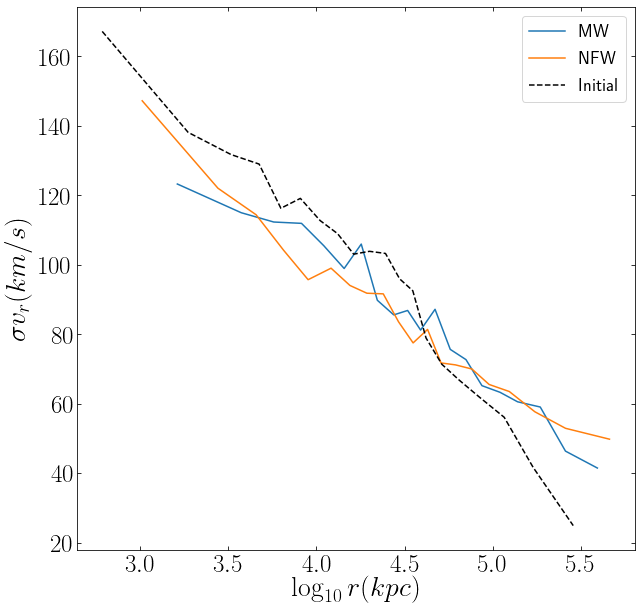

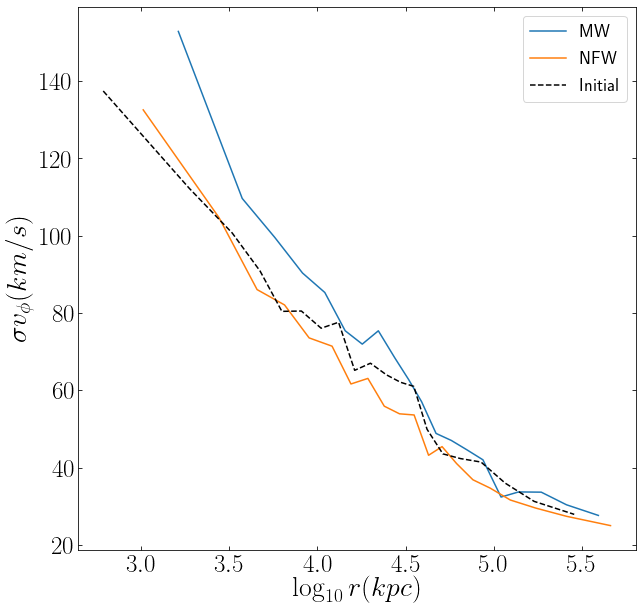

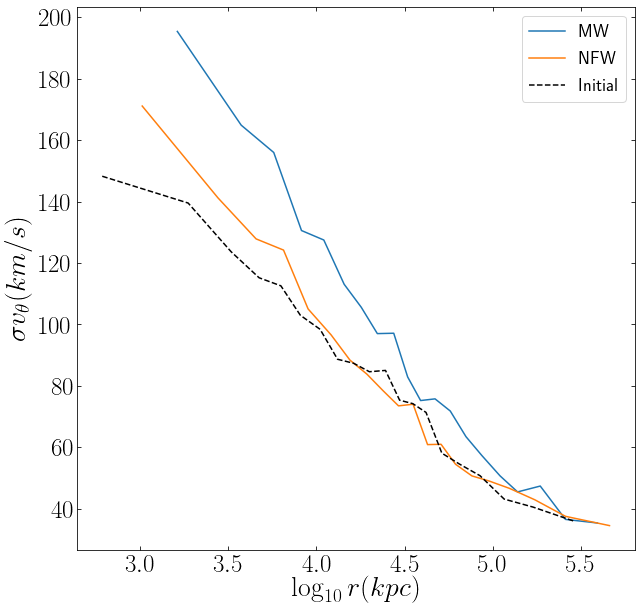

In [98]:
mwsubhalos.key_params()
nfwsubhalos.key_params()

mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='r',normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='r',normalize=False)

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')

imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='r',normalize=False)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')

plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_r (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='phi',normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='phi',normalize=False)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')
imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='phi',normalize=False)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')
plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_{\phi} (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='theta',normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='theta',normalize=False)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')

imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='theta',normalize=False)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')

plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_{\theta} (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()



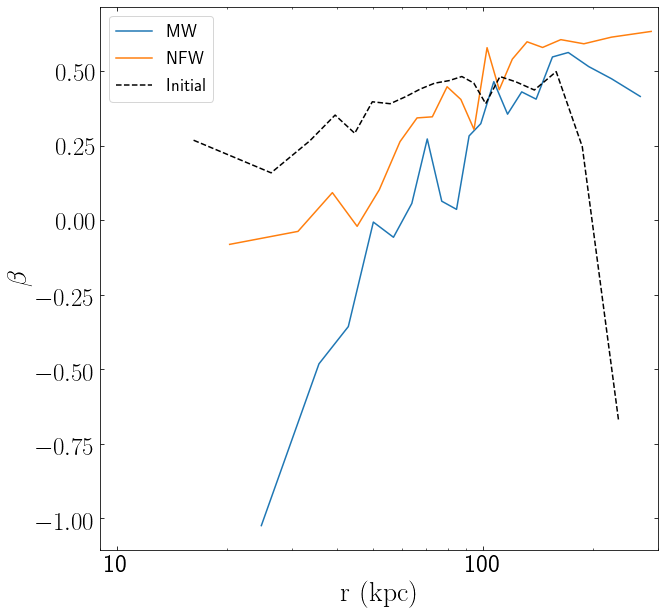

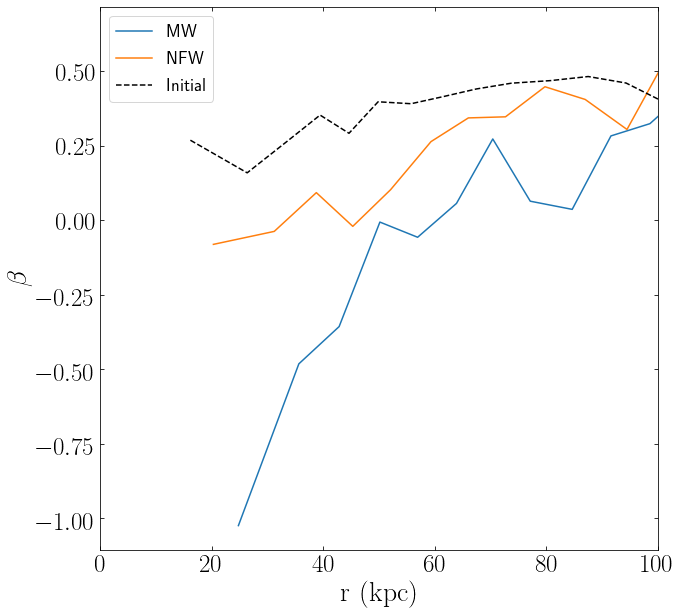

In [99]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.semilogx(np.exp(np.array(mwlrprofn)),mwbetaprof,label='MW')
plt.semilogx(np.exp(np.array(nfwlrprofn)),nfwbetaprof,label='NFW')
plt.semilogx(np.exp(np.array(imwlrprofn)),imwbetaprof,'k--',label='Initial')

plt.xlabel(r'$\rm r \ (kpc)$')
plt.ylabel(r'$\beta$')
plt.legend(fontsize=18.)

plt.xlim(9,300)
plt.gca().xaxis.set_major_formatter(major_formatter)

plt.savefig('beta_prof_log.pdf')
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(np.exp(np.array(mwlrprofn)),mwbetaprof,label='MW')
plt.plot(np.exp(np.array(nfwlrprofn)),nfwbetaprof,label='NFW')
plt.plot(np.exp(np.array(imwlrprofn)),imwbetaprof,'k--',label='Initial')

plt.xlabel(r'$\rm r \ (kpc)$')
plt.ylabel(r'$\beta$')
plt.legend(fontsize=18.)
plt.xlim(0,100)
plt.savefig('beta_prof.pdf')
plt.show()
plt.close()

In [100]:
### Bin by pericentre
#What is the initial profiles?

### mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='r',rcustom=mwrphalo[mwmz0>0.],normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='r',rcustom=nfwrphalo[nfwmz0>0.],normalize=False)

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')

imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='r',normalize=False)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')

plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_r (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='phi',rcustom=mwrphalo[mwmz0>0.],normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='phi',rcustom=nfwrphalo[nfwmz0>0.],normalize=False)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')
imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='phi',normalize=False)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')
plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_{\phi} (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

mwlrprofn, mwsigvprof, mwbetaprof=npy.sigv_prof(mwsubhalos,coord='theta',rcustom=mwrphalo[mwmz0>0.],normalize=False)
nfwlrprofn, nfwsigvprof, nfwbetaprof=npy.sigv_prof(nfwsubhalos,coord='theta',rcustom=nfwrphalo[nfwmz0>0.],normalize=False)

plt.plot(mwlrprofn,mwsigvprof,label='MW')
plt.plot(nfwlrprofn,nfwsigvprof,label='NFW')

imwlrprofn, imwsigvprof, imwbetaprof=npy.sigv_prof(imwsubhalos,coord='theta',normalize=False,rcustom=mwrphalo)
plt.plot(imwlrprofn,imwsigvprof,'k--',label='Initial')

plt.xlabel(r'$\log_{10} r (kpc)$')
plt.ylabel(r'$\sigma v_{\theta} (km/s)$')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(np.exp(np.array(mwlrprofn)),mwbetaprof,label='MW')
plt.plot(np.exp(np.array(nfwlrprofn)),nfwbetaprof,label='NFW')
plt.plot(np.exp(np.array(imwlrprofn)),imwbetaprof,'k--',label='Initial')

plt.xlabel(r'$\rm \log_{10} (r_p) \ (kpc)$')
plt.ylabel(r'$\beta$')
plt.legend(fontsize=18.)
plt.savefig('beta_prof_rp.pdf')
plt.show()
plt.close()

In [101]:
#NFW mass function vs VL2 mass function

In [102]:
fire=Simulation(8,rtide=rtide,extension='_FIRE')
vl2=Simulation(8,rtide=rtide,extension='_vl2')
gyr=Simulation(8,rtide=rtide)



OSError: ./mwpot_FIRE/submit_legend.dat not found.

In [ ]:
print(fire.mzi,fire.mz0,fire.rti,fire.rt0)
print(vl2.mzi,vl2.mz0,fire.rti,fire.rt0)
print(gyr.mzi,gyr.mz0,fire.rti,fire.rt0)


In [ ]:
print(gyr.exnfwm[0],fire.exnfwm[0],vl2.exnfwm[0])
print(gyr.nfwm[0],fire.nfwm[0],vl2.nfwm[0])

In [ ]:
plt.plot(fire.nfwt,fire.nfwm,label='FIRE')
plt.plot(vl2.nfwt,vl2.nfwm,label='VL2')
plt.plot(gyr.nfwt,gyr.nfwm,label='GYRFALCON')
plt.plot(gyr.exnfwt,gyr.exnfwm,label='GYRFALCON ALL')

plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
plt.legend(fontsize=18.)
plt.show()
plt.close()

bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

plt.plot(np.flip(gyr.nfwt),gyr.nfwm/gyr.nfwm[0],label='Webb \& Bovy')
plt.plot(np.flip(vl2.nfwt),vl2.nfwm/vl2.nfwm[0],label='VL2')
plt.plot(np.flip(fire.nfwt),fire.nfwm/fire.nfwm[0],label=r'FIRE')
#plt.plot(gyr.exnfwt,gyr.exnfwm,label='GYRFALCON ALL')
plt.xlabel(r'$\rm Time (Myr)$')
plt.ylabel(r'$\rm M/M_i$')
#plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
plt.legend(fontsize=18.)
plt.savefig('subhalo_evolve.pdf')
plt.show()
plt.close()

In [ ]:
plt.plot(fire.nfwt,fire.nfwrl,label='FIRE')
plt.plot(vl2.nfwt,vl2.nfwrl,label='VL2')
plt.plot(gyr.nfwt,gyr.nfwrl,label='GYRFALCON')
#plt.plot(gyr.exnfwt,gyr.exnfwrl,label='GYRFALCON ALL')

plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.rti,'k--')

plt.legend(fontsize=18.)

plt.show()
plt.close()

In [ ]:
indx=(mwmz0>0) * (nfwmz0>0)
mrat=mwmz0[indx]/nfwmz0[indx]

print(np.mean(mrat),np.median(mrat))

In [ ]:
plt.hist(mrat,bins=20)
plt.xlabel(r'$M_{MW}/M_{NFW}$')
plt.text(1,175,'Mean = 0.565',fontsize=20)
plt.text(1,150,'Median = 0.589',fontsize=20)
plt.savefig('mrat_hist.pdf')
plt.show()
plt.close()

In [ ]:
indx2=(mwmz0>10**6) * (nfwmz0>10**6)
mrat2=mwmz0[indx2]/nfwmz0[indx2]

print(np.mean(mrat2),np.median(mrat2))

In [ ]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

mi=[]
ipass=[]
nfail=0

for i in range(0,1000):
    #print(i)
    try:
        fire=Simulation(i,rtide=rtide,extension='_FIRE')
        gyr=Simulation(i,rtide=rtide)
    

        #out=plt.plot(np.flip(gyr.nfwt),gyr.nfwm/gyr.nfwm[0],label='%i, %f' % (i,np.log10(gyr.mzi)))
        #c=out[0].get_color()
        #plt.plot(np.flip(fire.nfwt),fire.nfwm/fire.nfwm[0],'--',c=c)
        mgyr=gyr.nfwm/gyr.nfwm[0]
        mfire=fire.nfwm/fire.nfwm[0]

        while len(mfire) <len(mgyr):
            mfire=np.append(mfire,0.0)
        
        plt.plot(np.flip(gyr.nfwt),mfire/mgyr,label=r'$\log_{10}(M_i) \sim $%.1f' % np.log10(gyr.mzi))

        mi.append(np.log10(gyr.mzi))
        ipass.append(i)
        
    except:
        nfail+=1
        if i!=307:
            data=np.loadtxt('./nfw_FIRE/extrct%snfw.npy' % str(i))
            print(i,'FAIL',data[0])
        
plt.xlabel(r'$\rm Time (Myr)$')
plt.ylabel(r'$\rm M/M_i$')
#plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
#plt.legend(fontsize=18.)
plt.savefig('subhalo_evolve.pdf')
plt.show()
plt.close()

print('NFAIL = ',nfail)

In [ ]:
mcolours = cm(np.linspace(0,1,len(mi)))
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

#minit=[6,6.5,7,7.5,8,8.5,9]
minit=[6,6.25,6.5,6.75,7.,7.25,7.5]

for j in range(0,len(ipass)):
    
    if mi[j] <=minit[-1]:
        i=ipass[j]

        fire=Simulation(i,rtide=rtide,extension='_FIRE')
        gyr=Simulation(i,rtide=rtide)

        mgyr=gyr.nfwm/gyr.nfwm[0]
        mfire=fire.nfwm/fire.nfwm[0]


        while len(mfire) <len(mgyr):
            mfire=np.append(mfire,0.0)

        mc=np.argmin(np.fabs((mi[j]-np.amin(minit))/(np.amax(minit)-np.amin(minit))-np.linspace(0,1,len(mi))))

        plt.plot(np.flip(gyr.nfwt),mfire/mgyr,c=mcolours[mc]) #,label=r'$\log_{10}(M_i) \sim $%.1f' % mi[j])
    
for j in range(0,len(minit)):
    mc=np.argmin(np.fabs((minit[j]-np.amin(minit))/(np.amax(minit)-np.amin(minit))-np.linspace(0,1,len(mi))))
    plt.plot([],[],c=mcolours[mc],label=r'$\log_{10}(M_i) \sim $%.1f' % minit[j])
    
plt.xlabel(r'$\rm Time (Myr)$')
plt.ylabel(r'$\rm M/M_i$')
#plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
plt.legend(fontsize=18.)
plt.savefig('subhalo_evolve_rescompare.pdf')
plt.show()
plt.close()

In [ ]:
#times=np.linspace(0.,9000.,10)
times=np.array([0.,1000.,2000.,3000.,4000.,5000.,6000.])



#mlower=[6,6.25,6.5,6.75,7.,7.25,7.5,7.75]
#mupper=[6.25,6.5,6.75,7.,7.25,7.5,7.75,8.]

mlower=[6,6.5,7,7.5]
mupper=[6.5,7,7.5,8]

mmid=(np.array(mupper)+np.array(mlower))/2.

for k in range(0,len(mlower)):

    tm_nfw=np.array([])
    m_nfw=np.array([])
    nm=0

    for j in range(0,len(ipass)):
    #for j in range(0,10):

        i=ipass[j]
        
        if mi[j]>=mlower[k] and mi[j]<=mupper[k]:


            fire=Simulation(i,rtide=rtide,extension='_FIRE')
            gyr=Simulation(i,rtide=rtide)

            tf,mf=fire.mass_interpolate(times,gtype='NFW')
            tg,mg=gyr.mass_interpolate(times,gtype='NFW')
            
            mf=mf/mf[0]
            mg=mg/mg[0]
            
            


            while len(mf) <len(mg):
                mf=np.append(mf,0.0)
            tf=tg
                
                
            tm_nfw=np.append(tm_nfw,tg)
            m_nfw=np.append(m_nfw,mf/mg)
            
            nm+=1
         
    if len(tm_nfw)>0:    
        tsub,msub,sig=npy.mean_prof(tm_nfw,m_nfw)
        mc=np.argmin(np.fabs((mmid[k]-np.amin(mlower))/(np.amax(mlower)-np.amin(mlower))-np.linspace(0,1,len(mi))))
        plt.plot(tsub/1000.0,msub,label=r'$%.1f < \log_{10}(m_i) < %.1f$' %(mlower[k],mupper[k]) ,c=mcolours[mc])

plt.legend(fontsize=18.)

plt.xlabel(r'$\rm Time (Gyr)$')
plt.ylabel(r'$\rm M_{low-res}/M_{high-res}$')

plt.savefig('lowres_evolve.png')

plt.show()
plt.close()


In [ ]:
#times=np.linspace(0.,9000.,10)

mlower=[6,7,8]
mupper=[7,8,9]

bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]

for k in range(0,len(mlower)):

    m_nfw=np.array([])

    for j in range(0,len(ipass)):
    #for j in range(0,10):

        i=ipass[j]
        
        if mi[j]>=mlower[k] and mi[j]<=mupper[k]:


            fire=Simulation(i,rtide=rtide,extension='_FIRE')
            gyr=Simulation(i,rtide=rtide)

            tf,mf=fire.mass_interpolate(times,gtype='NFW')
            tg,mg=gyr.mass_interpolate(times,gtype='NFW')
            
            mf=mf/mf[0]
            mg=mg/mg[0]
            
            


            while len(mf) <len(mg):
                mf=np.append(mf,0.0)
            tf=tg
                                
            m_nfw=np.append(m_nfw,mf[-1]/mg[-1])
         
    out=plt.hist(m_nfw,histtype='step',label=r'$%.2f < \log_{10}(m_i) < %.2f$' %(mlower[k],mupper[k]))
    
plt.legend(fontsize=18.)
plt.xlabel(r'$\rm M_{low-res}/M_{high-res}$')
plt.savefig('lowres_hist.pdf')

plt.show()
plt.close()

In [ ]:
#times=np.linspace(0.,9000.,10)

mlower=[6,7,8]
mupper=[7,8,9]

bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]

for k in range(0,len(mlower)):

    m_nfw=np.array([])

    for j in range(0,len(ipass)):
    #for j in range(0,10):

        i=ipass[j]
        
        if mi[j]>=mlower[k] and mi[j]<=mupper[k]:


            fire=Simulation(i,rtide=rtide,extension='_FIRE')
            gyr=Simulation(i,rtide=rtide)

            tf,mf=fire.mass_interpolate(times,gtype='NFW')
            tg,mg=gyr.mass_interpolate(times,gtype='NFW')
            
            mf=mf/mf[0]
            mg=mg/mg[0]
            
            


            while len(mf) <len(mg):
                mf=np.append(mf,0.0)
            tf=tg
                                
            m_nfw=np.append(m_nfw,mf[-1]/mg[-1])
         
    out=plt.hist(m_nfw,histtype='step',label=r'$%.2f < \log_{10}(m_i) < %.2f$' %(mlower[k],mupper[k]))

plt.ylim(0,25)
    
plt.legend(fontsize=18.)

plt.xlabel(r'$\rm M_{low-res}/M_{high-res}$')
plt.savefig('lowres_hist_zoom.pdf')

plt.show()
plt.close()

In [ ]:
len(ipass)

In [ ]:
fire=Simulation(ipass[0],rtide=rtide,extension='_FIRE')
gyr=Simulation(ipass[0],rtide=rtide)

tf,mf=fire.mass_interpolate(times,gtype='NFW')
tg,mg=gyr.mass_interpolate(times,gtype='NFW')

plt.plot(np.flip(gyr.nfwt),gyr.nfwm)
plt.plot(tg,mg,'o')

In [ ]:
mcolours = cm(np.linspace(0,1,10))

for i in range(0,len(mcolours)):
    plt.plot(i,i,'o',c=mcolours[i],label='%i' % i)

plt.legend(fontsize=18.)
plt.show()


In [ ]:
np.amin(mi),np.amax(mi)

In [ ]:
print(np.sort(mi),ipass,len(mi),len(ipass))

In [ ]:
mi=np.array(mi)

shindx=np.array([],dtype=int)

for i in range(0,5):
    mt=6.0+0.5*float(i)

    indx=np.argmin(np.fabs(mi-mt))
    shindx=np.append(shindx,ipass[indx])
    print(indx,mi[indx],shindx[-1])


In [ ]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

minit=[6,6.5,7,7.5,8]

for i in shindx:
    
    print(i)
        
    fire=Simulation(i,rtide=rtide,extension='_FIRE')
    gyr=Simulation(i,rtide=rtide)


    out=plt.plot(np.flip(gyr.nfwt),gyr.nfwm/gyr.nfwm[0],label=r'$\log_{10}(M_i)$=%f' % np.log10(gyr.mzi))
    c=out[0].get_color()
    plt.plot(np.flip(fire.nfwt),fire.nfwm/fire.nfwm[0],'--',c=c)
        
        

        
plt.xlabel(r'$\rm Time (Myr)$')
plt.ylabel(r'$\rm M/M_i$')
#plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
plt.legend(fontsize=18.)
plt.savefig('subhalo_evolve_rescompare.pdf')
plt.show()
plt.close()

In [ ]:
bovy_plot.bovy_print(fig_width=10,fig_height=10,axes_labelsize=28.,text_fontsize=18.,xtick_labelsize=25.,ytick_labelsize=25.)

minit=[6,6.5,7,7.5,8]

nsim=0

for i in shindx:
    
    print(i)
        
    fire=Simulation(i,rtide=rtide,extension='_FIRE')
    gyr=Simulation(i,rtide=rtide)

    mgyr=gyr.nfwm/gyr.nfwm[0]
    mfire=fire.nfwm/fire.nfwm[0]
    
    print(mgyr,mfire)
    
    while len(mfire) <len(mgyr):
        mfire=np.append(mfire,0.0)

    out=plt.plot(np.flip(gyr.nfwt),mfire/mgyr,label=r'$\log_{10}(M_i) \sim $%.1f' % minit[nsim])
    #c=out[0].get_color()
    #plt.plot(np.flip(fire.nfwt),fire.nfwm/fire.nfwm[0],'--',c=c)
        
    nsim+=1

        
plt.xlabel(r'$\rm Time (Myr)$')
plt.ylabel(r'$\rm M_{high-res}/M_{low-res}$')
#plt.plot(gyr.nfwt,np.ones(len(gyr.nfwt))*gyr.mzi,'k--')
plt.legend(fontsize=18.,loc='lower right')
plt.savefig('subhalo_evolve_rescompare.pdf')
plt.show()
plt.close()